In [1]:
#****************
#change all these except for BUCKET_LOC
#****************
PROJECT_ID = "ml-demo-384110"

CONN_NAME= 'conn_cloud_ai'
CONN_SERVICE_ACCOUNT = ""
REGION = "US"
PROJECT = "ml-demo-384110"
#REGION = 'us-central1' # Change to your region.

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
print("Project ID:", PROJECT)
print("Region:", REGION) 

VISION_MODEL_NAME= 'bqml-cloud-ai-vision'
TRANSLATE_MODEL_NAME = 'bqml-cloud-ai-translate'
TEXT_MODEL_NAME = 'bqml-cloud-ai-text'
LLM_TEXT_MODEL_NAME = 'bqml-llm_model'


DATASET_ID = BQ_DATASET_NAME = 'immo_us_enriched' 
BQ_TABLE_NAME = 'immo_enriched'
BQ_LOCATION = 'US'

DATASET_DISPLAY_NAME = 'immo-photos-enriched'



print("Create Enriched dataset")

DATASET_ID = 'immo_us_enriched' 
BQ_TABLE_NAME = 'immo_photos_enriched'

BQ_LOCATION = 'US'

DATASET_DISPLAY_NAME = 'immo-photos'

project_table = PROJECT_ID + "." +DATASET_ID 
project_table

Project ID: ml-demo-384110
Region: US
Create Enriched dataset


'ml-demo-384110.immo_us_enriched'

In [3]:
print("Create RAW dataset")

BQ_DATASET_NAME = 'immo_us' 
DATASET_ID = 'immo_us' 
BQ_TABLE_NAME = 'immo_photos_raw'

BQ_LOCATION = 'US'

DATASET_DISPLAY_NAME = 'immo-photos'

project_table = PROJECT_ID + "." +DATASET_ID 
project_table

Create RAW dataset


'ml-demo-384110.immo_us'


Demo of BQML cloud-ai API functionality.

Objective of Demo:  Using unstructured data in BQ Data Analytics workflows

Main steps:
1.   create object table
2.   Call vision ai (ML.ANNOTATE_IMAGE) to do OCR
3.   Call translate ai (ML.TRANSLATE) to detect language of text
4.   Call translate ai (ML.TRANSLATE) to translate non-english records to english
5.   Call NLP ai (ML.UNDERSTAND_TEXT) to classify text
6.   Call text-bison LLM model (ML.GENERATE_TEXT) more detail here: https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-text



In [ ]:
!pip install google-cloud-bigquery-connection
from google.cloud import bigquery, bigquery_connection_v1

In [3]:
!gcloud config set project {PROJECT_ID}
shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = shell_output[0]
print("Project ID now set to:", PROJECT_ID)

Are you sure you wish to set property [core/project] to {PROJECT_ID}?

Do you want to continue (Y/n)?  ^C


Command killed by keyboard interrupt

Project ID now set to: ml-demo-384110


In [ ]:
#you may need to enable apis
!gcloud services enable vision.googleapis.com language.googleapis.com

Operation "operations/acat.p2-1008225662928-f4894a38-ffe1-4eb1-a1a4-e5be14233dae" finished successfully.


In [ ]:
#Create BQ Connection
from google.cloud import bigquery as bq
from google.cloud import bigquery_connection_v1 as bq_connection
import googleapiclient.discovery

client = bq_connection.ConnectionServiceClient()
new_conn_parent="projects/{}/locations/{}".format(PROJECT_ID, "US")
exists_conn_parent="projects/{}/locations/{}/connections/{}".format(PROJECT_ID, "US", CONN_NAME)
cloud_resource_properties = bq_connection.CloudResourceProperties({})

try:
    request = client.get_connection(request=bq_connection.GetConnectionRequest(name=exists_conn_parent))
    CONN_SERVICE_ACCOUNT = "serviceAccount:{}".format(request.cloud_resource.service_account_id)
except Exception as e:
    connection = bq_connection.types.Connection(
          {
              "friendly_name": CONN_NAME,
              "cloud_resource": cloud_resource_properties
          }
      )
    request = bq_connection.CreateConnectionRequest(
          {
              "parent": new_conn_parent,
              "connection_id": CONN_NAME,
              "connection": connection
          }
      )
    response = client.create_connection(request)
    CONN_SERVICE_ACCOUNT = "serviceAccount:{}".format(response.cloud_resource.service_account_id)
print(CONN_SERVICE_ACCOUNT)
print(CONN_NAME)

serviceAccount:bqcx-1008225662928-osik@gcp-sa-bigquery-condel.iam.gserviceaccount.com
conn_cloud_ai


In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/serviceusage.serviceUsageConsumer'

In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/bigquery.connectionUser'

In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT}  --role='roles/cloudtranslate.user'

In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT}  --role='roles/aiplatform.user'

In [3]:
from google.cloud import bigquery

%load_ext google.cloud.bigquery

client = bigquery.Client(project=PROJECT_ID)



In [ ]:
#create vision api model
try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """
      CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET_ID}.{VISION_MODEL_NAME}`
      REMOTE WITH CONNECTION `{PROJECT_ID}.{REGION}.{CONN_NAME}`
      OPTIONS (
        remote_service_type = 'cloud_ai_vision_v1');
      """.format(PROJECT_ID = PROJECT_ID,DATASET_ID = DATASET_ID, VISION_MODEL_NAME=VISION_MODEL_NAME, REGION=REGION, CONN_NAME=CONN_NAME)
    query_job = client.query(sql)
    results = query_job.result()

    model_id = '{}.{}.{}'.format(PROJECT_ID, DATASET_ID, VISION_MODEL_NAME)

    model = client.get_model(model_id)  # Make an API request.

    full_model_id = "{}.{}.{}".format(model.project, model.dataset_id, model.model_id)
    friendly_name = model.friendly_name
    print(
      "Vision Model now available '{}'".format(full_model_id, friendly_name)
  )
except Exception as e:
    raise Exception(str(e))


Vision Model now available 'ml-demo-384110.immo_us.bqml-cloud-ai-vision'


In [ ]:
#create translate api model
try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """
      CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET_ID}.{TRANSLATE_MODEL_NAME}`
      REMOTE WITH CONNECTION `{PROJECT_ID}.{REGION}.{CONN_NAME}`
      OPTIONS ( remote_service_type = 'CLOUD_AI_TRANSLATE_V3');
      """.format(PROJECT_ID = PROJECT_ID,DATASET_ID = DATASET_ID, TRANSLATE_MODEL_NAME=TRANSLATE_MODEL_NAME, REGION=REGION, CONN_NAME=CONN_NAME)

    query_job = client.query(sql)
    results = query_job.result()

    model_id = '{}.{}.{}'.format(PROJECT_ID, DATASET_ID, TRANSLATE_MODEL_NAME)

    model = client.get_model(model_id)  # Make an API request.

    full_model_id = "{}.{}.{}".format(model.project, model.dataset_id, model.model_id)
    friendly_name = model.friendly_name
    print(
    "Translate Model now available '{}'".format(full_model_id, friendly_name)
  )

except Exception as e:
    raise Exception(str(e))

Translate Model now available 'ml-demo-384110.immo_us_enriched.bqml-cloud-ai-translate'


In [ ]:
#create NLP model
try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """
      CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET_ID}.{TEXT_MODEL_NAME}`
      REMOTE WITH CONNECTION `{PROJECT_ID}.{REGION}.{CONN_NAME}`
      OPTIONS ( remote_service_type = 'cloud_ai_natural_language_v1');
      """.format(PROJECT_ID = PROJECT_ID,DATASET_ID = DATASET_ID, TEXT_MODEL_NAME=TEXT_MODEL_NAME, REGION=REGION, CONN_NAME=CONN_NAME)
      
    query_job = client.query(sql)
    results = query_job.result()

    model_id = '{}.{}.{}'.format(PROJECT_ID, DATASET_ID, TEXT_MODEL_NAME)

    model = client.get_model(model_id)  # Make an API request.

    full_model_id = "{}.{}.{}".format(model.project, model.dataset_id, model.model_id)
    friendly_name = model.friendly_name
    print(
    "NLP Model now available '{}'".format(full_model_id, friendly_name)
  )

except Exception as e:
    raise Exception(str(e))

NLP Model now available 'ml-demo-384110.immo_us_enriched.bqml-cloud-ai-text'


In [ ]:

#create LLM api model
try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """
      CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET_ID}.{LLM_TEXT_MODEL_NAME}`
      REMOTE WITH CONNECTION `{PROJECT_ID}.{REGION}.{CONN_NAME}`
      OPTIONS ( remote_service_type = 'CLOUD_AI_LARGE_LANGUAGE_MODEL_V1');
      """.format(PROJECT_ID = PROJECT_ID,DATASET_ID = DATASET_ID, LLM_TEXT_MODEL_NAME=LLM_TEXT_MODEL_NAME, REGION=REGION, CONN_NAME=CONN_NAME)

    query_job = client.query(sql)
    results = query_job.result()

    model_id = '{}.{}.{}'.format(PROJECT_ID, DATASET_ID, LLM_TEXT_MODEL_NAME)

    model = client.get_model(model_id)  # Make an API request.

    full_model_id = "{}.{}.{}".format(model.project, model.dataset_id, model.model_id)
    friendly_name = model.friendly_name
    print(
    "LLM Model now available '{}'".format(full_model_id, friendly_name)
  )

except Exception as e:
    raise Exception(str(e))


LLM Model now available 'ml-demo-384110.immo_us_enriched.bqml-llm_model'


# Ingest data

In [ ]:
OBJECT_TABLE_NAME = "immo_images_files"
GCS_IMAGES = "gs://ml-demo-384110-bucket/dataset/immo/images"

try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """
      CREATE OR REPLACE EXTERNAL TABLE `{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}`
      WITH CONNECTION `{PROJECT_ID}.{REGION}.{CONN_NAME}`

OPTIONS (
    object_metadata="DIRECTORY",
    uris = ['{GCS_IMAGES}/*.jpg',
            '{GCS_IMAGES}/*.jpeg'],
    max_staleness=INTERVAL 30 MINUTE, 
    metadata_cache_mode="AUTOMATIC"
    ); 

SELECT * from 
`{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}` limit 10;

      """.format(
        PROJECT_ID = PROJECT_ID,
        DATASET_ID = DATASET_ID, 
        OBJECT_TABLE_NAME=OBJECT_TABLE_NAME, 
        REGION=REGION, 
        CONN_NAME=CONN_NAME, 
        GCS_IMAGES = GCS_IMAGES
    )

    print(sql)
    df = client.query(sql).to_dataframe()
    
    print(
    "Create table based on gcs {PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME} ".format(
        PROJECT_ID = PROJECT_ID,
        DATASET_ID = DATASET_ID,
        OBJECT_TABLE_NAME= OBJECT_TABLE_NAME)
  )

except Exception as e:
    raise Exception(str(e))



      CREATE OR REPLACE EXTERNAL TABLE `ml-demo-384110.immo_us.immo_images_files`
      WITH CONNECTION `ml-demo-384110.US.conn_cloud_ai`

OPTIONS (
    object_metadata="DIRECTORY",
    uris = ['gs://ml-demo-384110-bucket/dataset/immo/images/*.jpg',
            'gs://ml-demo-384110-bucket/dataset/immo/images/*.jpeg'],
    max_staleness=INTERVAL 30 MINUTE, 
    metadata_cache_mode="AUTOMATIC"
    ); 

SELECT * from 
`ml-demo-384110.immo_us.immo_images_files` limit 10;

      
Create table based on gcs ml-demo-384110.immo_us.immo_images_files 


In [ ]:

try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """

SELECT * from 
`{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}` ;

      """.format(
        PROJECT_ID = PROJECT_ID,
        DATASET_ID = DATASET_ID, 
        OBJECT_TABLE_NAME=OBJECT_TABLE_NAME, 
    )

    print(sql)
    df = client.query(sql).to_dataframe()
    
    print(df)

except Exception as e:
    raise Exception(str(e))



SELECT * from 
`ml-demo-384110.immo_us.immo_images_files` ;

      
                                                    uri        generation  \
0     gs://ml-demo-384110-bucket/dataset/immo/images...  1689929901377813   
1     gs://ml-demo-384110-bucket/dataset/immo/images...  1689929919611568   
2     gs://ml-demo-384110-bucket/dataset/immo/images...  1689929968867859   
3     gs://ml-demo-384110-bucket/dataset/immo/images...  1689930079768536   
4     gs://ml-demo-384110-bucket/dataset/immo/images...  1689930125051810   
...                                                 ...               ...   
6659  gs://ml-demo-384110-bucket/dataset/immo/images...  1689930506780097   
6660  gs://ml-demo-384110-bucket/dataset/immo/images...  1689931919510972   
6661  gs://ml-demo-384110-bucket/dataset/immo/images...  1689931993385295   
6662  gs://ml-demo-384110-bucket/dataset/immo/images...  1689931571133007   
6663  gs://ml-demo-384110-bucket/dataset/immo/images...  1689932321897214   

     

In [ ]:
df.head()

uri        generation  \
0  gs://ml-demo-384110-bucket/dataset/immo/images...  1689929901377813   
1  gs://ml-demo-384110-bucket/dataset/immo/images...  1689929919611568   
2  gs://ml-demo-384110-bucket/dataset/immo/images...  1689929968867859   
3  gs://ml-demo-384110-bucket/dataset/immo/images...  1689930079768536   
4  gs://ml-demo-384110-bucket/dataset/immo/images...  1689930125051810   

  content_type  size                          md5_hash  \
0   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
1   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
2   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
3   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
4   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   

                           updated metadata  
0 2023-07-21 08:58:21.483000+00:00       []  
1 2023-07-21 08:58:39.717000+00:00       []  
2 2023-07-21 08:59:28.976000+00:00       []  
3 2023-07-21 09:01:19.872000+00:00       []  
4 2023-07-21 09:02:05.162000+00:00       []

# Use models to query datas

## documentation 
https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-annotate-image

- FACE_DETECTION
- LANDMARK_DETECTION
- LOGO_DETECTION
- LABEL_DETECTION
- TEXT_DETECTION
- DOCUMENT_TEXT_DETECTION
- IMAGE_PROPERTIES
- OBJECT_LOCALIZATION

In [ ]:
OBJECT_TABLE_NAME = "immo_images_files"
TABLE_IMAGE_RESULTS = "temp_image_results_test2"

DATASET_ID = "immo_us"
#Use vision ai to get text from images
#then use translate ai to check language of text
try:
    client = bigquery.Client(project=PROJECT_ID)
#    
    sql = """
        CREATE OR REPLACE TABLE          `{PROJECT_ID}.{DATASET_ID}.{TABLE_IMAGE_RESULTS}` AS        
        SELECT
          --this column must be aliased/named 'text_content'
          STRING(ml_annotate_image_result.full_text_annotation.text) AS text_content,
          ml_annotate_image_result.full_text_annotation as full_text_annotation, #TEXT_DETECTION
          ml_annotate_image_result.label_annotations as label_annotations, #'LABEL_DETECTION'
          ml_annotate_image_result.logo_annotations as logo_annotations, #'LOGO_DETECTION'  
          ml_annotate_image_result.safe_search_annotation as safe_search_detection ,  #    SAFE_SEARCH_DETECTION   
          ml_annotate_image_result.landmark_annotations as landmark_annotations ,  #    LANDMARK_DETECTION   
          ml_annotate_image_result.face_annotations as face_annotations , #FACE_DETECTION

          ml_annotate_image_result.best_guess_labels as web_best_guess_labels ,  #    WEB_DETECTION   
          ml_annotate_image_result.pages_with_matching_images as web_pages_with_matching_images ,  #    WEB_DETECTION   
          ml_annotate_image_result.web_entities as web_entities ,  #    WEB_DETECTION   
          ml_annotate_image_result.visually_similar_images as web_visually_similar_images ,  #    WEB_DETECTION   
          ml_annotate_image_result as results, 
          ml_annotate_image_result.error as error ,  #    ERROR   

            
          ml_annotate_image_status AS Status,
          *          
          
        FROM
          ML.ANNOTATE_IMAGE( MODEL `{PROJECT_ID}.{DATASET_ID}.{VISION_MODEL_NAME}`,
            TABLE `{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}`,
            STRUCT([
            'FACE_DETECTION'
            'SAFE_SEARCH_DETECTION', 
            'LOGO_DETECTION', 
            'LANDMARK_DETECTION', 
            'LABEL_DETECTION', 
            'WEB_DETECTION',
            'TEXT_DETECTION'
#            ,'OBJECT_LOCALIZATION'            
            ] AS vision_features));

    """.format(
        PROJECT_ID= PROJECT_ID, 
        DATASET_ID=  DATASET_ID, 
        VISION_MODEL_NAME=VISION_MODEL_NAME, 
        OBJECT_TABLE_NAME=OBJECT_TABLE_NAME,
        TABLE_IMAGE_RESULTS = TABLE_IMAGE_RESULTS
    )

    print(sql)
    df = client.query(sql).to_dataframe()

except Exception as e:
    raise Exception(str(e))



df.head(6)


        CREATE OR REPLACE TABLE          `ml-demo-384110.immo_us.temp_image_results_test` AS        
        SELECT
          --this column must be aliased/named 'text_content'
          STRING(ml_annotate_image_result.full_text_annotation.text) AS text_content,
          ml_annotate_image_result.full_text_annotation as full_text_annotation, #TEXT_DETECTION
          ml_annotate_image_result.label_annotations as label_annotations, #'LABEL_DETECTION'
          ml_annotate_image_result.logo_annotations as logo_annotations, #'LOGO_DETECTION'  
          ml_annotate_image_result.safe_search_detection as safe_search_detection ,  #    SAFE_SEARCH_DETECTION   
          ml_annotate_image_result.landmark_annotations as landmark_annotations ,  #    LANDMARK_DETECTION   

          ml_annotate_image_result.best_guess_labels as web_best_guess_labels ,  #    WEB_DETECTION   
          ml_annotate_image_result.pages_with_matching_images as web_pages_with_matching_images ,  #    WEB_DETECTION   
  

In [12]:
OBJECT_TABLE_NAME = "immo_images_files"
TABLE_IMAGE_RESULTS = "temp_image_results_test2"

DATASET_ID = "immo_us"
#Use vision ai to get text from images
#then use translate ai to check language of text
try:
    client = bigquery.Client(project=PROJECT_ID)
#    
    sql = """
        CREATE OR REPLACE TABLE          `{PROJECT_ID}.{DATASET_ID}.{TABLE_IMAGE_RESULTS}` AS        
        SELECT
          --this column must be aliased/named 'text_content'
          STRING(ml_annotate_image_result.full_text_annotation.text) AS text_content,
          ml_annotate_image_result.full_text_annotation as full_text_annotation, #TEXT_DETECTION
          ml_annotate_image_result.label_annotations as label_annotations, #'LABEL_DETECTION'
          ml_annotate_image_result.logo_annotations as logo_annotations, #'LOGO_DETECTION'  
          ml_annotate_image_result.safe_search_annotation as safe_search_detection ,  #    SAFE_SEARCH_DETECTION   
          ml_annotate_image_result.landmark_annotations as landmark_annotations ,  #    LANDMARK_DETECTION   
          ml_annotate_image_result.face_annotations as face_annotations , #FACE_DETECTION

          ml_annotate_image_result.best_guess_labels as web_best_guess_labels ,  #    WEB_DETECTION   
          ml_annotate_image_result.pages_with_matching_images as web_pages_with_matching_images ,  #    WEB_DETECTION   
          ml_annotate_image_result.web_entities as web_entities ,  #    WEB_DETECTION   
          ml_annotate_image_result.visually_similar_images as web_visually_similar_images ,  #    WEB_DETECTION   
          ml_annotate_image_result as results, 
          ml_annotate_image_result.error as error ,  #    ERROR   

            
          ml_annotate_image_status AS Status,
          *          
          
        FROM
          ML.ANNOTATE_IMAGE( MODEL `{PROJECT_ID}.{DATASET_ID}.{VISION_MODEL_NAME}`,
            TABLE `{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}`,
            STRUCT([
            'FACE_DETECTION'
            ] AS vision_features));

    """.format(
        PROJECT_ID= PROJECT_ID, 
        DATASET_ID=  DATASET_ID, 
        VISION_MODEL_NAME=VISION_MODEL_NAME, 
        OBJECT_TABLE_NAME=OBJECT_TABLE_NAME,
        TABLE_IMAGE_RESULTS = TABLE_IMAGE_RESULTS
    )

    print(sql)
    df = client.query(sql).to_dataframe()

except Exception as e:
    raise Exception(str(e))



df.head(6)


        CREATE OR REPLACE TABLE          `ml-demo-384110.immo_us.temp_image_results_test2` AS        
        SELECT
          --this column must be aliased/named 'text_content'
          STRING(ml_annotate_image_result.full_text_annotation.text) AS text_content,
          ml_annotate_image_result.full_text_annotation as full_text_annotation, #TEXT_DETECTION
          ml_annotate_image_result.label_annotations as label_annotations, #'LABEL_DETECTION'
          ml_annotate_image_result.logo_annotations as logo_annotations, #'LOGO_DETECTION'  
          ml_annotate_image_result.safe_search_annotation as safe_search_detection ,  #    SAFE_SEARCH_DETECTION   
          ml_annotate_image_result.landmark_annotations as landmark_annotations ,  #    LANDMARK_DETECTION   
          ml_annotate_image_result.face_annotations as face_annotations , #FACE_DETECTION

          ml_annotate_image_result.best_guess_labels as web_best_guess_labels ,  #    WEB_DETECTION   
          ml_annotate_image_res

Empty DataFrame
Columns: []
Index: []

## Inspect results

In [ ]:
%%bigquery
SELECT Status,content_type, avg(size) avg_size, count(*) nb_elements
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  group by Status, content_type;




Query is running:   0%|          |

Downloading:   0%|          |

Status content_type            f0_   f1_
0  INVALID_ARGUMENT: Bad image data.   image/jpeg  218841.210839  2528
1           INTERNAL error occurred.   image/jpeg  396102.900000    10
2        UNAVAILABLE error occurred.   image/jpeg  448567.647059    17
3  DEADLINE_EXCEEDED error occurred.   image/jpeg  467473.000000     1
4                                      image/jpeg  336314.319133  4108

## Create view for dynamic metadata

In [94]:
%%bigquery

create or replace view  `ml-demo-384110.immo_us.image_cloudvision_results` as (

with results as (
      SELECT 
      files.metadata as metadata, ml_res.* 
      except(metadata)
 FROM `ml-demo-384110.immo_us.temp_image_results_test` as ml_res inner join `ml-demo-384110.immo_us.immo_images_files` as files on ml_res.uri = files.uri
)            
  select *
from (
SELECT
  r.*, 
  metadata.value as metadata_value,
  metadata.name as metadata_name
FROM results AS r  CROSS JOIN UNNEST(r.metadata) AS metadata 
)
)

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1199.06query/s] 


Empty DataFrame
Columns: []
Index: []

# Utils postprocessing functions

In [17]:
import glob
import random
import base64

import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML

import io
from io import BytesIO

from google.cloud import storage
import requests

#pd.set_option('display.max_colwidth', -1)

def get_thumbnail(i, size=150):
    if i != None:
        i.thumbnail((size, size), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'


def download_blob(bucket_name, source_blob_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)

    blob = bucket.blob(source_blob_name)


    blob_bytes =    BytesIO(blob.download_as_bytes())
    img = Image.open(blob_bytes)
    
    return img
    

def download_images(url):
    
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.84 Safari/537.36"}

    try:
        #response = requests.get(url, stream=False)
        response = requests.get(url, stream=False, headers=headers)    

        if response.status_code == 200:
            blob_bytes = BytesIO(response.content)
            img = Image.open(blob_bytes)
            return img
        print(response.status_code)

    except:
        print("Image download failed")        
    return None


    

def add_images_thumbnail_to_df(df, size = 150, bucket_name = "ml-demo-384110-bucket"):

    df['object_name'] = df.uri.map(
        lambda uri_name: uri_name.replace(f"gs://{bucket_name}/", ""))
    df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f), size))
    return df

def add_web_images_thumbnail_to_df(df, size = 150):

    df['web_image'] = df.web_url.map(lambda f: get_thumbnail(download_images(f), size))
    return df





# Cloud vision 

## Cloud vision landmarks

In [40]:
%%bigquery df_automl_landmarks

SELECT * FROM (
SELECT uri,   
string(landmark_annotations[0].description) as landmark_0_description,
landmark_annotations[0].locations as landmark_0_location,

string(landmark_annotations[1].description) as landmark_1_description,
landmark_annotations[1].locations as landmark_1_location,
 
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  
 where Status ="" 
# and uri = 	"gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-02_product-1303126-3.jpg"
)
    where landmark_0_description != ""


Downloading: 100%|██████████| 25/25 [00:02<00:00, 10.32rows/s]


In [12]:
import json

def add_bounding_poly( image, vertices):
   from PIL import Image, ImageDraw
   draw = ImageDraw.Draw(image)

   box = [(vertex["x"], vertex["y"]) for vertex in vertices]
   draw.line(box + [box[0]], width=10, fill="#00ff00")
   #df['image_poly'] = image
   return image
   # Place the confidence value/score of the detected faces above the
   # detection box in the output image
   draw.text(
      (
            (vertices)[0].x,
            (vertices)[0].y - 30,
      ),
      str(format(face.detection_confidence, ".3f")) + "%",
      fill="#FF0000",
   )


def add_bounding_poly_df(df):
   from google.protobuf.json_format import MessageToJson
   image_poly = []

   for idx, row in df.iterrows():
      #print('index: ', idx, 'col poly:', row['bounding_poly'])
      poly = json.loads(row['bounding_poly'])
      #print(poly["vertices"])

      image_poly.append( add_bounding_poly(row['image_full'], poly["vertices"] )) 
      #display(image_poly)


   return image_poly # df['image_poly']

def add_images_thumbnail_withpoly_to_df(df, size = 150, bucket_name = "ml-demo-384110-bucket"):

   df['object_name'] = df.uri.map(
   lambda uri_name: uri_name.replace(f"gs://{bucket_name}/", ""))

   df['image_full'] = df.object_name.map(lambda f: download_blob(bucket_name, f))
   df['image'] = add_bounding_poly_df(df) 

   df['image'] = df.image.map(lambda f: get_thumbnail(f, size))
   return df





In [95]:
df_face_thumbnail.head()

Id  \
0                hektor-A93035-280   
1  keller-williams-1-34_1_36-79539   
2               iad-france-1351179   
3               iad-france-1303126   
4                hektor-A93035-280   

                                                 uri  \
0  gs://ml-demo-384110-bucket/dataset/immo/images...   
1  gs://ml-demo-384110-bucket/dataset/immo/images...   
2  gs://ml-demo-384110-bucket/dataset/immo/images...   
3  gs://ml-demo-384110-bucket/dataset/immo/images...   
4  gs://ml-demo-384110-bucket/dataset/immo/images...   

                                  face_0_annotations  \
0  {"anger_likelihood":1,"blurred_likelihood":1,"...   
1  {"anger_likelihood":1,"blurred_likelihood":1,"...   
2  {"anger_likelihood":1,"blurred_likelihood":1,"...   
3  {"anger_likelihood":1,"blurred_likelihood":1,"...   
4  {"anger_likelihood":1,"blurred_likelihood":1,"...   

                                       bounding_poly  \
0  {"vertices":[{"x":566,"y":196},{"x":882,"y":19...   
1  {"vertices":[{"x":806,"y":480},{"x":1039,"y":4...   
2  {"vertices":[{"x":171,"y":623},{"x":278,"y":62...   
3  {"vertices":[{"x":82,"y":19},{"x":409,"y":19},...   
4  {"vertices":[{"x":79,"y":623},{"x":225,"y":623...   

  detection_confidence_bucket  detection_confidence  landmarking_confidence  \
0                       bin_3              0.992188                0.654650   
1                       bin_3              0.976562                0.620463   
2                       bin_3              0.972656                0.561330   
3                       bin_3              0.968750                0.463426   
4                       bin_3              0.957031                0.643728   

   joy  sorrow  anger  surprise  under_exposed  blurred  headwear  \
0  5.0     1.0    1.0       1.0            1.0      1.0       1.0   
1  5.0     1.0    1.0       1.0            1.0      1.0       1.0   
2  5.0     1.0    1.0       1.0            1.0      1.0       1.0   
3  5.0     1.0    1.0       1.0            1.0      1.0       1.0   
4  5.0     1.0    1.0       1.0            1.0      1.0       1.0   

                                         object_name  \
0  dataset/immo/images/_original_images_biens_1_a...   
1  dataset/immo/images/_properties_pictures_1_6_1...   
2  dataset/immo/images/_photos_realestate_2023-04...   
3  dataset/immo/images/_photos_realestate_2023-02...   
4  dataset/immo/images/_original_images_biens_1_a...   

                                               image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                          image_full  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...

In [ ]:
%%bigquery

with results as (
SELECT * FROM (
SELECT ml_res.uri,   files.metadata, 
string(landmark_annotations[0].description) as landmark_0_description,
landmark_annotations[0].locations as landmark_0_location,
landmark_annotations[0] as landmark_0_annotations,

string(landmark_annotations[1].description) as landmark_1_description,
landmark_annotations[1].locations as landmark_1_location,
 
 FROM `ml-demo-384110.immo_us.temp_image_results_test` as ml_res,    
 `ml-demo-384110.immo_us.immo_images_files` as files
 where Status ="" 
 and ml_res.uri = files.uri
)
    where landmark_0_description != ""


)            
  select       Id,    uri, landmark_0_description, landmark_0_annotations,
          ML.BUCKETIZE(float64(landmark_0_annotations.score),  [0, 0.2,0.4, 0.6, 0.8,1.0], TRUE)  as detection_confidence_bucket,
          float64(landmark_0_annotations.score) as detection_confidence,

from (
SELECT
  r.*, 
  value as id
FROM results AS r  CROSS JOIN UNNEST(r.metadata) AS metadata 
)
  order by
            detection_confidence  desc
            ;




/var/tmp/ipykernel_1218896/1234429473.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/var/tmp/ipykernel_1218896/1234429473.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f)))



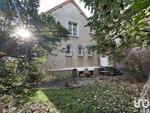
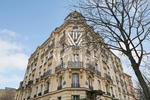
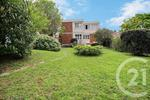
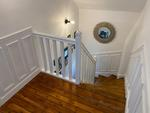
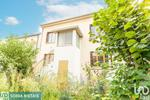
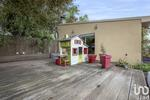
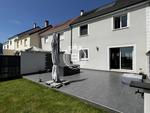
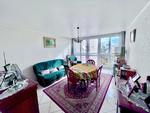
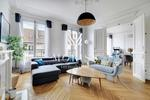
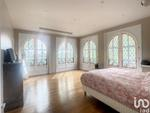

In [ ]:
df_automl_landmarks_images = add_images_thumbnail_to_df(df_automl_landmarks[:10])
# displaying PIL.Image objects embedded in dataframe
HTML(df_automl_landmarks_images[[ 'image', 'landmark_0_description', 'landmark_1_description' ]].to_html(formatters={'image': image_formatter}, escape=False))

## Cloud vision Logos

In [40]:
%%bigquery df_logos

with results as (SELECT 
  uri, logo_annotations
  , string(json_extract(l, '$.description')) as description
  , float64(json_extract (l, '$.score')) as score  
  , string(json_extract(l, '$.mid')) as mid    
  , json_extract(l, '$.bounding_poly') as bounding_poly      
FROM  `ml-demo-384110.immo_us.temp_image_results_test`  
left join unnest(json_extract_array(logo_annotations)) as l
)

SELECT * from results
where score > 0.0
order by score asc



Downloading: 100%|██████████| 2242/2242 [00:02<00:00, 803.19rows/s]


In [41]:
df_logos

uri  \
0     gs://ml-demo-384110-bucket/dataset/immo/images...   
1     gs://ml-demo-384110-bucket/dataset/immo/images...   
2     gs://ml-demo-384110-bucket/dataset/immo/images...   
3     gs://ml-demo-384110-bucket/dataset/immo/images...   
4     gs://ml-demo-384110-bucket/dataset/immo/images...   
...                                                 ...   
2237  gs://ml-demo-384110-bucket/dataset/immo/images...   
2238  gs://ml-demo-384110-bucket/dataset/immo/images...   
2239  gs://ml-demo-384110-bucket/dataset/immo/images...   
2240  gs://ml-demo-384110-bucket/dataset/immo/images...   
2241  gs://ml-demo-384110-bucket/dataset/immo/images...   

                                       logo_annotations  \
0     [{"bounding_poly":{"vertices":[{"x":994,"y":24...   
1     [{"bounding_poly":{"vertices":[{"x":1279,"y":9...   
2     [{"bounding_poly":{"vertices":[{"x":1275,"y":9...   
3     [{"bounding_poly":{"vertices":[{"x":369,"y":25...   
4     [{"bounding_poly":{"vertices":[{"x":144,"y":33...   
...                                                 ...   
2237  [{"bounding_poly":{"vertices":[{"x":1844,"y":1...   
2238  [{"bounding_poly":{"vertices":[{"x":3061,"y":1...   
2239  [{"bounding_poly":{"vertices":[{"x":1875,"y":1...   
2240  [{"bounding_poly":{"vertices":[{"x":3067,"y":1...   
2241  [{"bounding_poly":{"vertices":[{"x":2756,"y":1...   

                     description     score          mid  \
0             Red Uno de Bolivia  0.550074   /m/09v609y   
1                        Unbabel  0.550083  /m/0138nb9l   
2                        Unbabel  0.550126  /m/0138nb9l   
3     The Paley Center For Media  0.550226    /m/09lswq   
4                            NBA  0.550271     /m/05jvx   
...                          ...       ...          ...   
2237                  Century 21  0.980171    /m/080_1g   
2238                  Century 21  0.980767    /m/080_1g   
2239                  Century 21  0.981393    /m/080_1g   
2240                  Century 21  0.983024    /m/080_1g   
2241                  Century 21  0.983917    /m/080_1g   

                                          bounding_poly  
0     {"vertices":[{"x":1280,"y":913},{"x":1438,"y":...  
1     {"vertices":[{"x":1279,"y":917},{"x":1439,"y":...  
2     {"vertices":[{"x":1275,"y":904},{"x":1441,"y":...  
3     {"vertices":[{"x":369,"y":256},{"x":523,"y":25...  
4     {"vertices":[{"x":144,"y":333},{"x":431,"y":33...  
...                                                 ...  
2237  {"vertices":[{"x":1844,"y":1109},{"x":2041,"y"...  
2238  {"vertices":[{"x":3061,"y":1511},{"x":3366,"y"...  
2239  {"vertices":[{"x":1875,"y":1159},{"x":2039,"y"...  
2240  {"vertices":[{"x":3067,"y":1521},{"x":3367,"y"...  
2241  {"vertices":[{"x":2756,"y":1359},{"x":3029,"y"...  

[2242 rows x 6 columns]

In [38]:
df_logos_poly = add_images_thumbnail_withpoly_to_df(df_logos[:2], 400)

# displaying PIL.Image objects embedded in dataframe

HTML(df_logos_poly[[ 'image_full','image', 'description', 'score', 'mid' ]]
     .to_html(formatters={'image_full': image_formatter,
                          #'image': image_formatter
                          }, escape=False))


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_70832/607051090.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_70832/607051090.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_full'] = df.object_name.map(lambda f: download_blob(bucket_name, f))


TypeError: the JSON object must be str, bytes or bytearray, not NoneType

In [6]:
%%bigquery df_automl_logos

SELECT * FROM (
SELECT uri,   
string(logo_annotations[0].description) as logo_description,
logo_annotations[0].score as logo_score
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  where Status =""    

union ALL

SELECT uri,       
string(logo_annotations[1].description) as logo_description,
logo_annotations[1].score as logo_score
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  where Status ="" 

union  ALL

SELECT uri,       
string(logo_annotations[2].description) as logo_description,
logo_annotations[2].score as logo_score
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  where Status ="" 
        
    
# and uri = 	"gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-02_product-1303126-3.jpg"
)
    where logo_description != "" and logo_score > 0.8


Executing query with job ID: 3153167e-0cdc-4937-93a7-23723724cfe2
Query executing: 0.72s


ERROR:
 400 No matching signature for operator > for argument types: JSON, FLOAT64. Supported signature: ANY > ANY at [24:38]

Location: US
Job ID: 3153167e-0cdc-4937-93a7-23723724cfe2



In [9]:
df_automl_logos

uri  \
0     gs://ml-demo-384110-bucket/dataset/immo/images...   
1     gs://ml-demo-384110-bucket/dataset/immo/images...   
2     gs://ml-demo-384110-bucket/dataset/immo/images...   
3     gs://ml-demo-384110-bucket/dataset/immo/images...   
4     gs://ml-demo-384110-bucket/dataset/immo/images...   
...                                                 ...   
2237  gs://ml-demo-384110-bucket/dataset/immo/images...   
2238  gs://ml-demo-384110-bucket/dataset/immo/images...   
2239  gs://ml-demo-384110-bucket/dataset/immo/images...   
2240  gs://ml-demo-384110-bucket/dataset/immo/images...   
2241  gs://ml-demo-384110-bucket/dataset/immo/images...   

                                       logo_annotations  \
0     [{"bounding_poly":{"vertices":[{"x":1561,"y":9...   
1     [{"bounding_poly":{"vertices":[{"x":1278,"y":9...   
2     [{"bounding_poly":{"vertices":[{"x":857,"y":96...   
3     [{"bounding_poly":{"vertices":[{"x":683,"y":59...   
4     [{"bounding_poly":{"vertices":[{"x":1225,"y":6...   
...                                                 ...   
2237  [{"bounding_poly":{"vertices":[{"x":1707,"y":8...   
2238  [{"bounding_poly":{"vertices":[{"x":1796,"y":1...   
2239  [{"bounding_poly":{"vertices":[{"x":1822,"y":1...   
2240  [{"bounding_poly":{"vertices":[{"x":1705,"y":8...   
2241  [{"bounding_poly":{"vertices":[{"x":1705,"y":8...   

                     description       score            mid  
0                        Mirazur  0.55109495     /m/05zmk5c  
1                           Luno  0.56318939  /g/11bxds8tgr  
2     Universidad del Desarrollo  0.58145773     /m/06w81fd  
3                   RR Donnelley  0.55514187      /m/0cmmtt  
4                             e2  0.56274503     /m/02pn7k9  
...                          ...         ...            ...  
2237          Red Uno de Bolivia  0.57968342     /m/09v609y  
2238                  Century 21    0.712345      /m/080_1g  
2239                  Century 21  0.89177716      /m/080_1g  
2240          Red Uno de Bolivia   0.5631032     /m/09v609y  
2241          Red Uno de Bolivia  0.61028481     /m/09v609y  

[2242 rows x 5 columns]

In [42]:
%%bigquery 

SELECT logo_description,  count(*) nb FROM (

select * from (
SELECT uri,   
string(logo_annotations[0].description) as logo_description,
FLOAT64(logo_annotations[0].score) as logo_score
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  where Status =""    
) where logo_score > 0.8

union ALL

select * from (
SELECT uri,       
string(logo_annotations[1].description) as logo_description,
FLOAT64(logo_annotations[1].score) as logo_score
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  where Status ="" 
) where logo_score > 0.0

union  ALL

select * from (
SELECT uri,       
string(logo_annotations[2].description) as logo_description,
FLOAT64(logo_annotations[2].score) as logo_score
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  where Status =""  
) where logo_score > 0.0

)
    where logo_description != "" 
    group by logo_description
    order by nb desc


Downloading: 100%|██████████| 20/20 [00:01<00:00, 10.34rows/s]


logo_description   nb
0                      Century 21  299
1                         Unbabel    2
2        Radio Programas del Perú    2
3        Ralph Lauren Corporation    2
4        Paris Saint-Germain F.C.    2
5                    Fogo de Chão    1
6                  The Lego Group    1
7                          Pro TV    1
8                  Alain Afflelou    1
9               Rede Bandeirantes    1
10  University of Eastern Finland    1
11           Six Flags AstroWorld    1
12               Wildhorse Saloon    1
13         Bellerive Country Club    1
14                       Facebook    1
15                   Square, Inc.    1
16              Windrose Airlines    1
17                         Stöð 2    1
18                            EFE    1
19       Frankfurt Stock Exchange    1

In [ ]:
%%bigquery  df_automl_logos

select * from (
    
select * from (
SELECT uri,   
string(logo_annotations[0].description) as logo_description,
FLOAT64(logo_annotations[0].score) as logo_score
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  where Status =""    
) 

)
    where logo_description != "" and  logo_description != "Century 21"
and logo_score > 0.8

Query is running:   0%|          |

Downloading:   0%|          |

/var/tmp/ipykernel_1218896/1434506233.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/var/tmp/ipykernel_1218896/1434506233.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f), size))



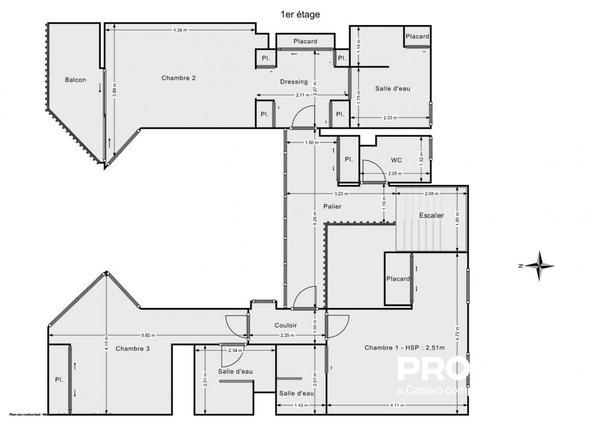
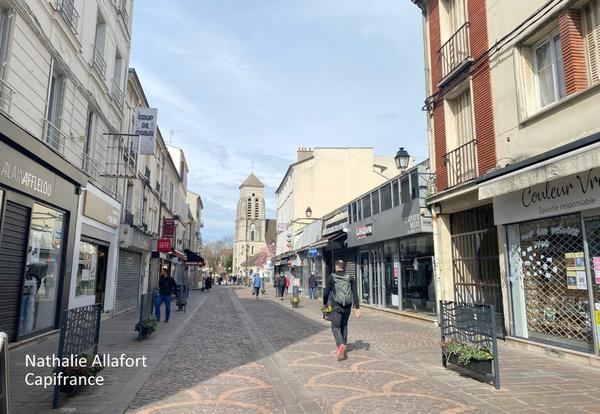
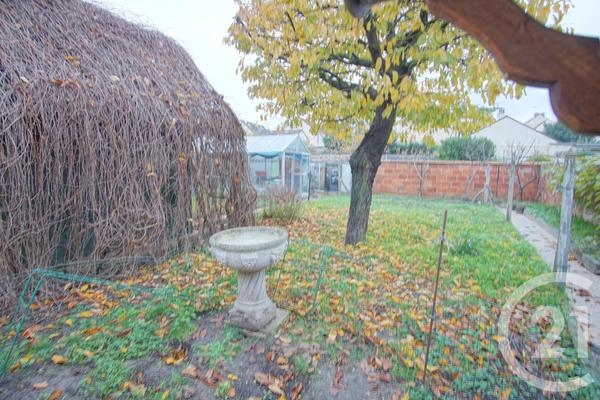
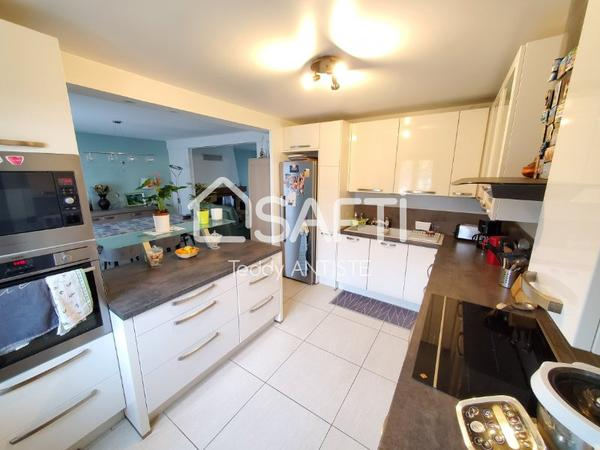
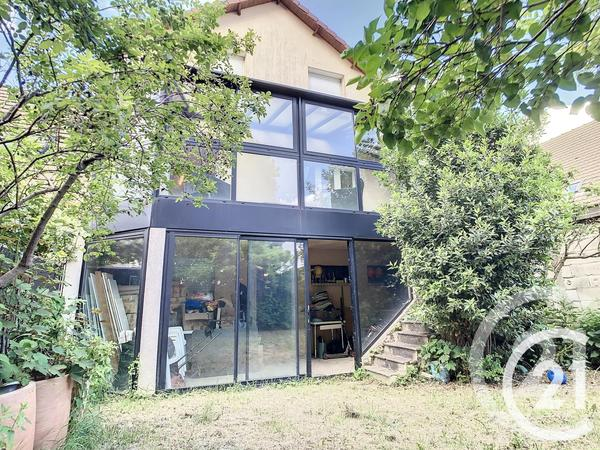
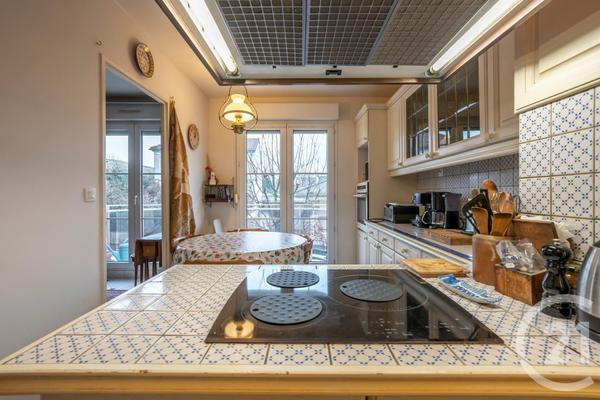
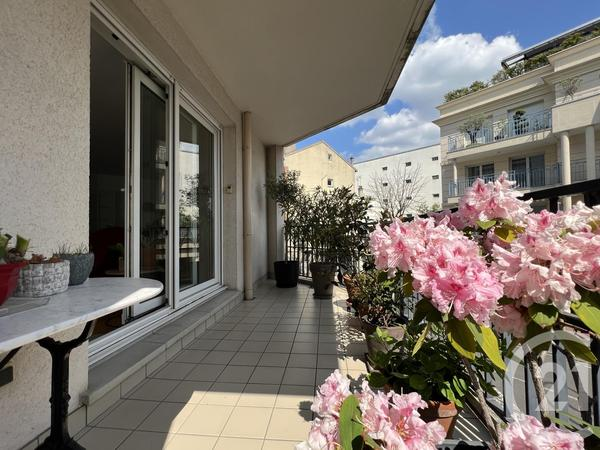
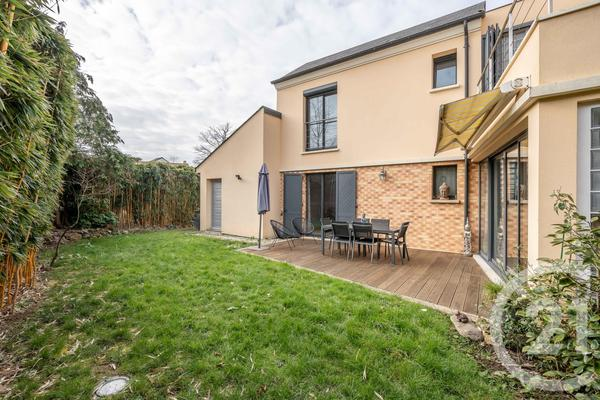
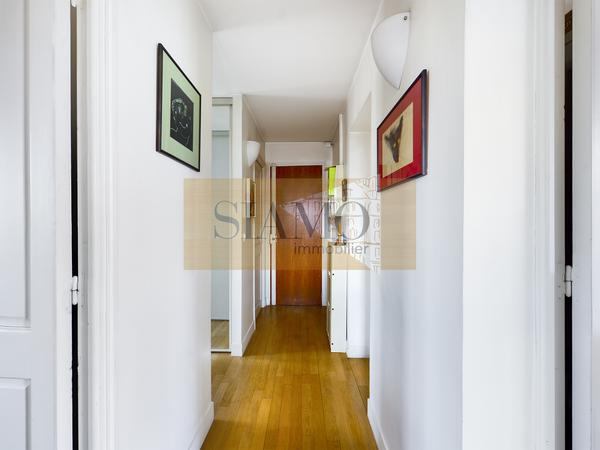
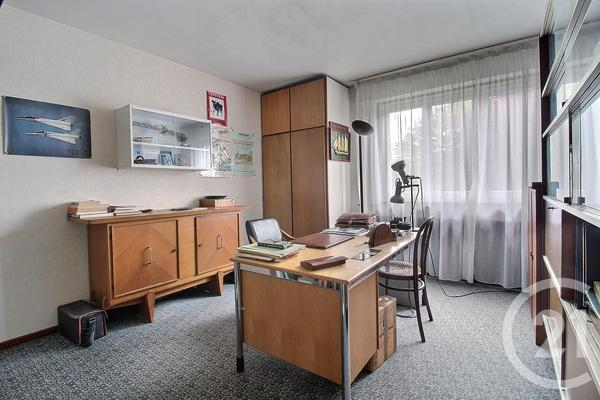

In [ ]:
df_automl_landmarks_images = add_images_thumbnail_to_df(df_automl_logos[:10], 600)

# displaying PIL.Image objects embedded in dataframe
HTML(df_automl_landmarks_images[[ 'image', 'logo_description' #, 'logo_score', 'uri'  
                                ]].to_html(formatters={'image': image_formatter}, escape=False))


#HTML(df_automl_logos_images[[ 'image', 'logo_0_description', 'logo_1_description', 'logo_2_description' ]].to_html(formatters={'image': image_formatter}, escape=False))

In [43]:
%%bigquery  
#df_automl_logo

with results as (SELECT 
  uri, logo_annotations,
  , json_extract_scalar(l, '$.description') as description
  , json_extract_scalar(l, '$.score') as score  
  , json_extract_scalar(l, '$.mid') as mid    
FROM  `ml-demo-384110.immo_us.temp_image_results_test`  
left join unnest(json_extract_array(logo_annotations)) as l
)

SELECT * from results
where description != ""
#and uri = "gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-03_product-1320330-15.jpg" 


Executing query with job ID: 34b1dc94-58d8-495b-8fd5-d39c9db9685e
Query executing: 0.50s


ERROR:
 400 Syntax error: Expected ")" but got "," at [5:3]

Location: US
Job ID: 34b1dc94-58d8-495b-8fd5-d39c9db9685e



In [48]:
%%bigquery

with results as (
SELECT uri, logo_annotations
, string(json_extract(l, '$.description')) as description
, float64(json_extract (l, '$.score')) as score
, string(json_extract(l, '$.mid')) as mid
, json_extract(l, '$.bounding_poly').vertices as bounding_poly
FROM `ml-demo-384110.immo_us.temp_image_results_test`
left join unnest(json_extract_array(logo_annotations)) as l
)
select * from (
SELECT description, min(score) min, max(score) max,  count(*) nb FROM results

where score > 0.56 
) where nb > 5
group by description
order by nb desc


Executing query with job ID: 46534938-ab87-4191-b6ed-33945542714c
Query executing: 0.61s


ERROR:
 400 SELECT list expression references column description which is neither grouped nor aggregated at [11:8]

Location: US
Job ID: 46534938-ab87-4191-b6ed-33945542714c



## Cloud Vision Labels
- LABEL_DETECTION
- https://cloud.google.com/vision/docs/labels

In [86]:
%%bigquery  df_automl_labels

with results as (
SELECT uri, label_annotations
, string(json_extract(l, '$.description')) as description
, float64(json_extract (l, '$.score')) as score
, string(json_extract(l, '$.mid')) as mid
, json_extract(l, '$.bounding_poly').vertices as bounding_poly
FROM `ml-demo-384110.immo_us.temp_image_results_test`
left join unnest(json_extract_array(label_annotations)) as l
)
select description, score, uri from results where score > 0.70






Downloading: 100%|██████████| 34/34 [00:02<00:00, 14.64rows/s]


In [87]:
df_automl_labels.describe()

score
count  34.000000
mean    0.525877
std     0.014497
min     0.500294
25%     0.515509
50%     0.524121
75%     0.539991
max     0.547983

In [101]:
%%bigquery  

with results as (
SELECT uri, label_annotations
, string(json_extract(l, '$.description')) as description
, float64(json_extract (l, '$.score')) as score
, string(json_extract(l, '$.mid')) as mid
, json_extract(l, '$.bounding_poly').vertices as bounding_poly
FROM `ml-demo-384110.immo_us.temp_image_results_test`
left join unnest(json_extract_array(label_annotations)) as l
)
select bucket, count(score) from (
select description, score ,
RANGE_BUCKET(score, [0, 0.5, 0.7, 0.8, 0.9, 1.0 ]) AS bucket,
from results where score > 0.0 
)
group by bucket




Downloading: 100%|██████████| 4/4 [00:02<00:00,  1.51rows/s]


bucket    f0_
0       5  12950
1       4  24235
2       3   3322
3       2    544

In [74]:
%%bigquery  df_labels_20_best


with results as (
SELECT uri, label_annotations
, string(json_extract(l, '$.description')) as description
, float64(json_extract (l, '$.score')) as score
, string(json_extract(l, '$.mid')) as mid
, json_extract(l, '$.bounding_poly').vertices as bounding_poly
FROM `ml-demo-384110.immo_us.temp_image_results_test`
left join unnest(json_extract_array(label_annotations)) as l
)
select description, results.score from results where description in(
select description from (
select description, count(score) nb,  min(score) min, max(score) max, stddev(score) as stddev, avg(score) as avg from results where score > 0.0 
 group by description
 order by nb desc
 )
 where nb > 520 
)
 ;

Downloading: 100%|██████████| 26155/26155 [00:02<00:00, 10719.94rows/s]


In [75]:
df_labels_20_best.describe()


score
count  26155.000000
mean       0.884773
std        0.049328
min        0.515996
25%        0.847766
50%        0.879000
75%        0.934677
max        0.978130

<Axes: >

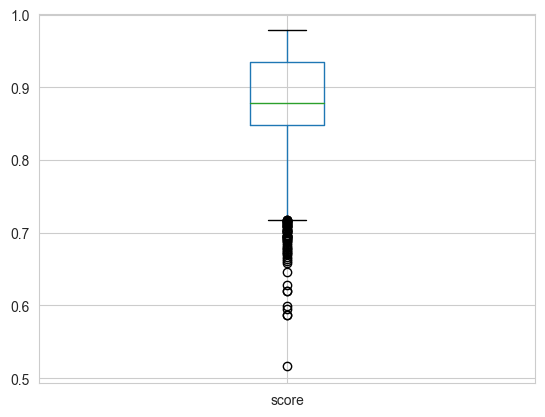

In [76]:
df_labels_20_best.boxplot()


In [77]:
%%bigquery df_labels_worst

with results as (
SELECT uri, label_annotations
, string(json_extract(l, '$.description')) as description
, float64(json_extract (l, '$.score')) as score
, string(json_extract(l, '$.mid')) as mid
, json_extract(l, '$.bounding_poly').vertices as bounding_poly
FROM `ml-demo-384110.immo_us.temp_image_results_test`
left join unnest(json_extract_array(label_annotations)) as l
)
select description, score from results 
where description in (
select description from (
select description, count(score) nb from results where score > 0.0
group by description
order by nb desc
)
where nb >= 10 and nb < 16
)




Downloading: 100%|██████████| 454/454 [00:02<00:00, 199.85rows/s]


In [78]:
df_labels_worst.describe()


score
count  454.000000
mean     0.797090
std      0.091994
min      0.513657
25%      0.736544
50%      0.814874
75%      0.862065
max      0.967338

<Axes: >

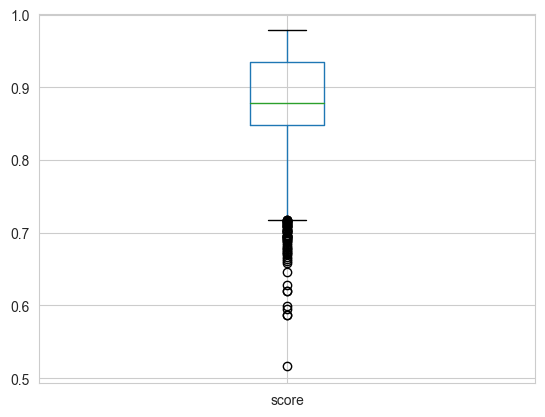

In [79]:
df_labels_20_best.boxplot()


In [60]:
%%bigquery  df_label_annotations_stats

with results as (
SELECT uri, label_annotations
, string(json_extract(l, '$.description')) as description
, float64(json_extract (l, '$.score')) as score
, string(json_extract(l, '$.mid')) as mid
, json_extract(l, '$.bounding_poly').vertices as bounding_poly
FROM `ml-demo-384110.immo_us.temp_image_results_test`
left join unnest(json_extract_array(label_annotations)) as l
)
select description, count(score) nb,  min(score) min, max(score) max, stddev(score) as stddev, avg(score) as avg from results where score > 0.0 
 group by description
 order by nb desc
 limit 10
 
 ;

Downloading: 100%|██████████| 10/10 [00:02<00:00,  4.44rows/s]


In [56]:
%%bigquery  df_label_annotations

with results as (
SELECT uri, label_annotations
, string(json_extract(l, '$.description')) as description
, float64(json_extract (l, '$.score')) as score
, string(json_extract(l, '$.mid')) as mid
, json_extract(l, '$.bounding_poly').vertices as bounding_poly
FROM `ml-demo-384110.immo_us.temp_image_results_test`
left join unnest(json_extract_array(label_annotations)) as l
)
select description, score
 from results where score > 0.0 
 limit 20
 ;

Downloading: 100%|██████████| 41051/41051 [00:02<00:00, 16018.70rows/s]


In [57]:
df_label_annotations.describe()

score
count  41051.000000
mean       0.870663
std        0.060046
min        0.500294
25%        0.837011
50%        0.868217
75%        0.918560
max        0.985713

<Axes: xlabel='avg', ylabel='description'>

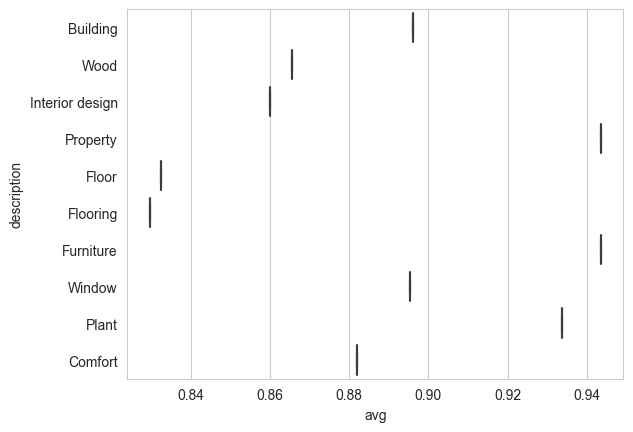

In [70]:
import seaborn as sns
sns.set_style("whitegrid")

sns.boxplot(data=df_label_annotations_stats, x = "avg" , y = "description")






<Axes: title={'center': 'avg'}, xlabel='description'>

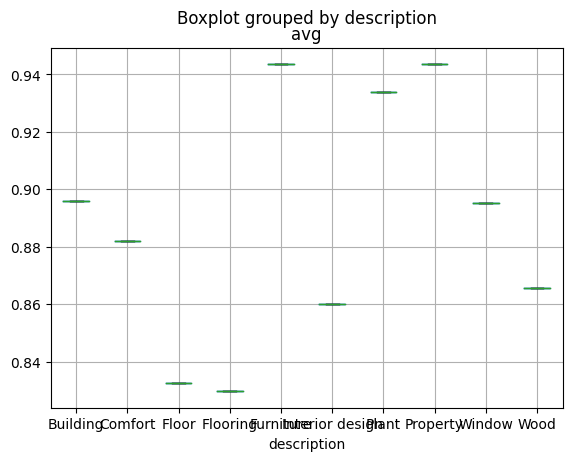

In [69]:
df_label_annotations_stats.boxplot(by ='description', column =['avg'] , grid = False)





In [91]:
%%bigquery  df_automl_labels

with results as (
SELECT uri, label_annotations
, string(json_extract(l, '$.description')) as description
, float64(json_extract (l, '$.score')) as score
, string(json_extract(l, '$.mid')) as mid
FROM `ml-demo-384110.immo_us.temp_image_results_test`
left join unnest(json_extract_array(label_annotations)) as l
)
select description, score, uri from results where score < 0.55


Downloading: 100%|██████████| 34/34 [00:02<00:00, 13.50rows/s]


In [92]:
df_automl_labels

description     score  \
0                Number  0.542173   
1               Pattern  0.530889   
2               Artwork  0.533635   
3               Drawing  0.517613   
4               Drawing  0.531964   
5               Pattern  0.536416   
6         Electric blue  0.513657   
7           Handwriting  0.515463   
8               Pattern  0.503885   
9           Engineering  0.547983   
10             Symmetry  0.543343   
11              Pattern  0.535071   
12             Triangle  0.534527   
13           Screenshot  0.544417   
14  Astronomical object  0.521885   
15       Graphic design  0.505124   
16           Screenshot  0.542133   
17  Astronomical object  0.515646   
18       Graphic design  0.500294   
19           Screenshot  0.544417   
20  Astronomical object  0.521885   
21       Graphic design  0.505124   
22           Screenshot  0.544417   
23  Astronomical object  0.521885   
24       Graphic design  0.505124   
25              Diagram  0.529872   
26             Concrete  0.546289   
27            Landscape  0.514518   
28          Advertising  0.520430   
29            Transport  0.509315   
30          Formal wear  0.526357   
31              Ceiling  0.541183   
32              Machine  0.516877   
33               Window  0.515996   

                                                  uri bounding_poly  
0   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
1   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
2   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
3   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
4   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
5   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
6   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
7   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
8   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
9   gs://ml-demo-384110-bucket/dataset/immo/images...          None  
10  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
11  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
12  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
13  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
14  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
15  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
16  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
17  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
18  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
19  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
20  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
21  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
22  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
23  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
24  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
25  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
26  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
27  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
28  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
29  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
30  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
31  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
32  gs://ml-demo-384110-bucket/dataset/immo/images...          None  
33  gs://ml-demo-384110-bucket/dataset/immo/images...          None

/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_70832/2661338983.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_70832/2661338983.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f), size))



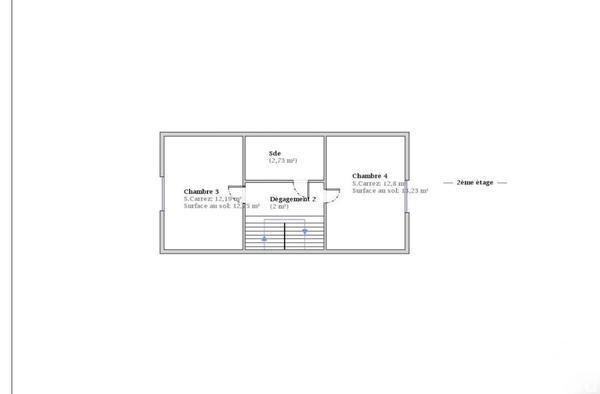
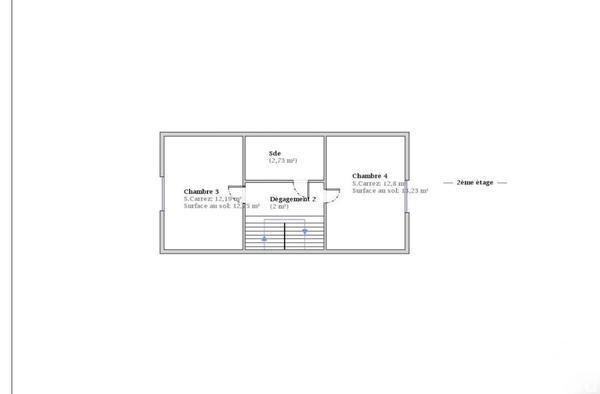
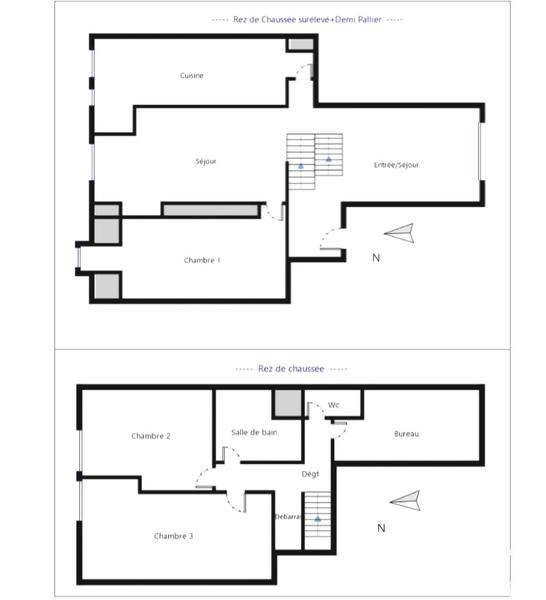
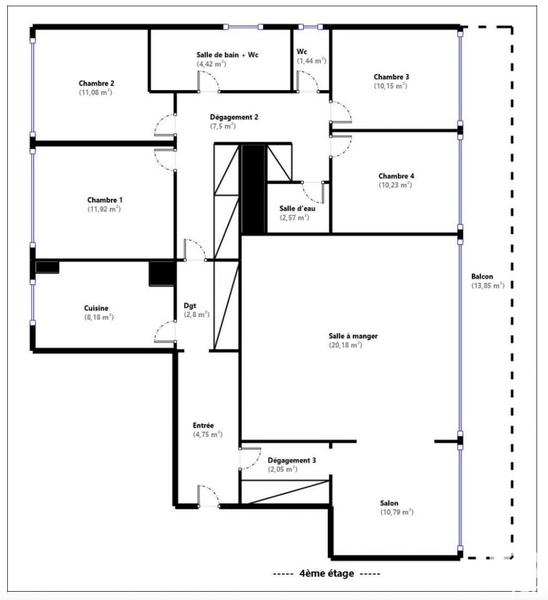
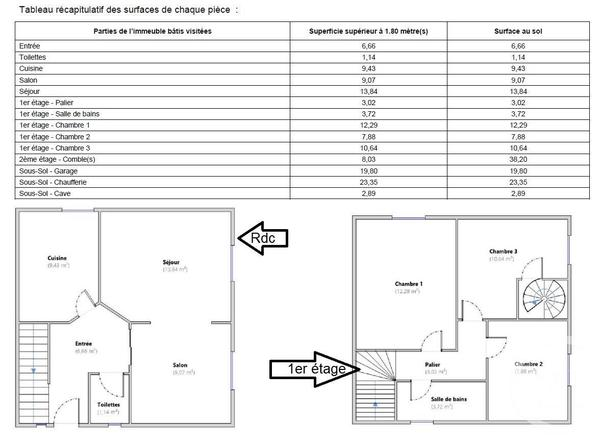
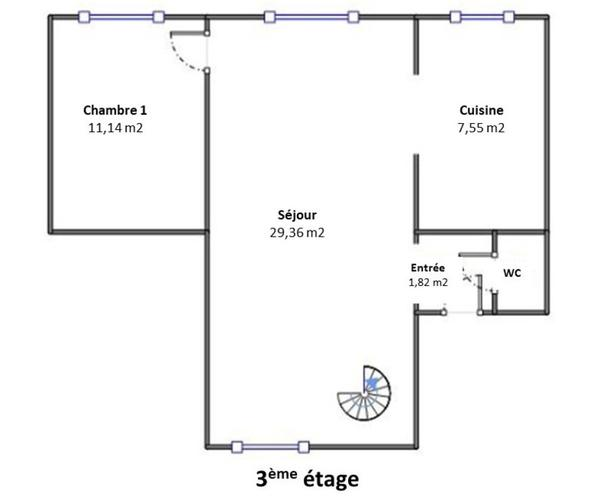
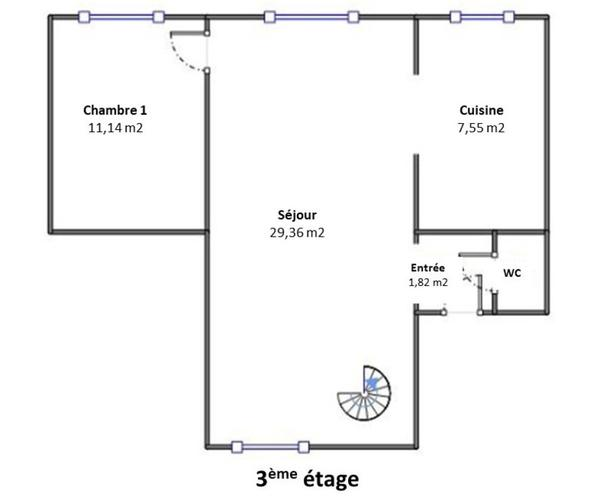
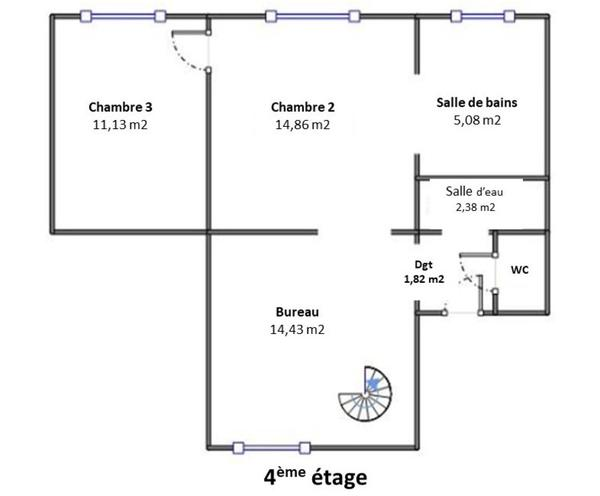
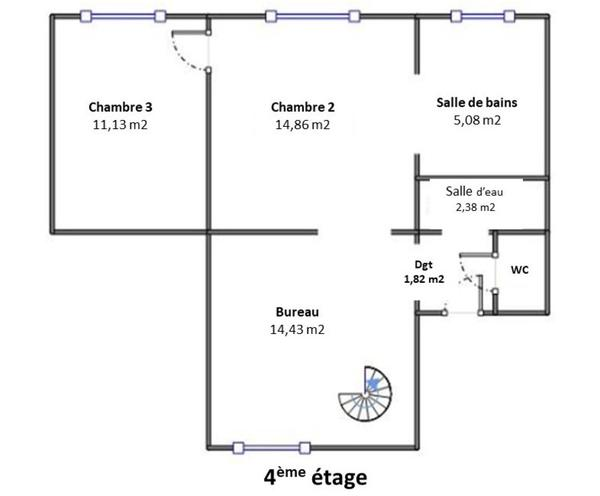
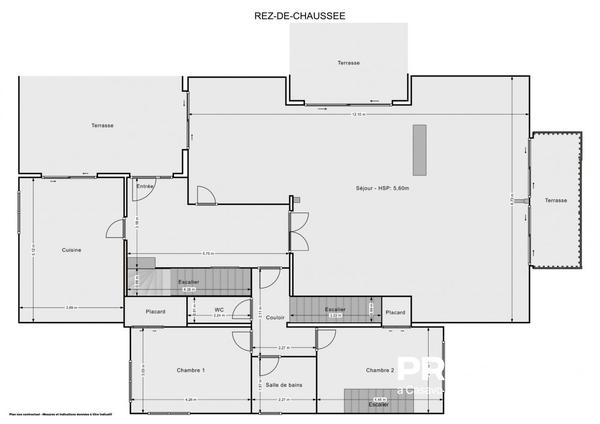

In [89]:
df_automl_labels_images = add_images_thumbnail_to_df(df_automl_labels[:10], 600)

# displaying PIL.Image objects embedded in dataframe
HTML(df_automl_labels_images[[ 'image', 'description' , 'score',   'uri'  
                                ]].to_html(formatters={'image': image_formatter}, escape=False))


In [95]:
%%bigquery df_images_with_attributes_low_score

with results as (
      SELECT
      uri,  metadata_value as Id, label_annotations
      , string(json_extract(l, '$.description')) as description
      , float64(json_extract (l, '$.score')) as score
      , string(json_extract(l, '$.mid')) as mid

 FROM `ml-demo-384110.immo_us.image_cloudvision_results`  as ml_res left join unnest(json_extract_array(label_annotations)) as l
) 
  select       Id,    uri, description, score
FROM results where uri in (
  select           uri
FROM results 
  where score < 0.55


)
  order by Id, uri, score



Downloading: 100%|██████████| 167/167 [00:02<00:00, 61.68rows/s]


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_70832/2661338983.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_70832/2661338983.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f), size))



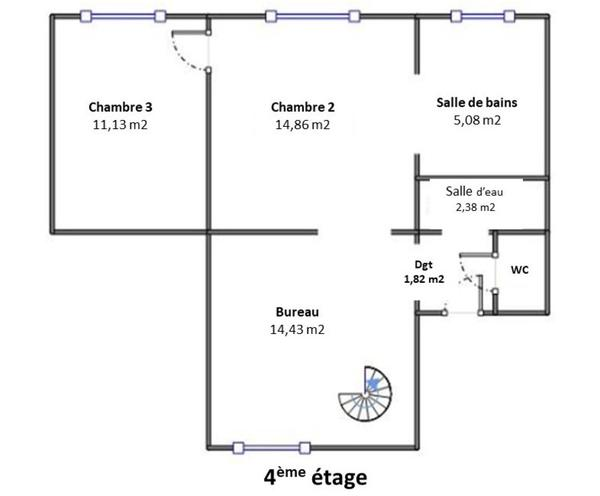
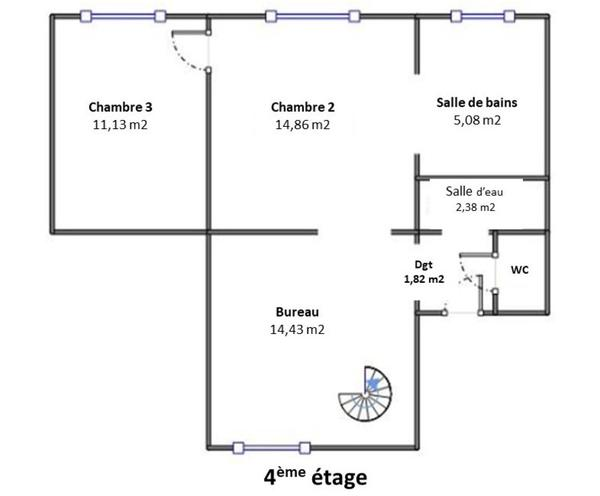
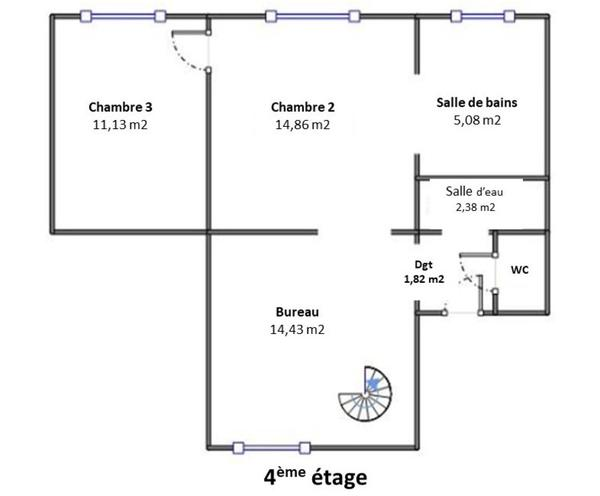
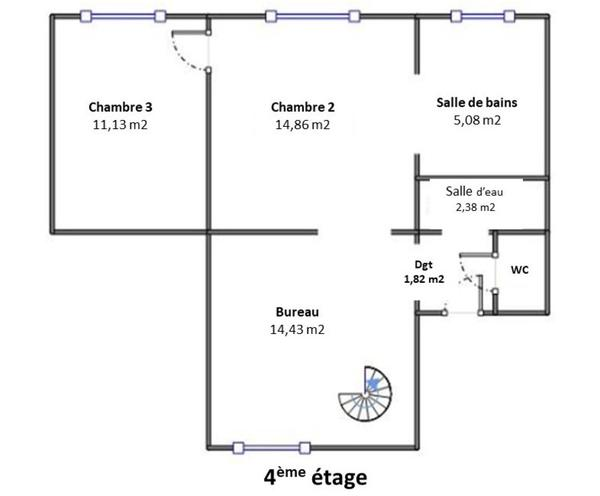
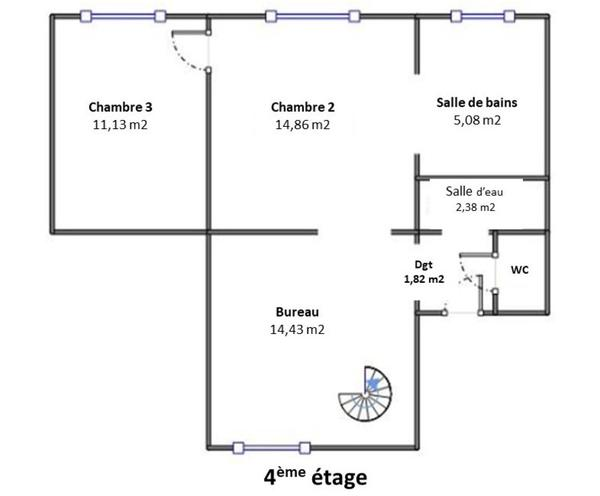
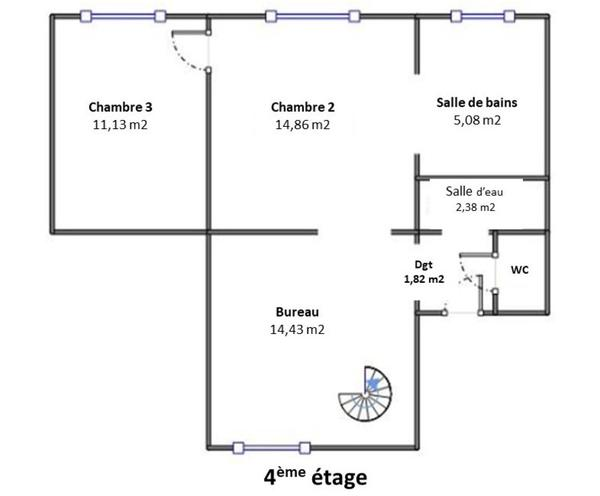
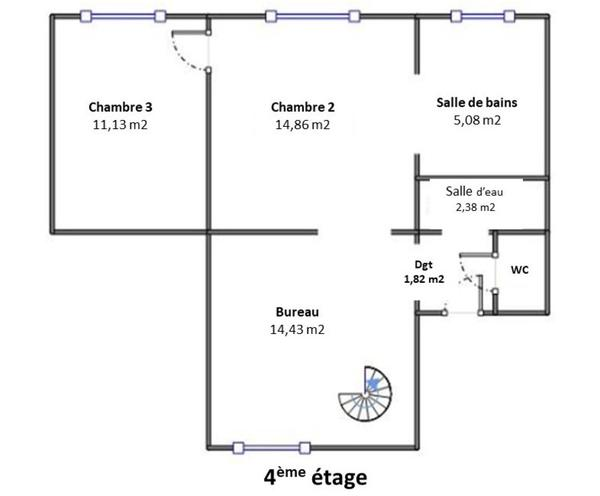
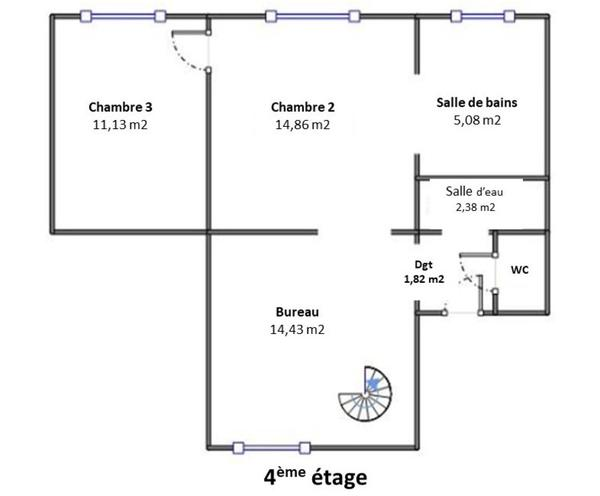
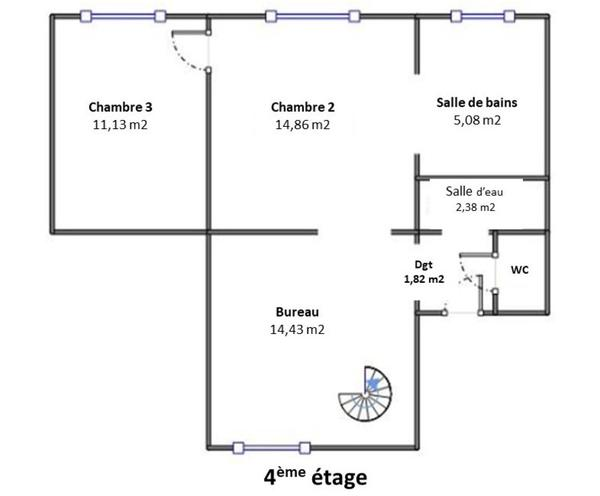
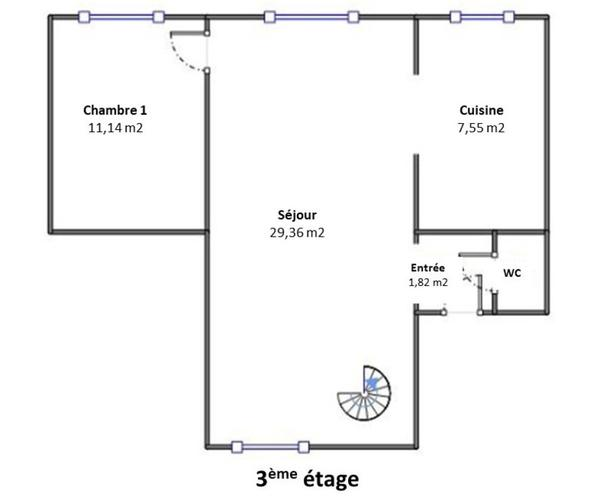
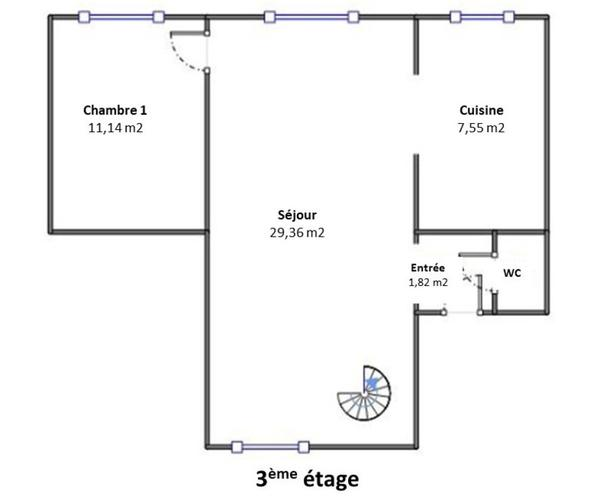
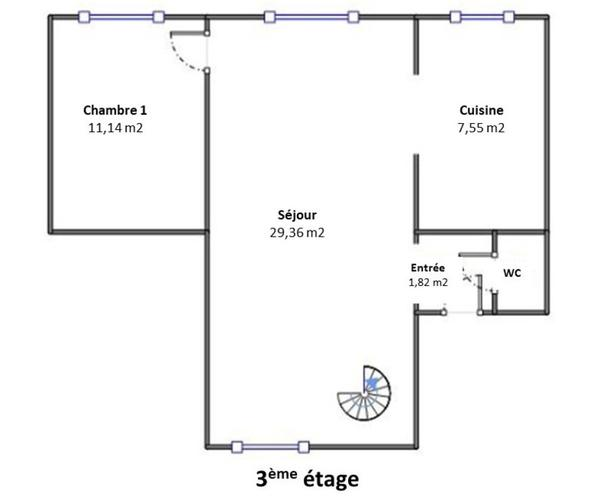
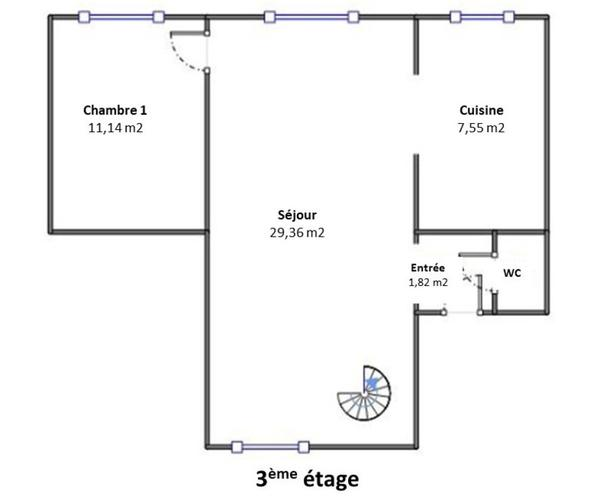
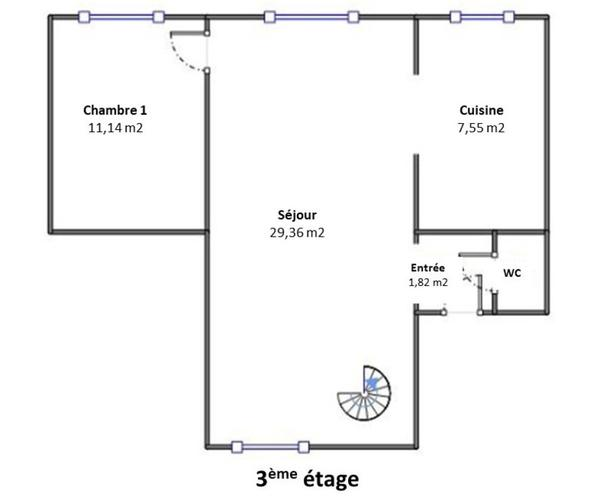
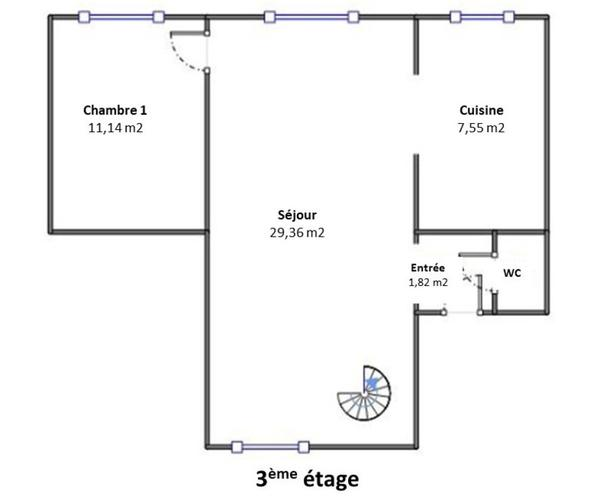
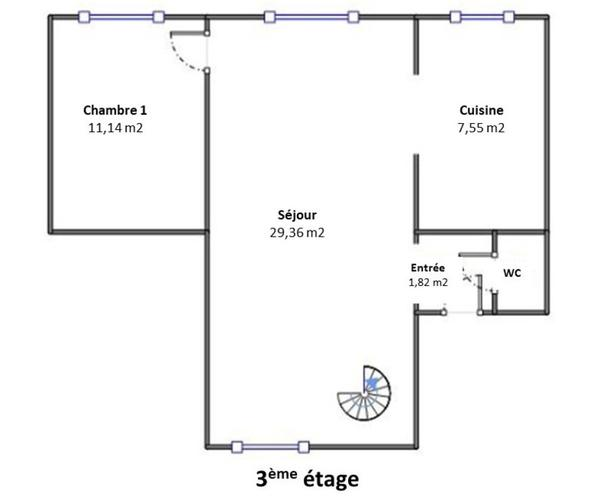
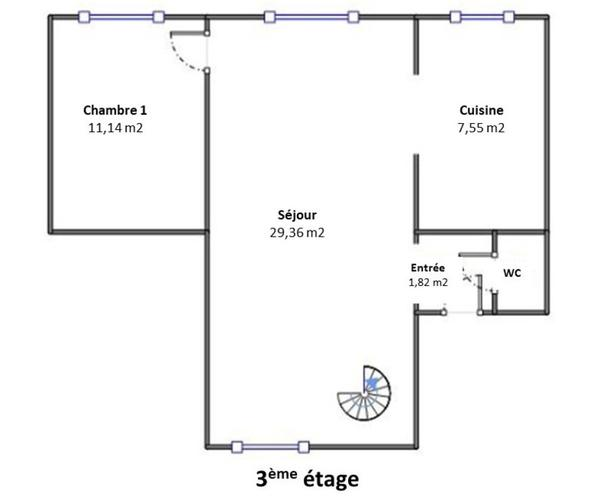
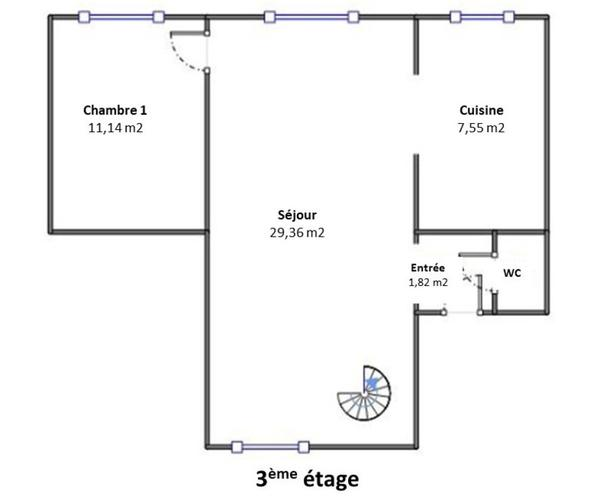
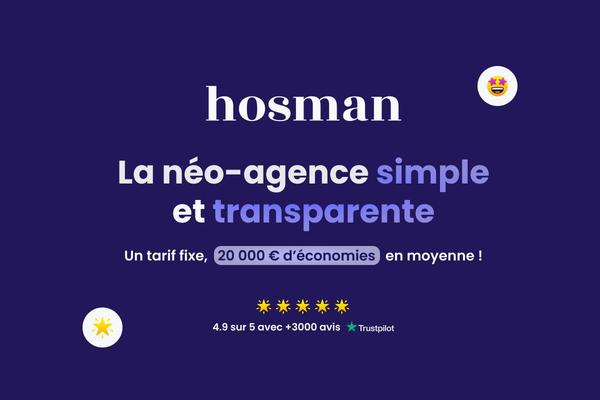
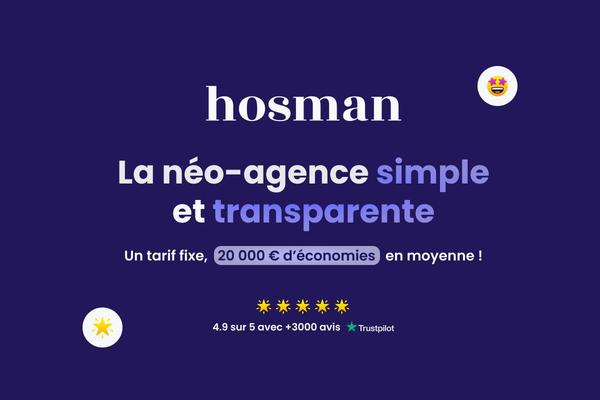
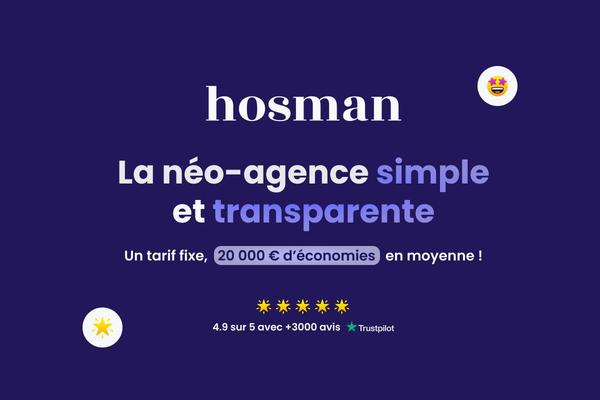
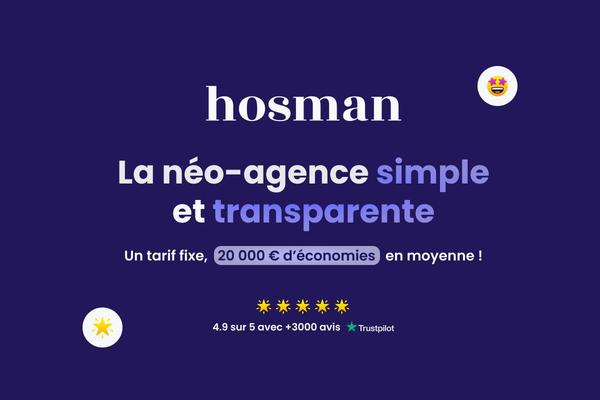
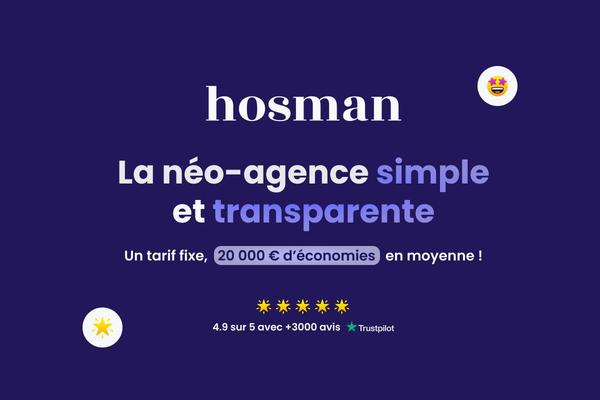
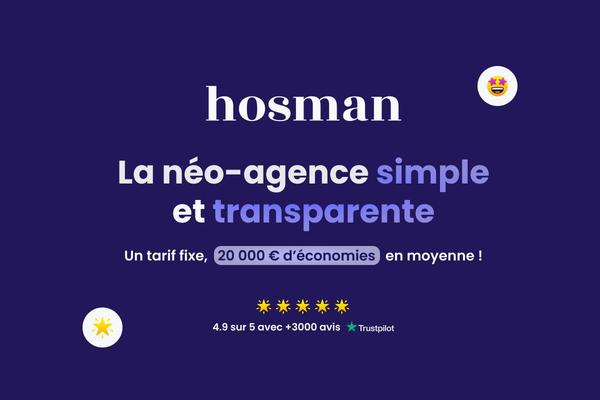
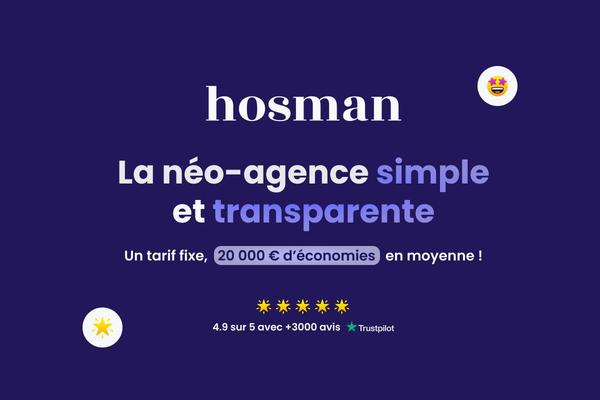
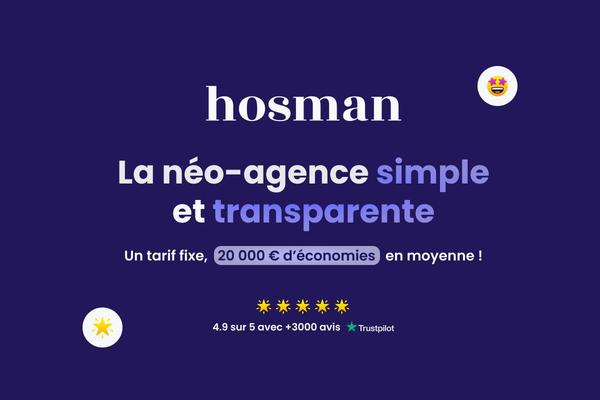
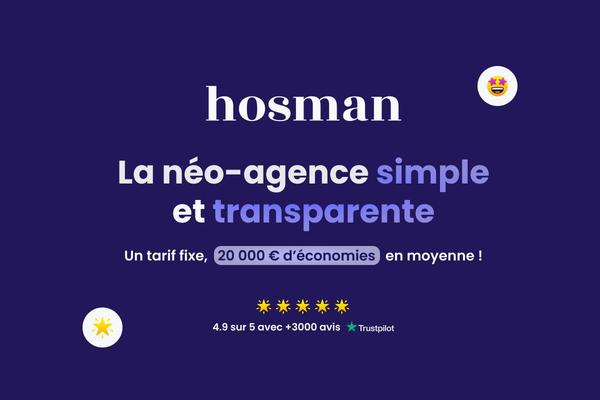
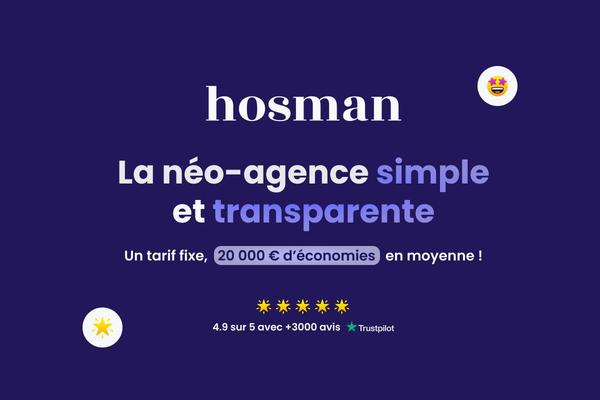
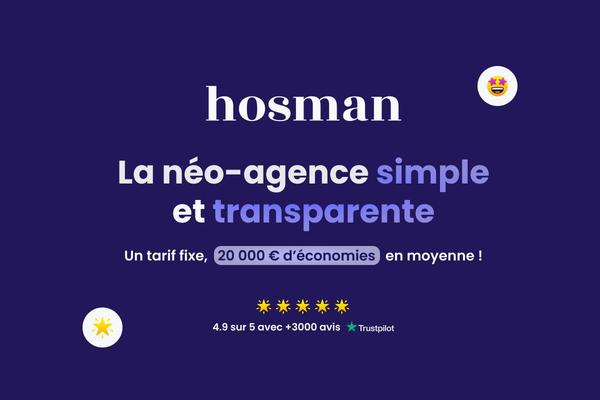
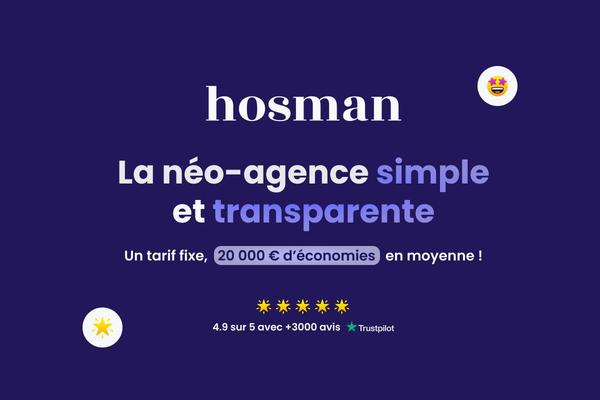
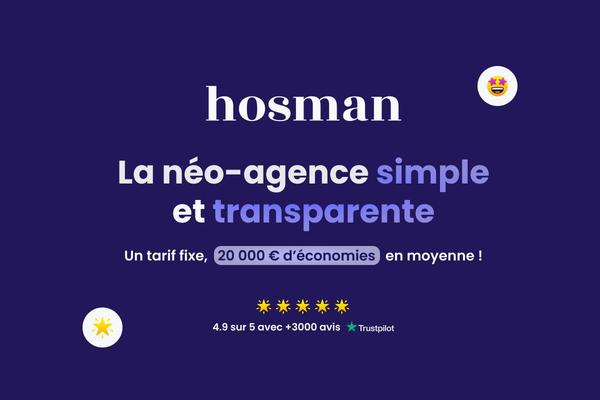
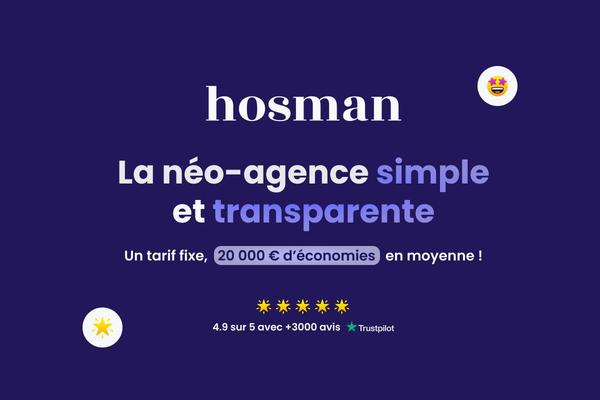
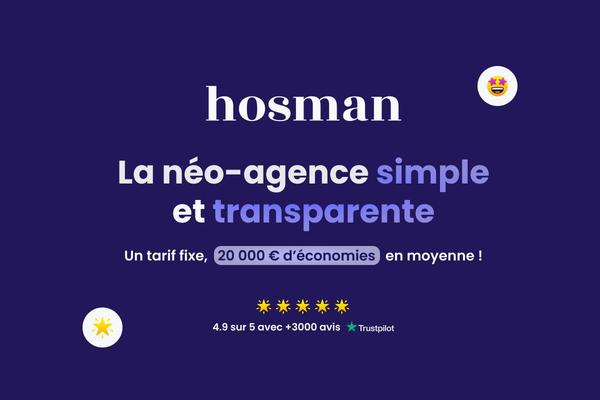
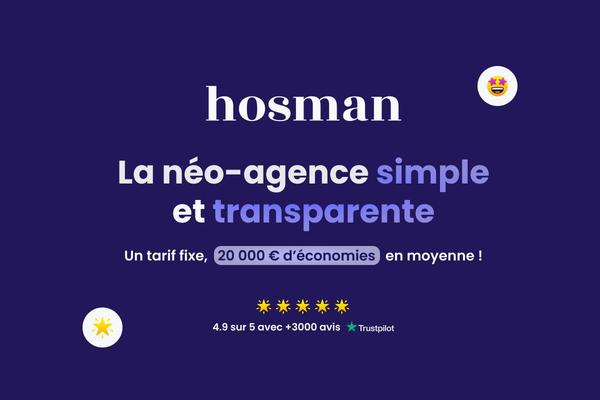
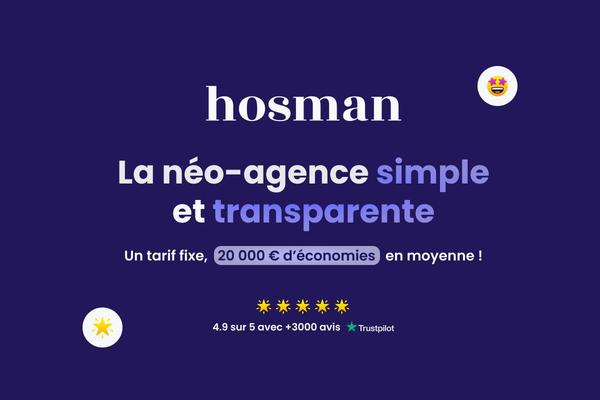
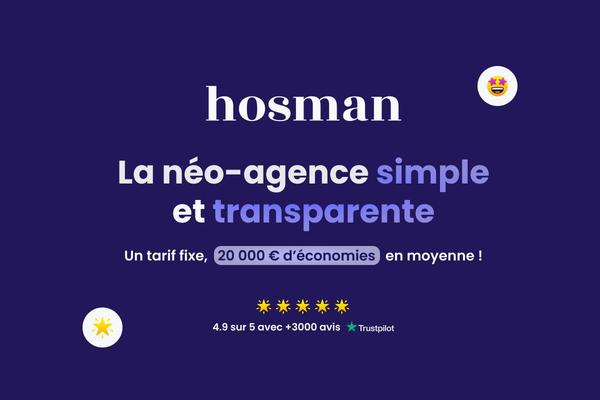
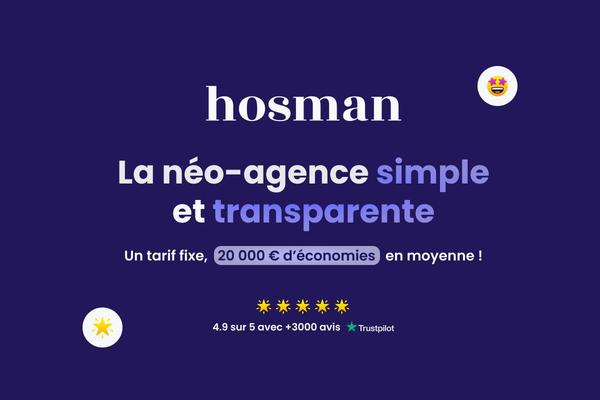
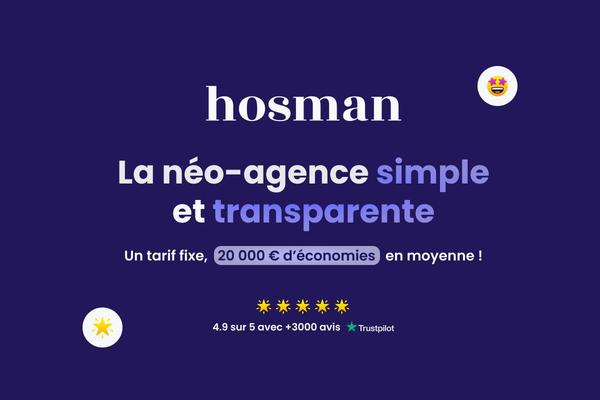
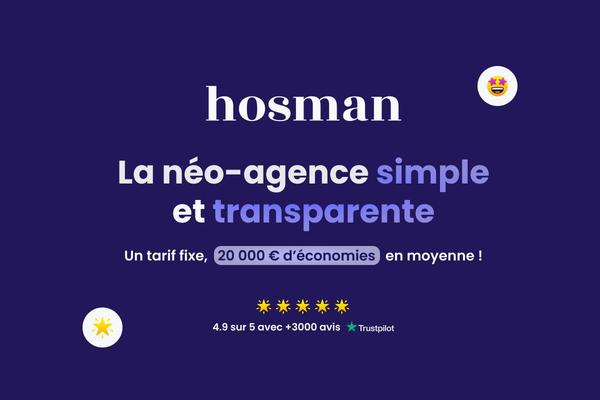
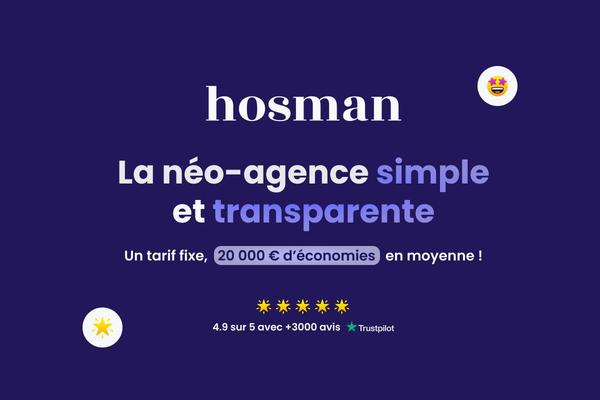
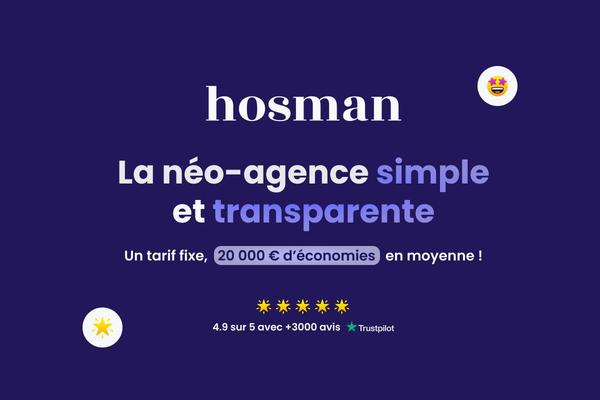
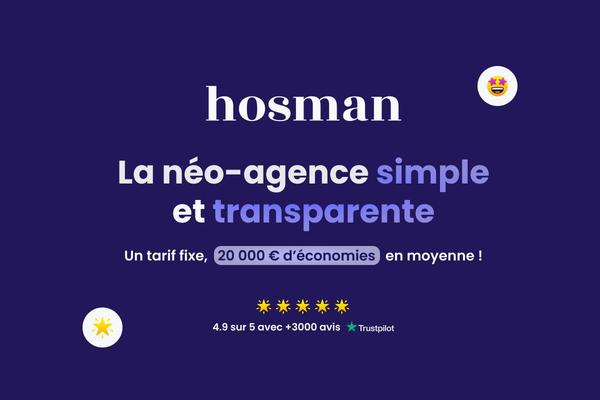
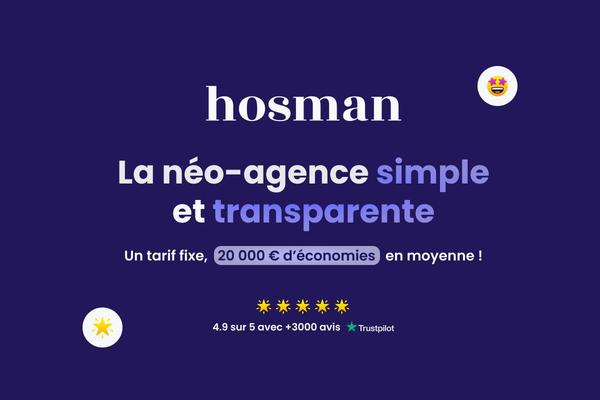
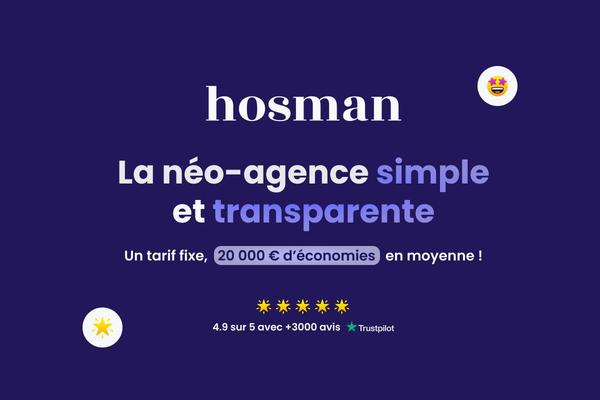
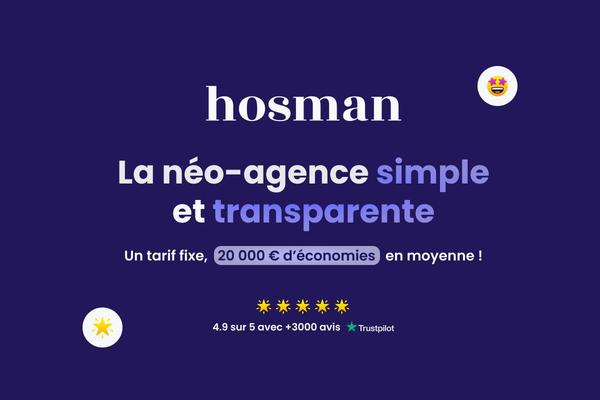
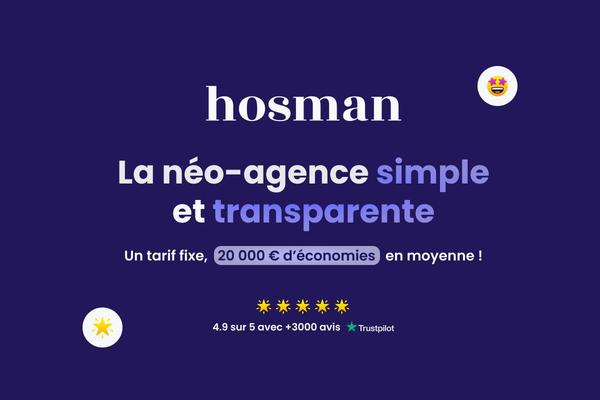
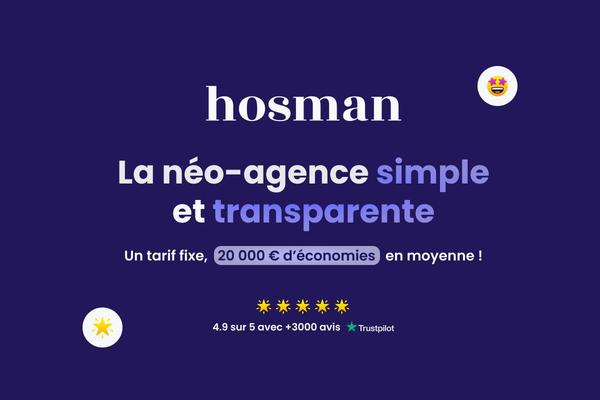
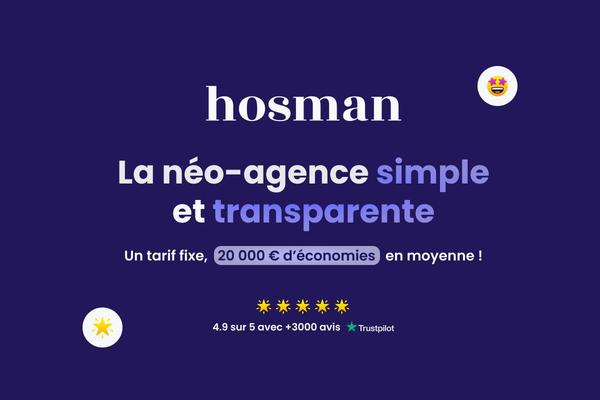
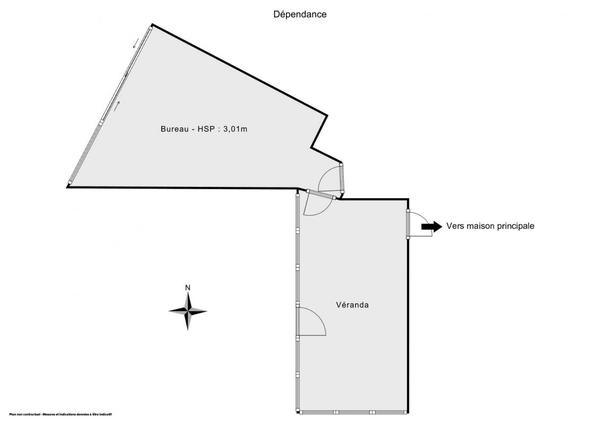
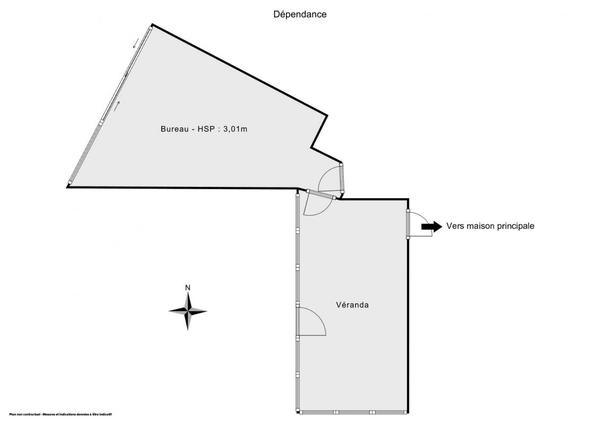
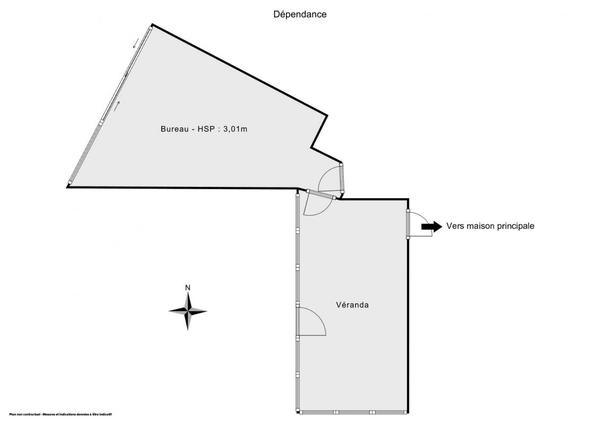
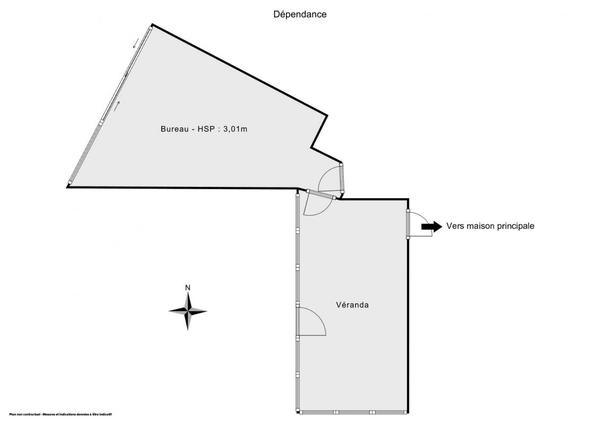
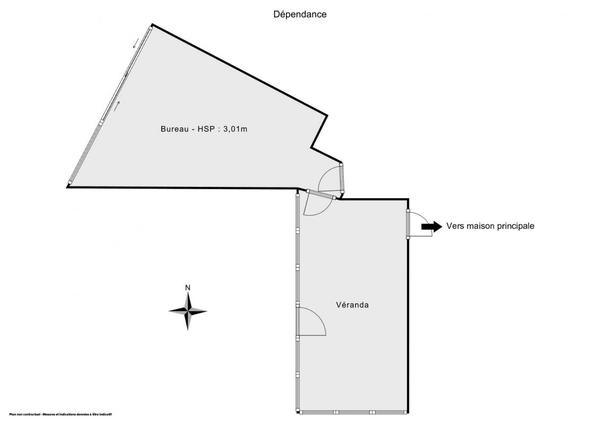
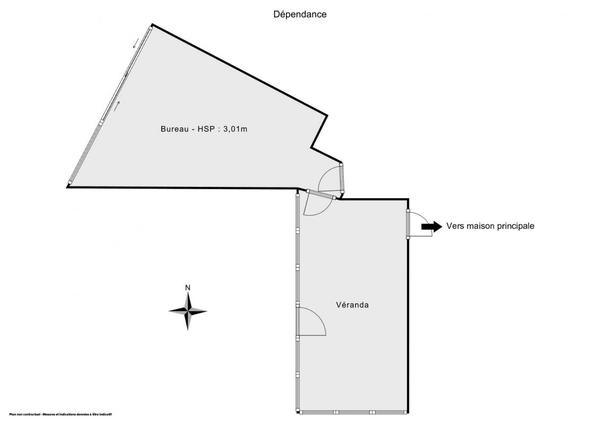
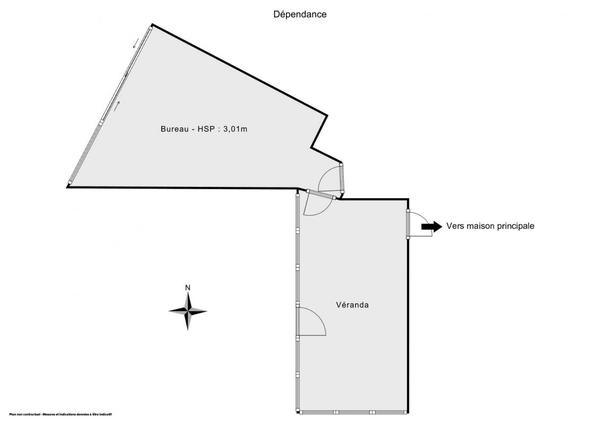
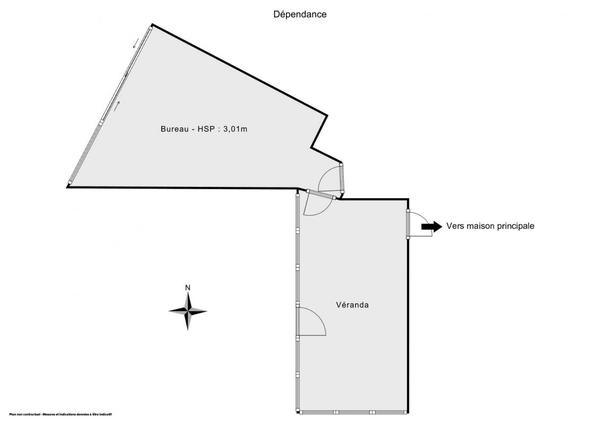
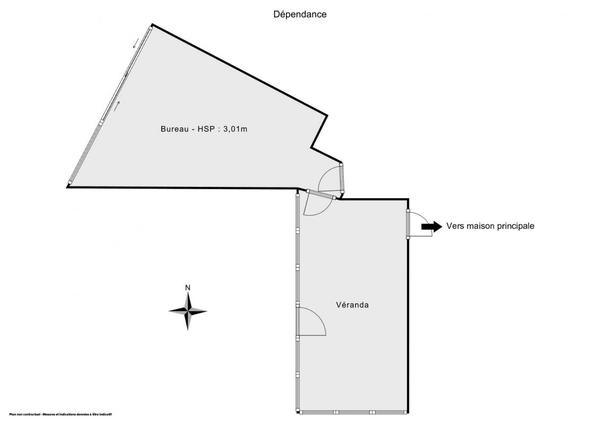
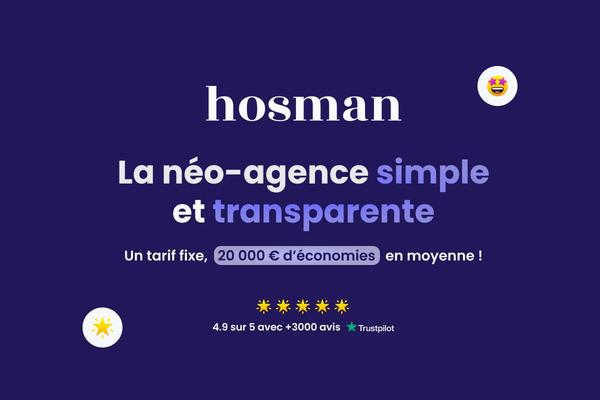
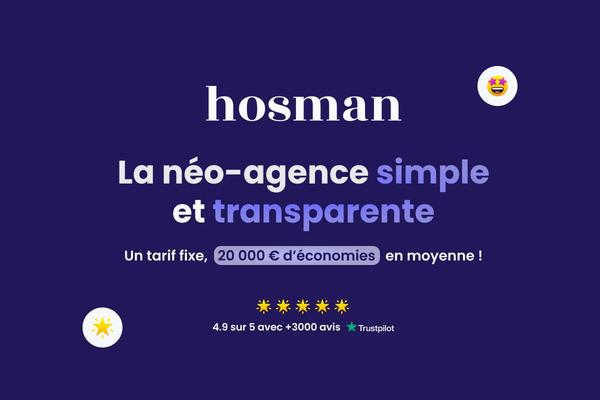
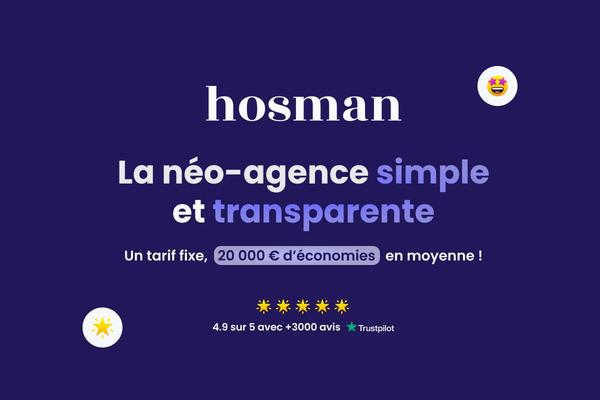

In [98]:
df_images_with_attributes_low_score_images = add_images_thumbnail_to_df(df_images_with_attributes_low_score[:60], 600)

# displaying PIL.Image objects embedded in dataframe
HTML(df_images_with_attributes_low_score_images[['Id', 'image', 'description' , 'score',   'uri'  
                                ]].to_html(formatters={'image': image_formatter}, escape=False))


In [99]:
%%bigquery df_labels

with results as (
SELECT uri, label_annotations
, string(json_extract(l, '$.description')) as description
, float64(json_extract (l, '$.score')) as score
#, string(json_extract(l, '$.mid')) as mid
#, json_extract(l, '$.bounding_poly').vertices as bounding_poly
FROM `ml-demo-384110.immo_us.temp_image_results_test`
left join unnest(json_extract_array(label_annotations)) as l
)
select description, score
from results where score > 0.0



Downloading: 100%|██████████| 41051/41051 [00:02<00:00, 15795.78rows/s]


In [100]:
df_labels.describe()

score
count  41051.000000
mean       0.870663
std        0.060046
min        0.500294
25%        0.837011
50%        0.868217
75%        0.918560
max        0.985713

In [ ]:
%%bigquery  df_labels_stats

SELECT description, count(*) nb_Elements from (
SELECT 
  uri
  , json_extract_scalar(l, '$.description') as description
  , json_extract_scalar(l, '$.score') as score  
  , json_extract_scalar(l, '$.mid') as mid    
FROM  `ml-demo-384110.immo_us.temp_image_results_test`  
left join unnest(json_extract_array(label_annotations)) as l
)
where description != ""
group by description
#and uri = "gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-03_product-1320330-15.jpg" 
order by nb_Elements desc

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_labels_stats.head(60)

description  nb_Elements
0   Building           2748       
1   Wood               2523       
2   Interior design    2468       
3   Property           1894       
4   Floor              1873       
5   Flooring           1836       
6   Furniture          1693       
7   Window             1645       
8   Plant              1264       
9   Comfort            1033       
10  Fixture            991        
11  Table              981        
12  House              853        
13  Cabinetry          771        
14  Sky                705        
15  Picture frame      685        
16  Tree               584        
17  Living room        550        
18  Couch              537        
19  Chair              521        
20  Architecture       451        
21  Lighting           436        
22  Land lot           405        
23  Cloud              399        
24  Houseplant         397        
25  Tap                381        
26  Sink               375        
27  Shade              374        
28  Hardwood           372        
29  Plumbing fixture   370        
30  Countertop         358        
31  Hall               337        
32  Grass              330        
33  Door               318        
34  Bathroom           288        
35  Real estate        283        
36  Kitchen            281        
37  Bed frame          268        
38  Wall               251        
39  Mirror             239        
40  Road surface       227        
41  Ceiling            223        
42  Urban design       199        
43  Residential area   198        
44  Textile            197        
45  Shelf              184        
46  Wood stain         183        
47  Azure              172        
48  Flowerpot          171        
49  Drawer             170        
50  Rectangle          156        
51  Natural landscape  139        
52  Shelving           136        
53  Landscape          131        
54  Neighbourhood      124        
55  Grey               121        
56  Bathroom sink      120        
57  Cottage            115        
58  Bed                111        
59  Bookcase           106

In [ ]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'ml-demo-384110' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_1d46b18a_189f2c54cca') # Job ID inserted based on the query results selected to explore
print(job.query)

# Running this code will read results from your previous job

job = client.get_job('bquxjob_1d46b18a_189f2c54cca') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

|index|nb|min|max|stddev|avg|
|---|---|---|---|---|---|
|count|438\.0|438\.0|438\.0|309\.0|438\.0|
|mean|93\.72374429223744|0\.7477247542694064|0\.8327785906621005|0\.03438945969354664|0\.803352339057531|
|std|315\.5599852423894|0\.10374685206644153|0\.09647663648465567|0\.026130733703681346|0\.09020974944662832|
|min|1\.0|0\.50029367|0\.50512391|0\.0|0\.50391635|
|25%|1\.0|0\.6829081349999999|0\.7654217325|0\.013415045919937118|0\.74626726|
|50%|5\.0|0\.7521365|0\.8488505799999999|0\.03317827063314044|0\.8218405424415587|
|75%|32\.0|0\.82280323|0\.9078923925|0\.04611754843879873|0\.8673042712313432|
|max|2748\.0|0\.98571312|0\.98571312|0\.16823289376518732|0\.98571312|

## Cloud Vision - TEXT
- https://cloud.google.com/vision/docs/ocr
- TEXT_DETECTION

In [ ]:
%%bigquery df_ocr

WITH text_annotation AS (
SELECT uri,       
split(string(full_text_annotation.text), "\n") as text_array,
    string(full_text_annotation.text) as full_text,
#full_text_annotation.pages[0] as pages,
full_text_annotation.pages[0].height,full_text_annotation.pages[0].width,
 
full_text_annotation.pages[0].property.detected_languages[0].language_code as language_code,
full_text_annotation.pages[0].property.detected_languages[0].confidence  as language_confidence

 FROM `ml-demo-384110.immo_us.temp_image_results_test`  
    where Status =""  
# and uri = "gs://ml-demo-384110-bucket/dataset/immo/images/_imagesBien_s3_202_224_c21_202_224_23721_1_F392764F-0924-4270-AD19-1C836FC791B6.jpg"
    #"gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-05_product-1360245-7.jpg"

) 
SELECT uri, text_fragment, full_text,	height,	width #,	language_code,	language_confidence	
FROM text_annotation
CROSS JOIN UNNEST(text_annotation.text_array) AS text_fragment
    where full_text != ""
   

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_ocr

uri  \
0      gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-03_product-1320330-15.jpg                                     
1      gs://ml-demo-384110-bucket/dataset/immo/images/_image_FD654F2EFE63242B68A2FA328D6BC3DC.jpg                                           
2      gs://ml-demo-384110-bucket/dataset/immo/images/_image_FD654F2EFE63242B68A2FA328D6BC3DC.jpg                                           
3      gs://ml-demo-384110-bucket/dataset/immo/images/_image_FD654F2EFE63242B68A2FA328D6BC3DC.jpg                                           
4      gs://ml-demo-384110-bucket/dataset/immo/images/_imagesBien_s3_202_224_c21_202_224_23568_1_26208597-548B-44EF-83BF-E48F5667EA33.jpg   
...                                                                                                                                   ...   
15716  gs://ml-demo-384110-bucket/dataset/immo/images/_imagesBien_s3_202_224_c21_202_224_23664_1_936CDA27-5171-40F4-B88D-E2520A9D6DFC.jpg   
15717  gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-03_product-1325023-17.jpg                                     
15718  gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-03_product-1325023-17.jpg                                     
15719  gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-03_product-1325023-7.jpg                                      
15720  gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-03_product-1325023-7.jpg                                      

      text_fragment           full_text height width  
0      iad           iad                 1080   1620  
1      TRON          TRON\nCITYA\nVENTE  720    1280  
2      CITYA         TRON\nCITYA\nVENTE  720    1280  
3      VENTE         TRON\nCITYA\nVENTE  720    1280  
4      12            12\nKIS             1365   2048  
...    ..                ...              ...    ...  
15716  21            21                  1365   2048  
15717  in            in\niad             1080   1920  
15718  iad           in\niad             1080   1920  
15719  3             3\niad              1080   1920  
15720  iad           3\niad              1080   1920  

[15721 rows x 5 columns]

### Data Stats

In [ ]:
%%bigquery 
SELECT full_text, count(*) nb_Elements from (

SELECT uri,       
    string(full_text_annotation.text) as full_text,

 FROM `ml-demo-384110.immo_us.temp_image_results_test`  
    where Status =""  
        
) where full_text != ""
 
group by full_text order by nb_Elements desc
   limit 60


Query is running:   0%|          |

Downloading:   0%|          |

full_text  \
0   in\niad                                                                                                                                       
1   21                                                                                                                                            
2   iad                                                                                                                                           
3   3\niad                                                                                                                                        
4   EXCLUSIVITÉ                                                                                                                                   
5   PROPRIOO\na Casavo company                                                                                                                    
6   hosman                                                                                                                                        
7   S\niad                                                                                                                                        
8   ហ\niad                                                                                                                                        
9   VENTE                                                                                                                                         
10  3\nin\niad                                                                                                                                    
11  i\niad                                                                                                                                        
12  ៣\niad                                                                                                                                        
13  ខ\niad                                                                                                                                        
14  Créateur de rencontres\nimmobilières                                                                                                          
15  2\niad                                                                                                                                        
16  CITYA\nIMMOBILIER                                                                                                                             
17  hosman\nPremium                                                                                                                               
18  Vilageo.com\nCréateur de rencontres\nimmobilières                                                                                             
19  EXCLUSIVITÉ\nSAFTI                                                                                                                            
20  abriculteurs                                                                                                                                  
21  ល\niad                                                                                                                                        
22  ហា\niad                                                                                                                                       
23  CENTURY 21\nDalayrac                                                                                                                          
24  លា\niad                                                                                                                                       
25  1                                                                                                                                             
26  OSAFTI Gallo Karim                                                                                                                            
27  9\niad        

In [ ]:
%%bigquery  

SELECT text_fragment, count(*) nb_Elements from (

WITH text_annotation AS (
SELECT uri,       
split(string(full_text_annotation.text), "\n") as text_array,
    string(full_text_annotation.text) as full_text,
#full_text_annotation.pages[0] as pages,
full_text_annotation.pages[0].height,full_text_annotation.pages[0].width,
 
full_text_annotation.pages[0].property.detected_languages[0].language_code as language_code,
full_text_annotation.pages[0].property.detected_languages[0].confidence  as language_confidence

 FROM `ml-demo-384110.immo_us.temp_image_results_test`  
    where Status =""  

) 
SELECT uri, text_fragment, full_text,	height,	width #,	language_code,	language_confidence	
FROM text_annotation
CROSS JOIN UNNEST(text_annotation.text_array) AS text_fragment
    where full_text != ""

) 
group by text_fragment order by nb_Elements desc
limit 60
   

Query is running:   0%|          |

Downloading:   0%|          |

text_fragment  nb_Elements
0   iad                     1388       
1   in                      533        
2   21                      427        
3   3                       293        
4   EXCLUSIVITÉ             223        
5   0                       120        
6   S                       108        
7   2                       94         
8   O                       84         
9   1                       81         
10  hosman                  80         
11  immobilières            80         
12  IMMOBILIER              77         
13  Créateur de rencontres  77         
14  immobilier              73         
15  A                       73         
16  E                       71         
17  a Casavo company        70         
18  SAFTI                   63         
19  PROPRIOO                60         
20  M                       58         
21  D                       58         
22  www                     53         
23  10                      52         
24  T                       49         
25  11                      47         
26  W                       43         
27  B                       43         
28  P                       42         
29  R                       42         
30  20                      39         
31  C                       38         
32  G                       38         
33  ហ                       38         
34  N                       37         
35  CITYA                   36         
36  MORISS                  36         
37  i                       35         
38  H                       34         
39  -                       34         
40  00                      33         
41  VENTE                   32         
42  L                       31         
43  CENTURY 21              31         
44  Vilageo.com             31         
45  លា                      30         
46  6                       29         
47  8                       29         
48  Capifrance              28         
49  Escalier                28         
50  jad                     28         
51  WC                      27         
52  Placard                 26         
53  9                       26         
54  F                       26         
55  10.                     25         
56  Cuisine                 25         
57  abriculteurs            25         
58  PARIS                   24         
59  *                       24

## Cloud Vision - SAFE_SEARCH_DETECTION
- https://cloud.google.com/vision/docs/ocr
- SAFE_SEARCH_DETECTION
- TODO: Relancer la detection erreur sur le parsing de l'object de résultat. 

In [ ]:
%%bigquery df_safe

select * from (
with cv_results as (
 select uri, ml_annotate_image_result.safe_search_annotation as safe_search_annotation
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  
    where Status =""  
)
SELECT uri,"adult" as Safe_category ,cast(JSON_EXTRACT_SCALAR(safe_search_annotation, "$.adult") as INT64)  as safe_value  from cv_results
union distinct 
SELECT uri,"csai" as Safe_category ,cast(JSON_EXTRACT_SCALAR(safe_search_annotation, "$.csai") as INT64)  as safe_value  from cv_results
union distinct 
SELECT uri,"medical" as Safe_category ,cast(JSON_EXTRACT_SCALAR(safe_search_annotation, "$.medical") as INT64)  as safe_value  from cv_results
union distinct 
SELECT uri,"pedo" as Safe_category ,cast(JSON_EXTRACT_SCALAR(safe_search_annotation, "$.pedo") as INT64)  as safe_value  from cv_results
union distinct 
SELECT uri,"racy" as Safe_category ,cast(JSON_EXTRACT_SCALAR(safe_search_annotation, "$.racy") as INT64)  as safe_value  from cv_results
union distinct 
SELECT uri,"spoof" as Safe_category ,cast(JSON_EXTRACT_SCALAR(safe_search_annotation, "$.spoof") as INT64)  as safe_value  from cv_results
union distinct 
SELECT uri,"violence" as Safe_category ,cast(JSON_EXTRACT_SCALAR(safe_search_annotation, "$.violence") as INT64)  as safe_value  from cv_results
)
where safe_value > 2 and Safe_category != "racy"
;



Query is running:   0%|          |

Downloading:   0%|          |

/var/tmp/ipykernel_1218896/1434506233.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/var/tmp/ipykernel_1218896/1434506233.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f), size))



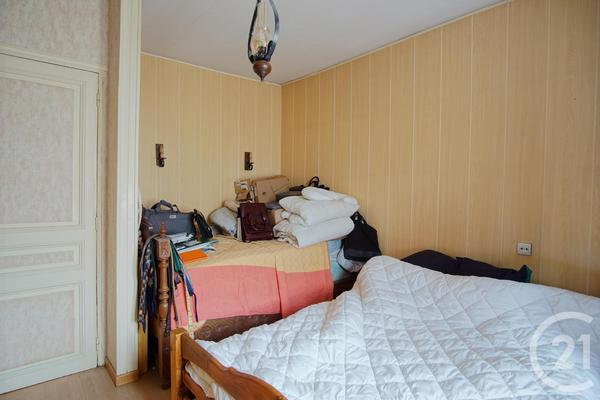
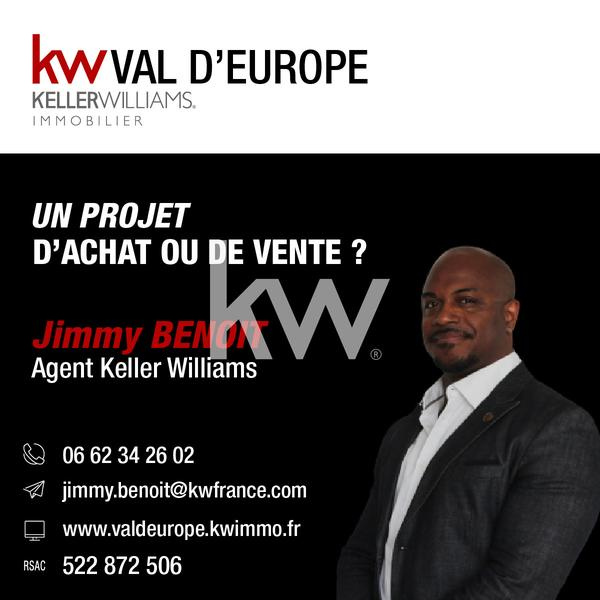
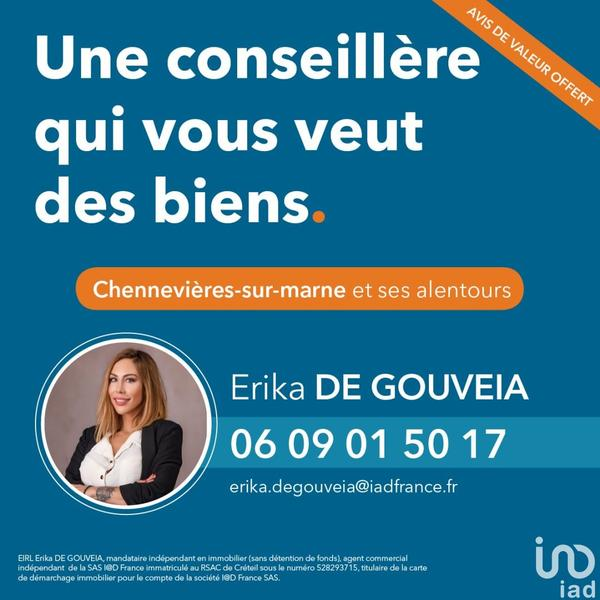
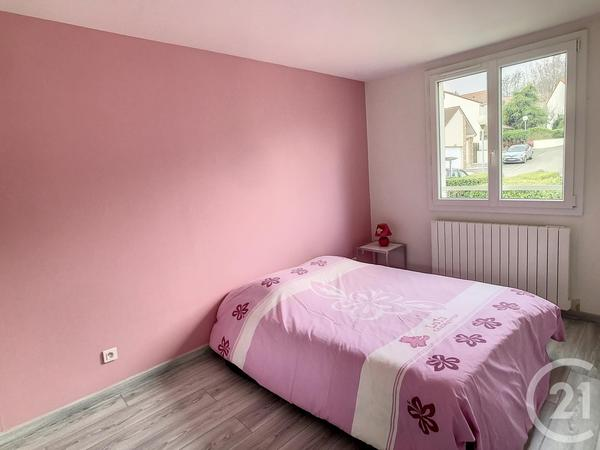
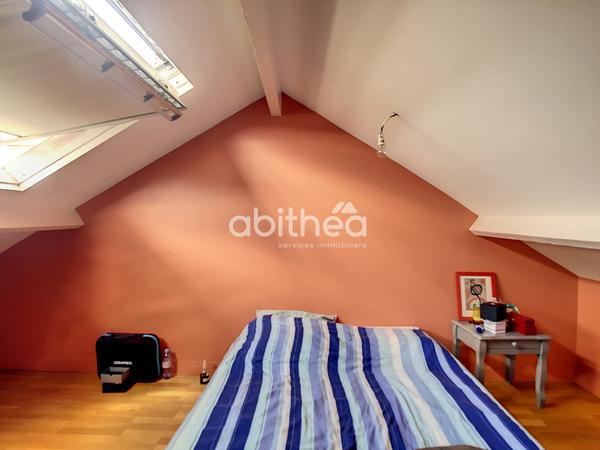
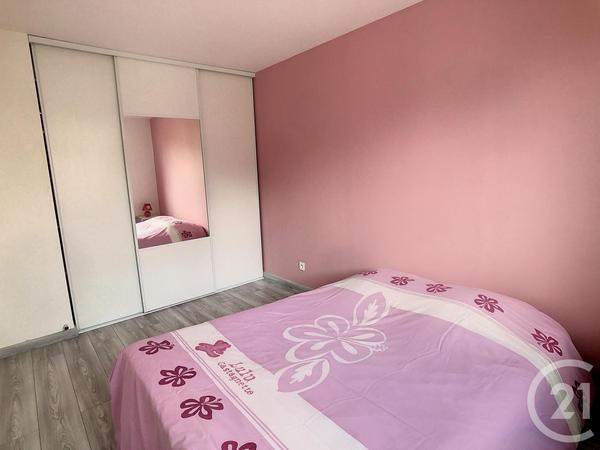
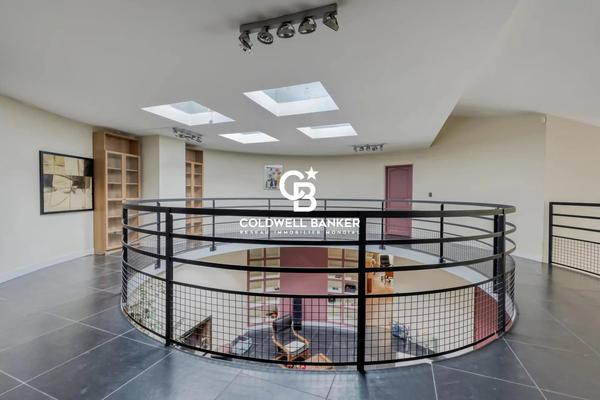
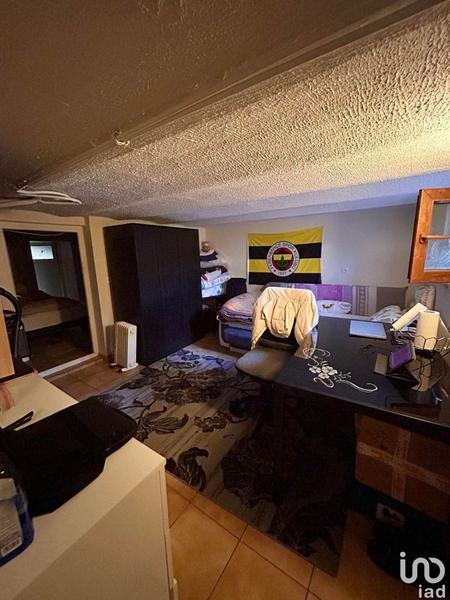
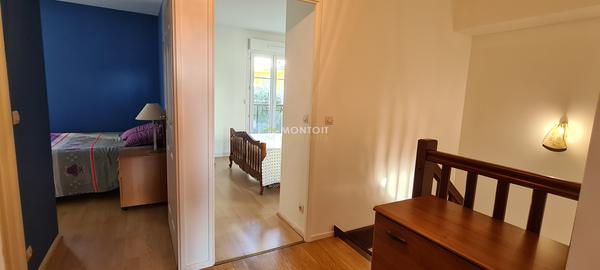
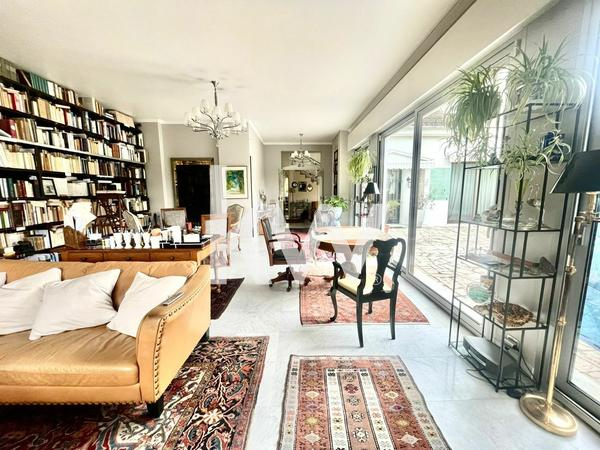
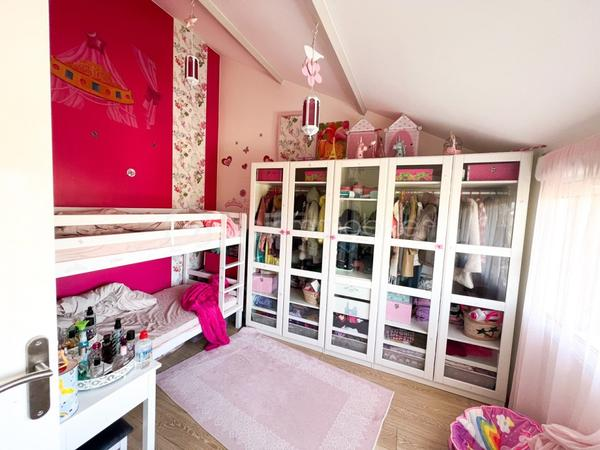
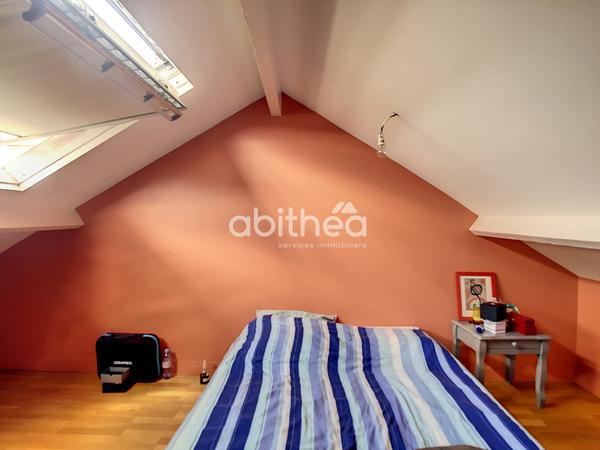
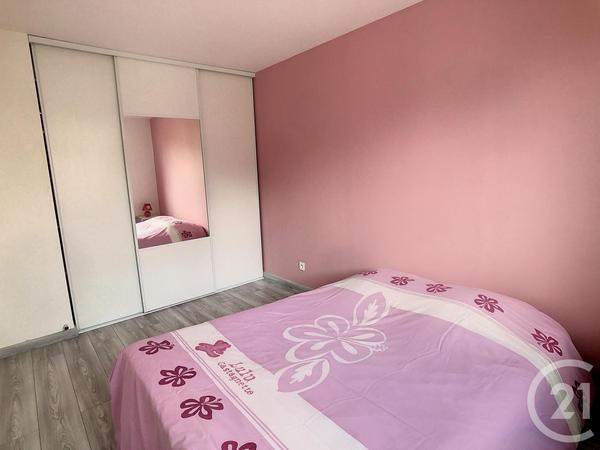
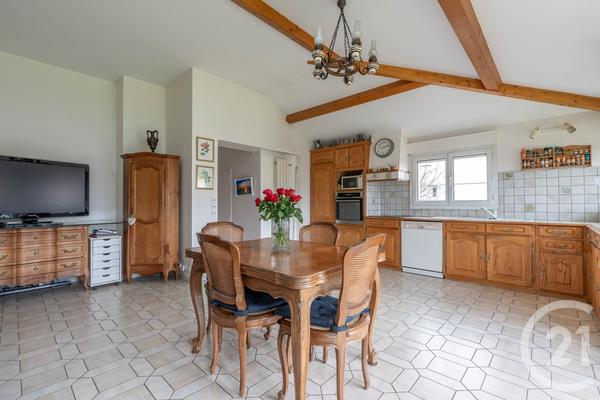
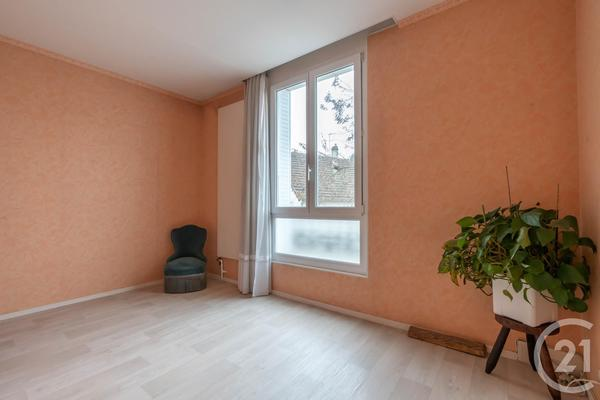
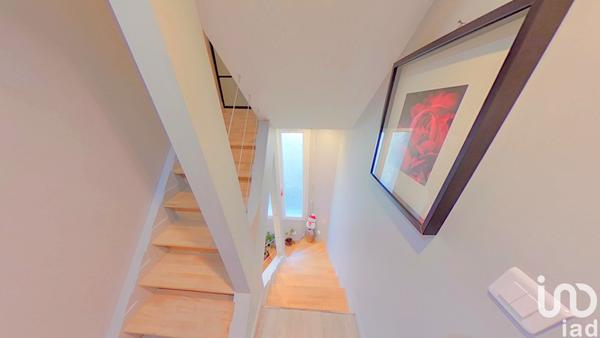
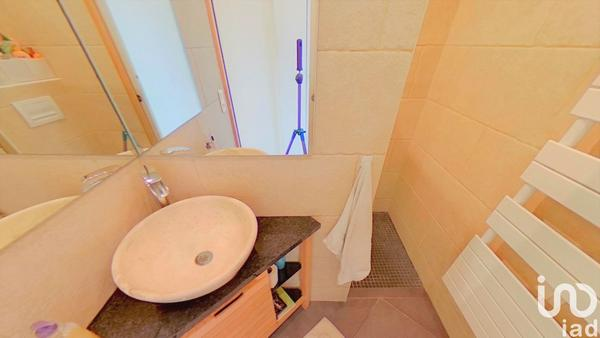

In [ ]:
df_safe_images = add_images_thumbnail_to_df(df_safe[:30], 600)

# displaying PIL.Image objects embedded in dataframe
HTML(df_safe_images[[ 'image', 'Safe_category' , 'safe_value',   'uri'  
                                ]].to_html(formatters={'image': image_formatter}, escape=False))


## Cloud Vision - WEB_DETECTION - WEB_SEARCH
- https://cloud.google.com/vision/docs/detecting-web
4 kinds of results
    - best_guess_labels
    - pages_with_matching_images
    - web_entities
    - visually_similar_images


In [ ]:

ml_annotate_image_result.best_guess_labels as web_best_guess_labels ,  #    WEB_DETECTION   
          ml_annotate_image_result.pages_with_matching_images as web_pages_with_matching_images ,  #    WEB_DETECTION   
          ml_annotate_image_result.web_entities as web_entities ,  #    WEB_DETECTION   
          ml_annotate_image_result.visually_similar_images as web_visually_similar_images ,  #    WEB_DETECTION   


In [1]:
%%bigquery df_web


with web as (
 select uri, string(ml_annotate_image_result.web_detection.best_guess_labels[0].label) as web_best_guess_labels
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  
    where Status =""  
)
select * from web where web_best_guess_labels !=""





UsageError: Cell magic `%%bigquery` not found.


In [4]:
%%bigquery df_web_pages_with_matching_images



with web as (
 select uri, 
 string(pages_with_matching_images_array.page_title) as page_title,
 string(pages_with_matching_images_array.url) as web_url,
 string(full_matching_images_array.url) as web_full_matching_images_url,
 string(partial_matching_images_array.url) as web_partial_matching_images_url,
 
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  
 left join unnest(json_extract_array(ml_annotate_image_result.web_detection.pages_with_matching_images)) as pages_with_matching_images_array
 left join unnest(json_extract_array(pages_with_matching_images_array.full_matching_images)) as full_matching_images_array
 left join unnest(json_extract_array(pages_with_matching_images_array.partial_matching_images)) as partial_matching_images_array
    where Status =""  
#    and uri = "gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-02_product-1303126-3.jpg"
)
#select * from web where web_url !=""



select uri, count(uri) nb from web  group by uri order by nb desc









Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
df_web_pages_with_matching_images.describe()


nb
count    4108.0
mean   3.133398
std    3.553237
min         1.0
25%         1.0
50%         1.0
75%         4.0
max        27.0

In [6]:
df_web_pages_with_matching_images.describe()


nb
count    4108.0
mean   3.133398
std    3.553237
min         1.0
25%         1.0
50%         1.0
75%         4.0
max        27.0

<Axes: >

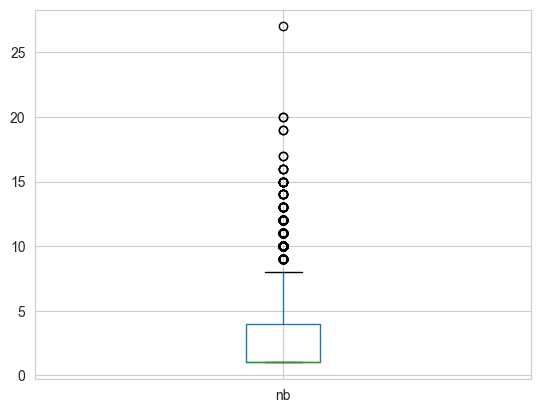

In [24]:
df_web_pages_with_matching_images.boxplot()

/var/tmp/ipykernel_1218896/1434506233.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/var/tmp/ipykernel_1218896/1434506233.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f), size))



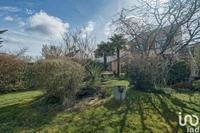
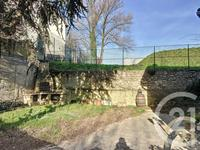
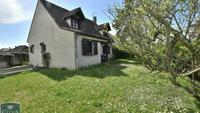
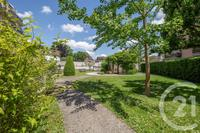
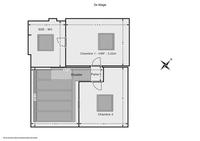
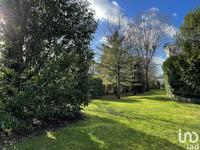
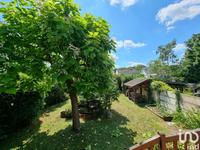
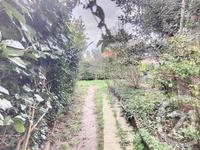
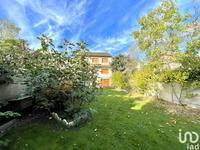
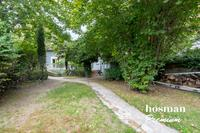

In [ ]:
df_web_images = add_images_thumbnail_to_df(df_web[:10], 200)

# displaying PIL.Image objects embedded in dataframe
HTML(df_web_images[[ 'image', 'web_best_guess_labels' ,    'uri'  
                                ]].to_html(formatters={'image': image_formatter}, escape=False))


In [6]:
%%bigquery 

with web as (
 select uri, string(ml_annotate_image_result.web_detection.best_guess_labels[0].label) as web_best_guess_labels
 FROM `ml-demo-384110.immo_us.temp_image_results_test`  
    where Status =""  
)
select web_best_guess_labels, count(*) nb_Elements from web where web_best_guess_labels !=""
group by web_best_guess_labels order by nb_Elements desc
limit 60
   

Downloading: 100%|██████████| 60/60 [00:02<00:00, 21.13rows/s]


web_best_guess_labels  nb_Elements
0                  real estate          588
1                         room          428
2                      bedroom          395
3                  living room          390
4              interior design          338
5                     bathroom          305
6                        house          254
7                        floor          181
8                      ceiling          131
9                   countertop          126
10                     kitchen          119
11                        tree           58
12                        yard           48
13                        wall           47
14                  floor plan           46
15                architecture           42
16                      stairs           39
17                  vegetation           36
18            residential area           33
19              new collection           30
20                 dining room           25
21                   bed frame           23
22                      estate           21
23      scalia obscene gesture           19
24                     cottage           18
25                        tile           13
26                       table           13
27                         sky           13
28                laundry room           12
29                     diagram            9
30                    backyard            9
31                     walkway            9
32                       villa            9
33                        roof            8
34                    handrail            8
35                       lobby            8
36                     balcony            8
37               swimming pool            6
38                 condominium            6
39              antonin scalia            6
40                       grass            5
41                       water            5
42                      flower            5
43                hosman flyer            4
44                        door            4
45                      nature            4
46                   courtyard            4
47                 daylighting            4
48              nature reserve            4
49       lipton drink positive            4
50                    land lot            4
51                      facade            3
52                  reflection            3
53                       glass            3
54                        loft            3
55                  family car            3
56                      closet            3
57                     curtain            3
58  patati patata na vida real            2
59                    landmark            2

- visually_similar_images

In [ ]:
%%bigquery df_visually_similar

SELECT * from (
SELECT 
  uri
  , json_extract_scalar(l, '$.url') as web_url
    
FROM  `ml-demo-384110.immo_us.temp_image_results_test` 
left join unnest(json_extract_array(ml_annotate_image_result.web_detection.visually_similar_images)) as l
 where uri = "gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-03_product-1320330-15.jpg"
)
where web_url != ""


Query is running:   0%|          |

Downloading:   0%|          |

/var/tmp/ipykernel_1218896/1947110036.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['object_name'] = df.uri.map(
/var/tmp/ipykernel_1218896/1947110036.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df.object_name.map(lambda f: get_thumbnail(download_blob(bucket_name, f), size))
/var/tmp/ipykernel_1218896/1947110036.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c


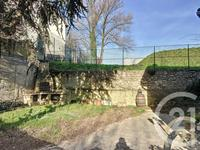
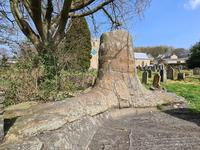
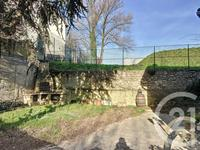
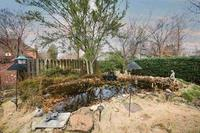
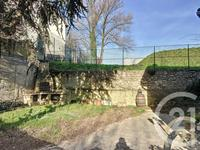
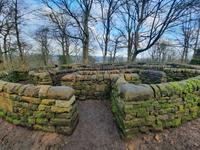
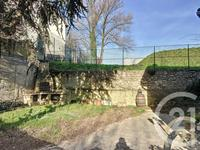
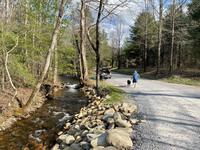
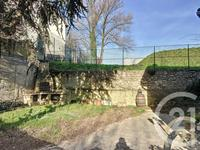
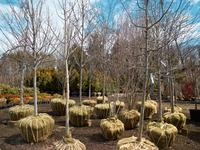
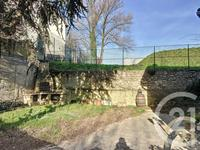
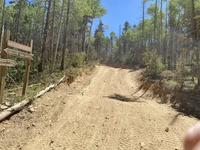
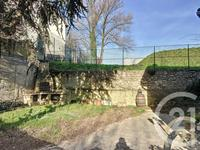
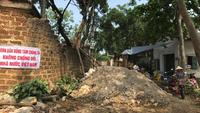
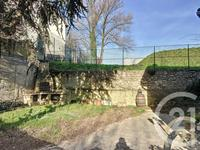
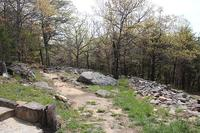
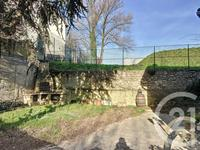
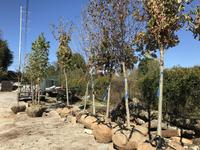
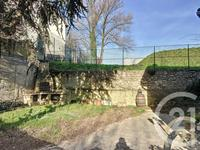
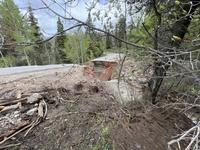
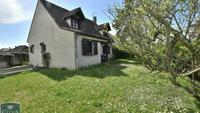
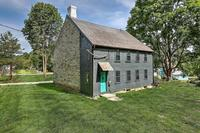
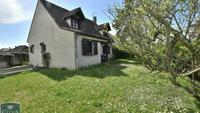
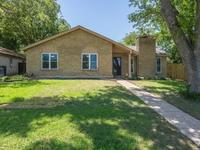
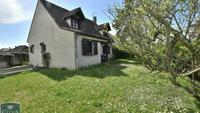
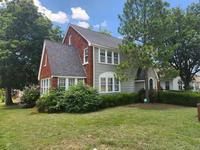
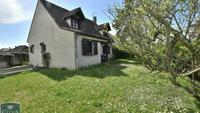
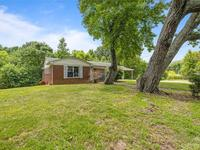
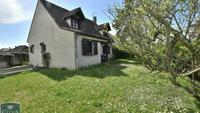
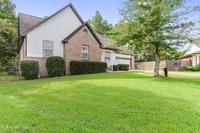
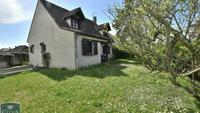
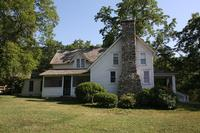
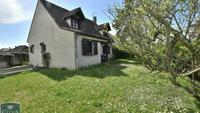
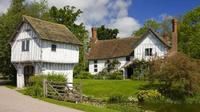
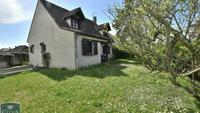
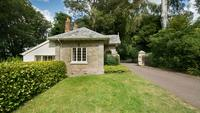
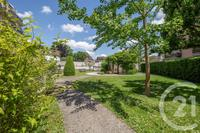
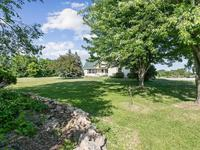
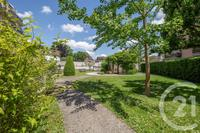
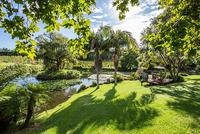

In [ ]:
df_visually_similar_images = add_images_thumbnail_to_df(df_visually_similar[10:30], 200)

df_visually_similar_images = add_web_images_thumbnail_to_df(df_visually_similar_images, 200)

# displaying PIL.Image objects embedded in dataframe
HTML(df_visually_similar_images[[ 'image', 'web_image' ,    'uri'  
                                ]].to_html(formatters={
    'image': image_formatter,
        'web_image': image_formatter,
}, escape=False))


## Cloud Vision - WEB_DETECTION
- FACE_DETECTION
- https://cloud.google.com/vision/docs/face-tutorial

In [35]:
%%bigquery df_face

with face_results as (
      SELECT
      uri,  metadata, 
          float64(face_annotations[0].detection_confidence) AS detection_confidence,
          face_annotations[0] as face_0_annotations , #FACE_DETECTION
          face_annotations as face_annotations ,
          results, 
          error ,  #    ERROR   

 FROM `ml-demo-384110.immo_us.temp_image_results_test2` 
            
)            
  select       Id,    uri, face_0_annotations,
          float64(face_0_annotations.detection_confidence) as detection_confidence,
          float64(face_0_annotations.landmarking_confidence) as landmarking_confidence,
          float64(face_0_annotations.joy_likelihood) as joy,
          float64(face_0_annotations.sorrow_likelihood) as sorrow,
          float64(face_0_annotations.anger_likelihood) as anger,
          float64(face_0_annotations.surprise_likelihood) as surprise,
          float64(face_0_annotations.under_exposed_likelihood) as under_exposed,
          float64(face_0_annotations.blurred_likelihood) as blurred,
          float64(face_0_annotations.headwear_likelihood) as headwear,

from (
SELECT
  r.*, 
  value as id
FROM face_results AS r  CROSS JOIN UNNEST(r.metadata) AS metadata 
)
  where detection_confidence > 0
            order by  detection_confidence  desc            ;


Downloading: 100%|██████████| 51/51 [00:02<00:00, 19.46rows/s]


In [45]:
%%bigquery df_face

with face_results as (
      SELECT
      uri,  metadata, 
          float64(face_annotations[0].detection_confidence) AS detection_confidence,
          face_annotations[0] as face_0_annotations , #FACE_DETECTION
          face_annotations as face_annotations 
 FROM `ml-demo-384110.immo_us.temp_image_results_test2` 
                      where Status = ""  
)            
  select       Id,    uri, face_0_annotations, face_0_annotations.bounding_poly,
          ML.QUANTILE_BUCKETIZE(float64(face_0_annotations.detection_confidence), 3) OVER() as detection_confidence_bucket,
          float64(face_0_annotations.detection_confidence) as detection_confidence,
          float64(face_0_annotations.landmarking_confidence) as landmarking_confidence,
          float64(face_0_annotations.joy_likelihood) as joy,
          float64(face_0_annotations.sorrow_likelihood) as sorrow,
          float64(face_0_annotations.anger_likelihood) as anger,
          float64(face_0_annotations.surprise_likelihood) as surprise,
          float64(face_0_annotations.under_exposed_likelihood) as under_exposed,
          float64(face_0_annotations.blurred_likelihood) as blurred,
          float64(face_0_annotations.headwear_likelihood) as headwear,

from (
SELECT
  r.*, 
  value as id
FROM face_results AS r  CROSS JOIN UNNEST(r.metadata) AS metadata 
)
  where detection_confidence > 0.2
  order by
            detection_confidence  desc
            ;




Downloading: 100%|██████████| 51/51 [00:02<00:00, 19.32rows/s]


In [46]:
df_face.head(10)


Id  \
0                hektor-A93035-280   
1  keller-williams-1-34_1_36-79539   
2               iad-france-1351179   
3               iad-france-1303126   
4                hektor-A93035-280   
5                hektor-A93035-280   
6                hektor-A93035-280   
7                hektor-A93035-280   
8                hektor-A93035-280   
9                hektor-A93035-280   

                                                 uri  \
0  gs://ml-demo-384110-bucket/dataset/immo/images...   
1  gs://ml-demo-384110-bucket/dataset/immo/images...   
2  gs://ml-demo-384110-bucket/dataset/immo/images...   
3  gs://ml-demo-384110-bucket/dataset/immo/images...   
4  gs://ml-demo-384110-bucket/dataset/immo/images...   
5  gs://ml-demo-384110-bucket/dataset/immo/images...   
6  gs://ml-demo-384110-bucket/dataset/immo/images...   
7  gs://ml-demo-384110-bucket/dataset/immo/images...   
8  gs://ml-demo-384110-bucket/dataset/immo/images...   
9  gs://ml-demo-384110-bucket/dataset/immo/images...   

                                  face_0_annotations  \
0  {"anger_likelihood":1,"blurred_likelihood":1,"...   
1  {"anger_likelihood":1,"blurred_likelihood":1,"...   
2  {"anger_likelihood":1,"blurred_likelihood":1,"...   
3  {"anger_likelihood":1,"blurred_likelihood":1,"...   
4  {"anger_likelihood":1,"blurred_likelihood":1,"...   
5  {"anger_likelihood":1,"blurred_likelihood":1,"...   
6  {"anger_likelihood":1,"blurred_likelihood":1,"...   
7  {"anger_likelihood":1,"blurred_likelihood":1,"...   
8  {"anger_likelihood":1,"blurred_likelihood":1,"...   
9  {"anger_likelihood":1,"blurred_likelihood":1,"...   

                                       bounding_poly  \
0  {"vertices":[{"x":566,"y":196},{"x":882,"y":19...   
1  {"vertices":[{"x":806,"y":480},{"x":1039,"y":4...   
2  {"vertices":[{"x":171,"y":623},{"x":278,"y":62...   
3  {"vertices":[{"x":82,"y":19},{"x":409,"y":19},...   
4  {"vertices":[{"x":79,"y":623},{"x":225,"y":623...   
5  {"vertices":[{"x":80,"y":624},{"x":224,"y":624...   
6  {"vertices":[{"x":80,"y":624},{"x":224,"y":624...   
7  {"vertices":[{"x":79,"y":622},{"x":225,"y":622...   
8  {"vertices":[{"x":79,"y":622},{"x":225,"y":622...   
9  {"vertices":[{"x":79,"y":624},{"x":224,"y":624...   

  detection_confidence_bucket  detection_confidence  landmarking_confidence  \
0                       bin_3              0.992188                0.654650   
1                       bin_3              0.976562                0.620463   
2                       bin_3              0.972656                0.561330   
3                       bin_3              0.968750                0.463426   
4                       bin_3              0.957031                0.643728   
5                       bin_3              0.945312                0.639548   
6                       bin_3              0.925781                0.678580   
7                       bin_3              0.921875                0.686503   
8                       bin_3              0.914062                0.656957   
9                       bin_3              0.910156                0.649607   

   joy  sorrow  anger  surprise  under_exposed  blurred  headwear  
0  5.0     1.0    1.0       1.0            1.0      1.0       1.0  
1  5.0     1.0    1.0       1.0            1.0      1.0       1.0  
2  5.0     1.0    1.0       1.0            1.0      1.0       1.0  
3  5.0     1.0    1.0       1.0            1.0      1.0       1.0  
4  5.0     1.0    1.0       1.0            1.0      1.0       1.0  
5  5.0     1.0    1.0       1.0            1.0      1.0       1.0  
6  5.0     1.0    1.0       1.0            1.0      1.0       1.0  
7  5.0     1.0    1.0       1.0            1.0      1.0       1.0  
8  5.0     1.0    1.0       1.0            1.0      1.0       1.0  
9  5.0     1.0    1.0       1.0            1.0      1.0       1.0


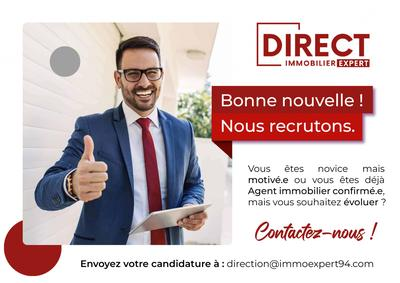
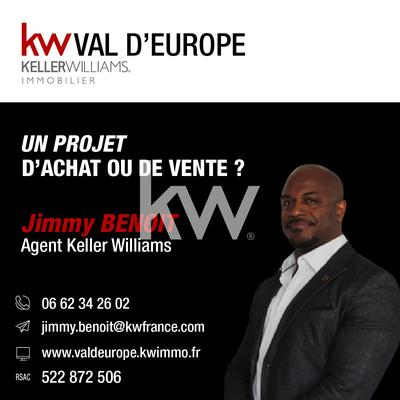
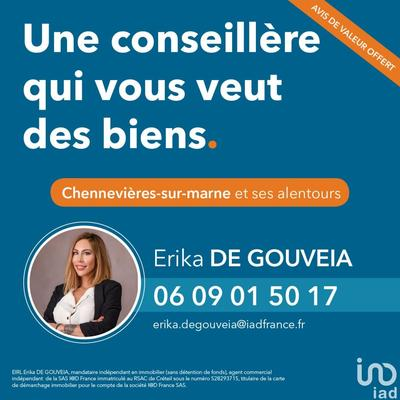
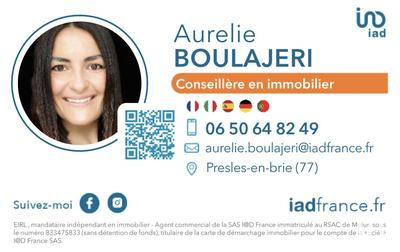
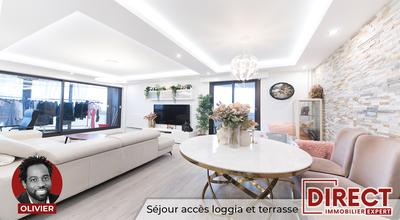
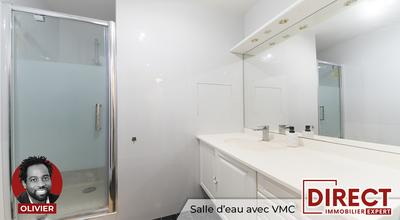
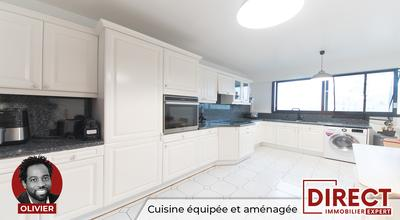
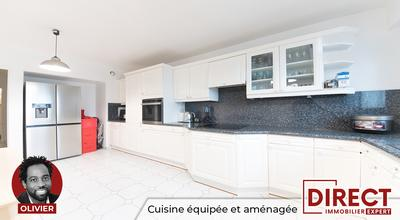
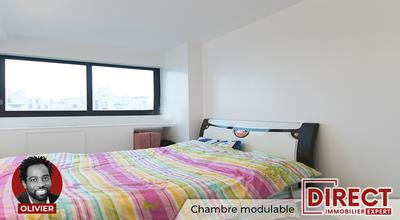
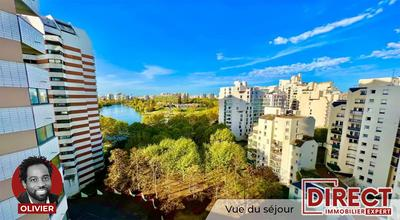
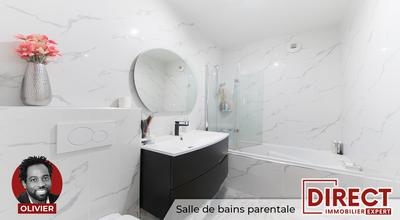
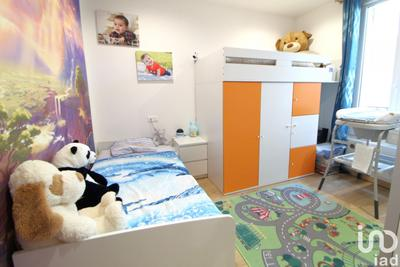
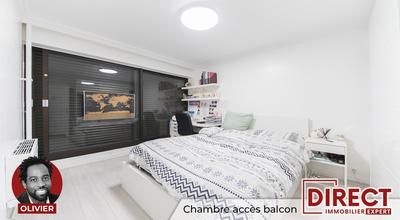
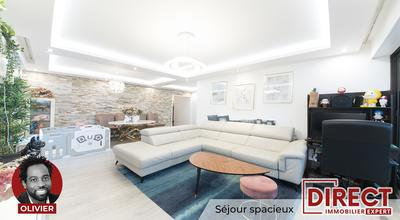
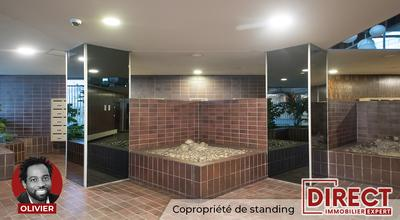
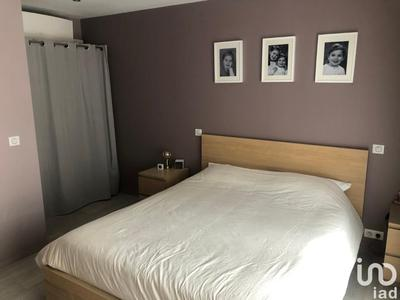
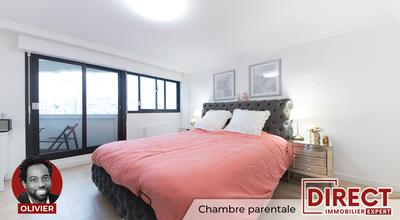
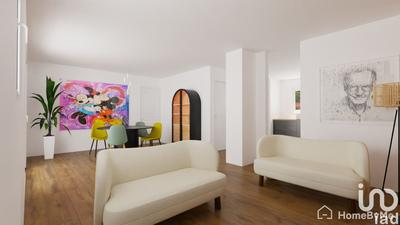
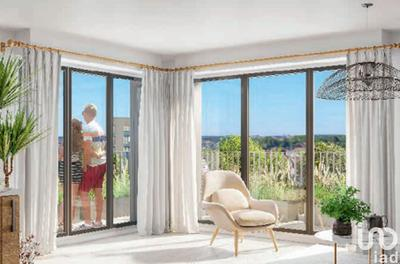
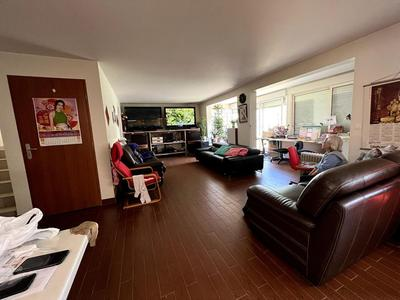
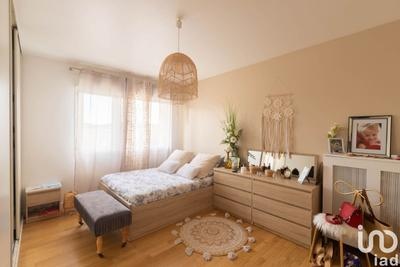
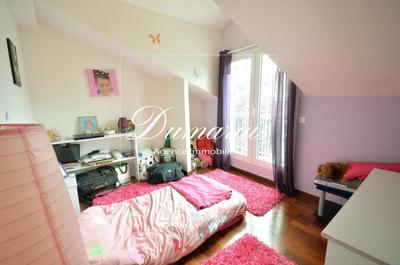
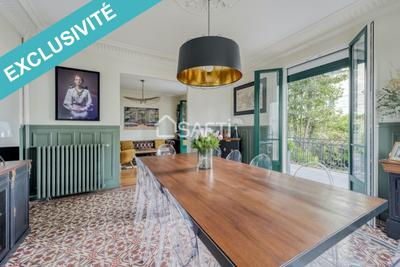
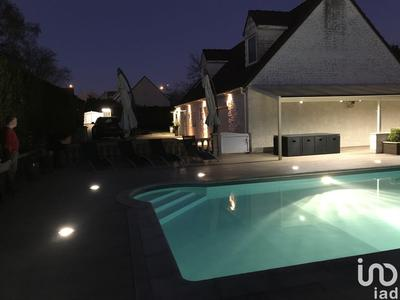
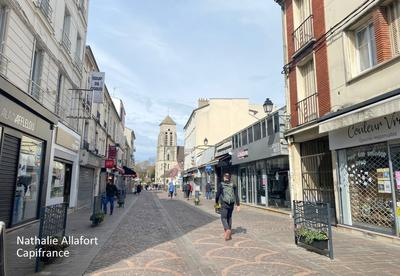
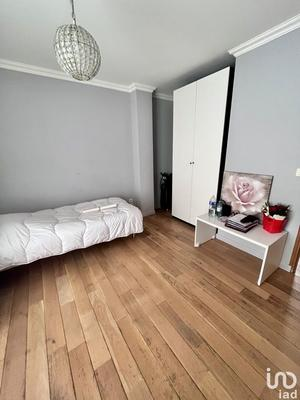
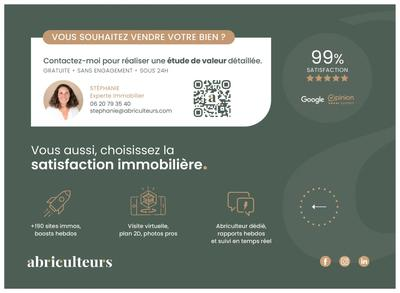
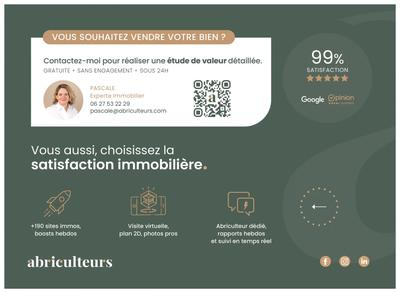
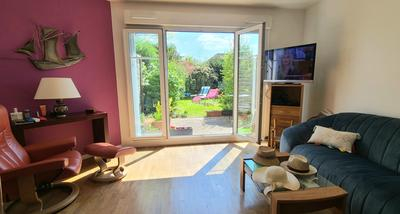
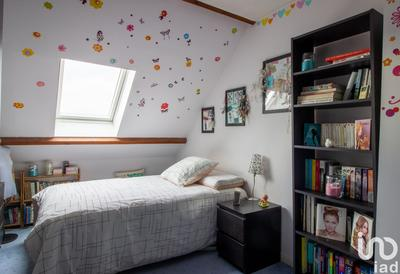
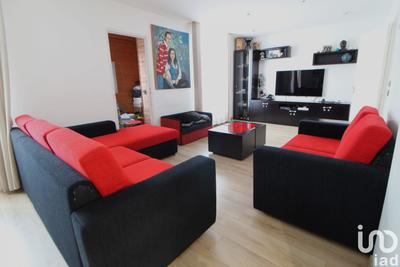
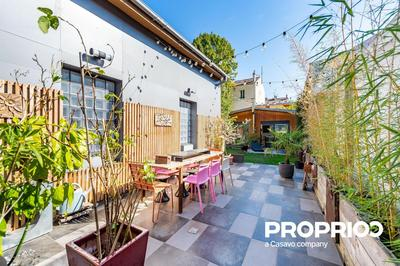
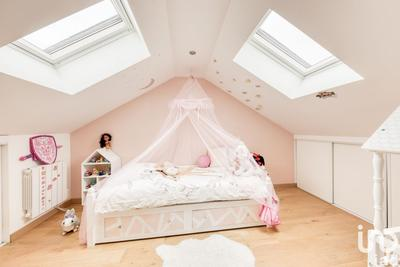
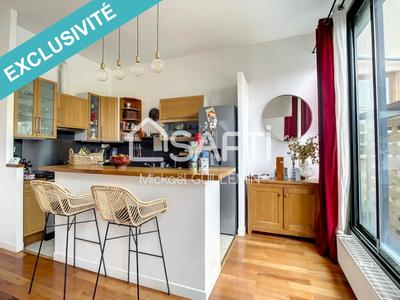
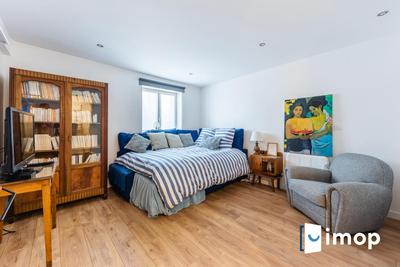
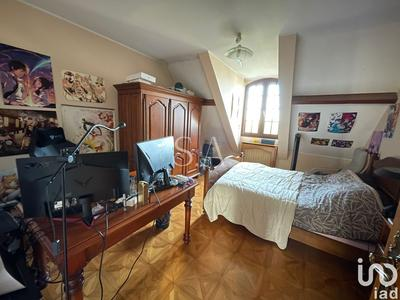
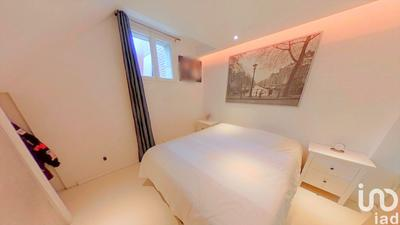
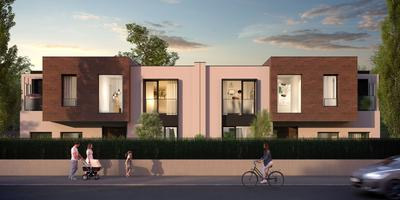
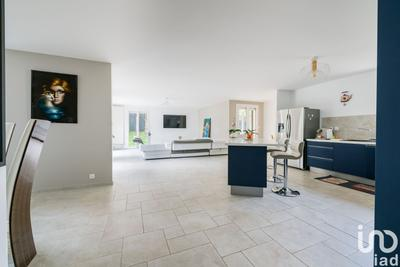
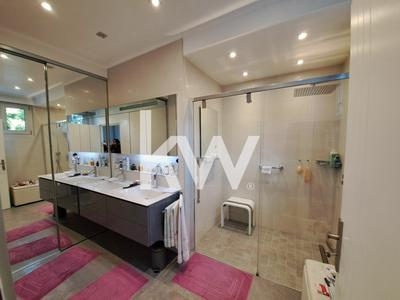
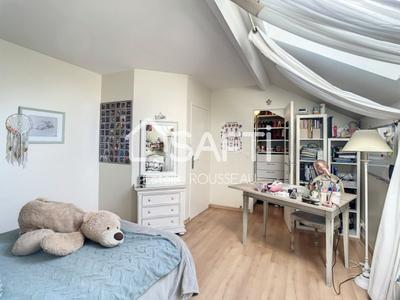
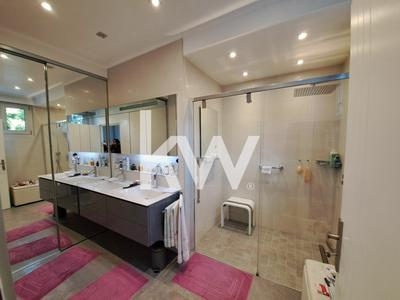
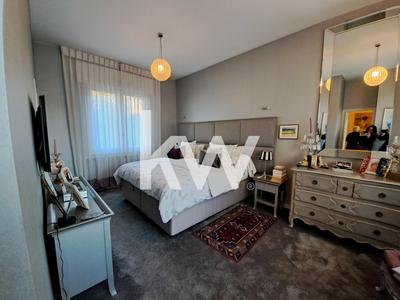
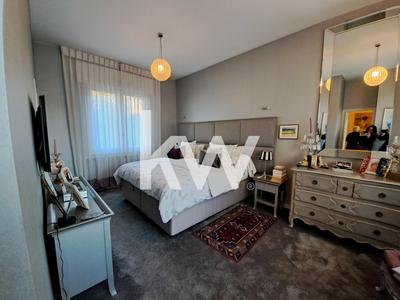
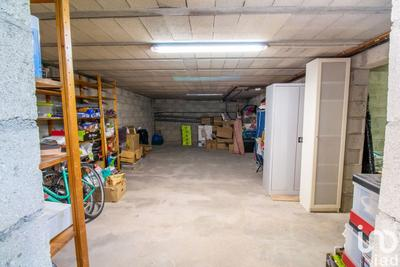
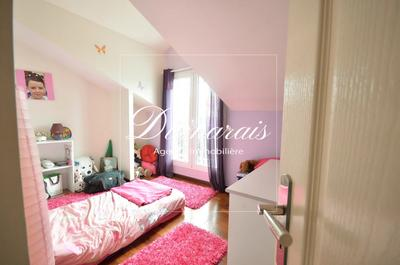
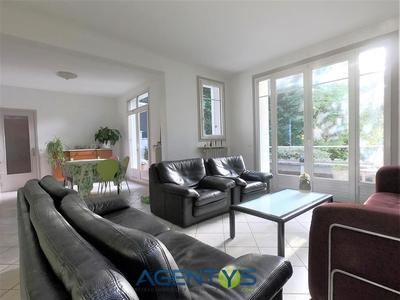
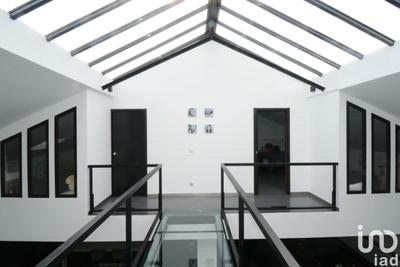
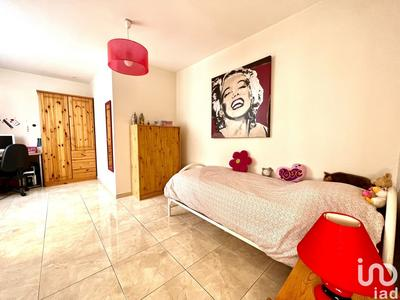
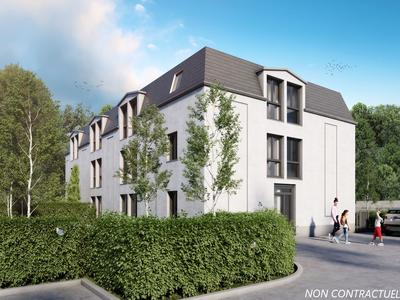
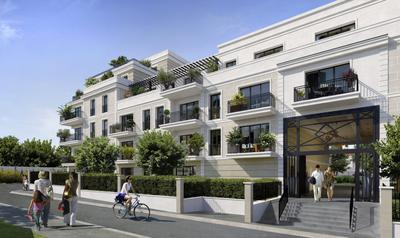

In [37]:
df_face_thumbnail = add_images_thumbnail_to_df(df_face, 400)
# displaying PIL.Image objects embedded in dataframe
HTML(df_face_thumbnail[[ 'image', 'detection_confidence', 
                        'landmarking_confidence', 
                        'joy', 'sorrow', 'anger', 'surprise', 'under_exposed', 'blurred', 'headwear' ]]
                        .to_html(formatters={'image': image_formatter}, escape=False))

In [ ]:

df_face_thumbnail_poly = add_images_thumbnail_withpoly_to_df(df_face_thumbnail, 400)

# displaying PIL.Image objects embedded in dataframe
HTML(df_face_thumbnail_poly[[ 'image_full','image', 'joy', 'blurred', 'landmarking_confidence', 'detection_confidence' ]]
     .to_html(formatters={'image_full': image_formatter,
                          #'image': image_formatter
                          }, escape=False))


# LLM - Visual captioning

## Imagen imagetext
- https://cloud.google.com/vertex-ai/docs/generative-ai/image/image-captioning

In [1]:
import base64
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np
import requests
from io import BytesIO
from IPython.display import Image
from PIL import Image
from IPython import display
from IPython.display import Image, display

from google.cloud import storage

In [4]:
# @title Parameters
LOCATION = "us-central1" #@param {type:"string"}
#PROJECT_NUMBER = 
#PROJECT_ID = "" #@param {type:"string"}

PROJECT_ID = !gcloud projects list --filter="$(gcloud config get-value project)" --format="value(PROJECT_ID)"

if len(PROJECT_ID) > 1:
    PROJECT_ID = PROJECT_ID[1]
else:
    PROJECT_ID = PROJECT_ID[0]
print(PROJECT_ID)

PROJECT_NUMBER = !gcloud projects list --filter="$(gcloud config get-value project)" --format="value(PROJECT_NUMBER)"
if len(PROJECT_NUMBER) > 1:
    PROJECT_NUMBER = PROJECT_NUMBER[1]
else:
    PROJECT_NUMBER = PROJECT_NUMBER[0]

print(PROJECT_NUMBER)

TOKEN_ENDPOINT_URI = 'https://www.googleapis.com/oauth2/v3/tokeninfo?access_token='

IMAGEGEN_MODEL = "imagegeneration@002" #models available: imagegeneration@001 and imagegeneration@002
ENDPOINT_URL = f'projects/{PROJECT_NUMBER}/locations/{LOCATION}/publishers/google/models/{IMAGEGEN_MODEL}'

IMAGE_TEXT_MODEL = "imagetext"
IMAGEN_ENDPOINT_URL = f'projects/{PROJECT_NUMBER}/locations/{LOCATION}/publishers/google/models/{IMAGE_TEXT_MODEL}'


ml-demo-384110
1008225662928


In [5]:
"""
Get access token
"""
gcloud_token = !gcloud auth print-access-token
gcloud_tokeninfo = requests.get(TOKEN_ENDPOINT_URI + gcloud_token[0]).json()
print("Access Token is generated for ", gcloud_tokeninfo['email'])
ACCESS_TOKEN = gcloud_token[0]

#print(headers)

Access Token is generated for  1008225662928-compute@developer.gserviceaccount.com


In [6]:

"""
encoding = base64.b64encode(open(img_path, 'rb').read())
The following function takes an image file path and returns a base64 encoded image as string
"""
def encode_image(img_path):
    with open(img_path, "rb") as img_file:
        encoded_str = base64.b64encode(img_file.read())
    return encoded_str

"""
decoding = base64.b64decode(encoding)
The following function takes a base64 encoded image and returns a PIL image
"""
def decode_image(img_base64):
    img_bytes = base64.b64decode(img_base64)
    return Image.open(BytesIO(img_bytes))

"""
display_image = decode_image(encoding)
The following function takes a PIL image and displays it
"""
def display_image(img):
    display.display(img)
    display.clear_output(wait=True)

"""
Read files from GCS bucket for a given path.
"""
def read_file_from_gcs(bucket_name, file_path):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(file_path)
    return blob

"""
Read b64 encoded file from GCS bucket
"""
def read_b64_from_gcs(bucket_name, file_path):
    blob = read_file_from_gcs(bucket_name, file_path)    
    return base64.b64encode(blob.download_as_bytes())

"""
Read Json Config file from GCS bucket
"""
def read_json_from_gcs(bucket_name, file_path):
    blob = read_file_from_gcs(bucket_name, file_path)
    str_json = blob.download_as_string()
    print(str_json)
    json_config = json.loads(str_json)
    return json_config



In [7]:
# @title Setup

import json
import requests
import time

from IPython import display
import base64

# @title image Generation Model
def generate_image(
    prompt: str,
    sampleImageSize: str,
    sampleCount: int,
    seed: int
    ):
    headers = {
      'Authorization': f'Bearer {ACCESS_TOKEN}',
      'Content-Type': 'application/json; charset=UTF-8'
    }
    data = {"instances": [{"prompt": prompt}],
            "parameters": {"sampleImageSize": sampleImageSize,"sampleCount": sampleCount, "seed": seed}}

    response = requests.post(f'https://{LOCATION}-aiplatform.googleapis.com/v1/{ENDPOINT_URL}:predict', data=json.dumps(data), headers=headers)
    return response

###
# Visual Question Answering (VQA) to get image information
##
def visual_qa(
    prompt: str,
    sampleCount: int,
    encoded_str: str
    ):
    
    headers = {
      'Authorization': f'Bearer {ACCESS_TOKEN}',
      'Content-Type': 'application/json; charset=UTF-8'
    }
    
    data = {
        "instances": [
            {
            "prompt": prompt,
            "image": {
                "bytesBase64Encoded": encoded_str
            }
            }
        ],
        "parameters": {
            "sampleCount": sampleCount
            }
        }

    response = requests.post(f'https://{LOCATION}-aiplatform.googleapis.com/v1/{IMAGEN_ENDPOINT_URL}:predict', 
        data=json.dumps(data), headers=headers)

    return response

###
#Visual captioning is available in the following languages:
# English (en)
# French (fr)
# German (de)
# Italian (it)
# Spanish (es)
##
def visual_captioning(
    sampleCount: int,
    language: str, 
    # English (en), French (fr), German (de), Italian (it), Spanish (es)
    encoded_str: str
    ):
    
    headers = {
      'Authorization': f'Bearer {ACCESS_TOKEN}',
      'Content-Type': 'application/json; charset=UTF-8'
    }
    
    data = {
        "instances": [
            {
            "image": {
                "bytesBase64Encoded": encoded_str
                }
            }
        ],
        "parameters": {
            "sampleCount": sampleCount,
            "language": language
            }
        }

    response = requests.post(f'https://{LOCATION}-aiplatform.googleapis.com/v1/{IMAGEN_ENDPOINT_URL}:predict', 
        data=json.dumps(data), headers=headers)

    return response

def display_images(
    predictions: str,
    sampleImageSize: str,
    scale: float,
    ):
    width = int(sampleImageSize) * scale
    height = int(sampleImageSize) * scale
    for index, key in enumerate(predictions):
        display.display(display.Image(base64.b64decode(predictions[index]['bytesBase64Encoded']), width = width, height = height))
        print()

def print_text_response(response):
    if response.status_code == 200:
        json_response = json.loads(response.text)
        #print(json_response)
        predictions = json_response['predictions']
        print(predictions)
        return predictions
    print(response)
    return ""


In [8]:
base_image_path = "dataset/immo/images/_photos_realestate_2023-02_product-1303126-3.jpg"


bucket = "ml-demo-384110-bucket"
#str_img = read_b64_from_gcs(bucket, base_image_path)

print_text_response(    visual_captioning( 3, "en",str(read_b64_from_gcs(bucket, base_image_path), 'UTF-8')))
print_text_response(    visual_captioning( 3, "fr",str(read_b64_from_gcs(bucket, base_image_path), 'UTF-8')))



['a house with a lot of potted plants in front of it', 'a picture of a house with the letters iad on the bottom', 'a house with a lot of potted plants in front of it and a sign that says iad']
["l' arrière d' une maison avec des pots de fleurs à l' extérieur", "l' arrière d' une maison avec des pots de fleurs et des arbres", "l' arrière d' une maison avec des pots de fleurs à côté"]


["l' arrière d' une maison avec des pots de fleurs à l' extérieur",
 "l' arrière d' une maison avec des pots de fleurs et des arbres",
 "l' arrière d' une maison avec des pots de fleurs à côté"]

In [9]:

def add_images_caption_to_df(df, language = "en", bucket_name = "ml-demo-384110-bucket"):

    df[f'caption_{language}' ] = df.uri.map(lambda uri_name:                                    
                                   visual_captioning( 3, language,str(read_b64_from_gcs(bucket, uri_name.replace(f"gs://{bucket_name}/", "")), 'UTF-8'))
                                  )
    
    return df


In [ ]:
%%bigquery


WITH text_annotation AS (
SELECT uri,       
split(string(full_text_annotation.text), "\n") as text_array,
    string(full_text_annotation.text) as full_text,
#full_text_annotation.pages[0] as pages,
full_text_annotation.pages[0].height,full_text_annotation.pages[0].width,
 
full_text_annotation.pages[0].property.detected_languages[0].language_code as language_code,
full_text_annotation.pages[0].property.detected_languages[0].confidence  as language_confidence

 FROM `ml-demo-384110.immo_us.temp_image_results_test`  
    where Status =""  
# and uri = "gs://ml-demo-384110-bucket/dataset/immo/images/_imagesBien_s3_202_224_c21_202_224_23721_1_F392764F-0924-4270-AD19-1C836FC791B6.jpg"
    #"gs://ml-demo-384110-bucket/dataset/immo/images/_photos_realestate_2023-05_product-1360245-7.jpg"

) 
SELECT uri, text_fragment, full_text,	height,	width #,	language_code,	language_confidence	
FROM text_annotation
CROSS JOIN UNNEST(text_annotation.text_array) AS text_fragment
    where full_text = "TERRASSE\n404\nES TRES CE\nschchenwe\nCHAMBRE 3\nOR\nporte-cers\n247\n201\nCHAMBRE 4\n409\nSEJOUR\nCasay\nBrise-fall\nWC\nCHAMBRE 2\nCUISINE\nCamis\n143\nBALCON\nELEMENTARE DE LA REALISATION TANTE\nRGT\nLV\nCUI\nENTREE\nN12\nSDB\nOGT\n310\nCHAMBRE 1\nQUE CONCERNE LES DONES QUE LEQUEM LES SURFACES LES HAUTEURS SOUSPLAGGELES HAUTELAS DE\nPLUMALES DES EQUIPEMENTS STRESE CAT PAS TOUS RES OU LEONE ROCATE LE ORE LA TALLS T\nPIXEL\nENTREE\nSEJOUR\nCUISINE\nHALL CELADON\nAppartement de 5 pièces\nn° 142 au 4ème étage\nCHAMBRE 1\nCHAMBRE 2\nRUE VOLTAIRE\n94400-VITRY SUR SEINE\nCHAMBRE 3\nCHAMBRE 4\nSALLE DE BAINS\nSALLE DEAU\nWC\nRANGEMENT\nDEGAGEMENT\nAV\nVR\nrue Volare\nSURFACE TOTALE HABITABLE\nTERRASSE\nBALCON\nSURFACE TOTALE PRIVATIVE\nLEGENDE\nEMPLACE\nLL LAUN\nLV\nTRI\nEchele\nMENTS DE\nPLAFONG SOP\nTE\nGC\n7.00\n24.08\n634\n12.40\n9.00\n10.50\n9.60\nAM\n3.04\nCOGEDIM\n1.16\n16\n65₂\n98,1\n603\nCURSURON\n100,1\n1\nEYE\nes"




Query is running:   0%|          |

Downloading:   0%|          |

uri  \
0   gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   
1   gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   
2   gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   
3   gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   
4   gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   
..                                                                                                               ...   
82  gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   
83  gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   
84  gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   
85  gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   
86  gs://ml-demo-384110-bucket/dataset/immo/images/_biens_8_64_864223_b060c7306641bc8e48e69eb52f264480b6d673cf_g.jpg   

   text_fragment  \
0   TERRASSE       
1   404            
2   ES TRES CE     
3   schchenwe      
4   CHAMBRE 3      
..        ...      
82  CURSURON       
83  100,1          
84  1              
85  EYE            
86  es             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               full_text  \
0   TERRASSE\n404\nES TRES CE\nschchenwe\nCHAMBRE 3\nOR\nporte-cers\n247\n201\nCHAMBRE 4\n409\nSEJOUR\nCasay\nBrise-fall\nWC\nCHAMBRE 2\nCUISINE\nCamis\n143\nBALCON\nELEMENTARE DE LA REALISATION TANTE\nRGT\nLV\nCUI\nENTREE\nN12\nSDB\nOGT\n310\nCHAMBRE 1\nQUE CONCERNE LES DONES QUE LEQUEM LES SURFACES LES HAUTEURS SOUSPLAGGELES HAUTELAS DE\nPLUMALES DES EQUIPEMENTS STRESE CAT PAS TOUS RES OU LEONE ROCATE LE ORE LA TALLS T\nPIXEL\nENTREE\nSEJOUR\nCUISINE\nHALL CELADON\nAppartement de 5 pièces\nn° 142 au 4ème étage\nCHAMBRE 1\nCHAMBRE 2\nRUE VOLTAIRE\n94400-VITRY SUR SEINE\nCHAMBRE 3\nCHAMBRE 4\nSALLE DE BAINS\nSALLE DEAU\nWC\nRANGEMENT\nDEGAGEMENT\nAV\nVR\nrue Volare\nSURFACE TOTALE HABITABLE\nTERRASSE\nBALCON\nSURFACE TOTALE PRIVATIVE\nLEGENDE\nEMPLACE\nLL LAUN\nLV\nTRI\nEchele\nMENTS DE\nPLAFONG SOP\nTE\nGC\n7.00\n24.08\n634\n12.40\n9.00\n10.50\n9.60\nAM\n3.04\nCOGEDIM\n1.16\n16\n65₂\n98,1\n603\nCURSURON\n100,1\n1\nEYE\nes   
1   TERRASSE\n404\nES TRES CE\nschchenwe\nCHAMBRE 3\nOR\nporte-cers\n247\n201\nCHAMBRE 4\n409\nSEJOUR\nCasay\nBrise-fall\nWC\nCHAMBRE 2\nCUISINE\nCamis\n143\nBALCON\nELEMENTARE DE LA REALISATION TANTE\nRGT\nLV\nCUI\nENTREE\nN12\nSDB\nOGT\n310\nCHAMBRE 1\nQUE CONCERNE LES DONES QUE LEQUEM LES SURFACES LES HAUTEURS SOUSPLAGGELES HAUTELAS DE\nPLUMALES DES EQUIPEMENTS STRESE CAT PAS TOUS RES OU LEONE ROCATE LE ORE LA TALLS T\nPIXEL\nENTREE\nSEJOUR\nCUISINE\nHALL CELADON\nAppartement de 5 pièces\nn° 142 au 4ème étage\nCHAMBRE 1\nCHAMBRE 2\nRUE VOLTAI

In [ ]:
df_automl.to_csv('dataset_automl_dataset.csv', index=False, sep=",", header=False)
! gsutil cp 'dataset_automl_dataset.csv' 'gs://ml-demo-us-central1/dataset_automl_dataset_4108.csv'

Copying file://dataset_automl_dataset.csv [Content-Type=text/csv]...
- [1 files][434.8 KiB/434.8 KiB]                                                
Operation completed over 1 objects/434.8 KiB.                                    


In [ ]:
df = df.explode("ml_annotate_image_result")


In [ ]:
df

Empty DataFrame
Columns: []
Index: []

In [ ]:
#          `{PROJECT_ID}.{DATASET_ID}.temp_image_results_all` AS


try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """

SELECT * from 
`{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}` ;

      """.format(
        PROJECT_ID = PROJECT_ID,
        DATASET_ID = DATASET_ID, 
        OBJECT_TABLE_NAME="temp_image_results_test", 
    )

    print(sql)
    df = client.query(sql).to_dataframe()
    
    

except Exception as e:
    raise Exception(str(e))    
    



SELECT * from 
`ml-demo-384110.immo_us_enriched.temp_image_results_test` ;

      


In [ ]:
df

text_content                               full_text_annotation  \
0  $22\nW\ncimm  {"pages":[{"blocks":[{"block_type":1,"bounding...   

                                   label_annotations  \
0  [{"description":"Sky","mid":"/m/01bqvp","score...   

                                    logo_annotations safe_search_detection  \
0  [{"bounding_poly":{"vertices":[{"x":1466,"y":5...                  None   

  landmark_annotations web_best_guess_labels web_pages_with_matching_images  \
0                 None                  None                           None   

  web_entities web_visually_similar_images  ... Status  \
0         None                        None  ...          

                            ml_annotate_image_result ml_annotate_image_status  \
0  {"full_text_annotation":{"pages":[{"blocks":[{...                            

                                                 uri        generation  \
0  gs://ml-demo-us-central1/automl_dataset_immo/r...  1689940318624781   

   content_type    size                          md5_hash  \
0    image/jpeg  618789  3696994d21977f479f5e72b5a0aa5b6e   

                           updated metadata  
0 2023-07-21 11:51:58.627000+00:00       []  

[1 rows x 21 columns]

In [ ]:
#use translate ai to translate text
try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """
        SELECT text_content, language_code,
          ml_translate_result.translations[0].translated_text
        FROM
          ML.TRANSLATE( MODEL `{}.{}.{}`, TABLE `{}.{}.temp_detect_language_results`, STRUCT("translate_text" as translate_mode, "en" as target_language_code));
        """.format( PROJECT_ID,DATASET_ID, TRANSLATE_MODEL_NAME, PROJECT_ID,DATASET_ID)

    df = client.query(sql).to_dataframe()

except Exception as e:
    raise Exception(str(e))

df.head(6)

In [ ]:
#Use vision ai to get text from images
#then use translate ai to check language of text
try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """
        CREATE OR REPLACE TABLE
          `{}.{}.temp_image_results` AS
        SELECT
          --this column must be aliased/named 'text_content'
          STRING(ml_annotate_image_result.full_text_annotation.text) AS text_content
        FROM
          ML.ANNOTATE_IMAGE( MODEL `{}.{}.{}`,
            TABLE `{}.{}.{}`,
            STRUCT(['TEXT_DETECTION'] AS vision_features));

        CREATE OR REPLACE TABLE {}.{}.temp_detect_language_results as
        SELECT
          ml_translate_result.languages[0].language_code,
          ml_translate_result.languages[0].confidence, *
        FROM
          ML.TRANSLATE( MODEL `{}.{}.{}`, TABLE `{}.{}.temp_image_results`, STRUCT("detect_language" AS translate_mode));

        SELECT * FROM {}.{}.temp_detect_language_results;
        """.format(PROJECT_ID, DATASET_ID, PROJECT_ID, DATASET_ID, VISION_MODEL_NAME, PROJECT_ID, DATASET_ID, OBJECT_TABLE_NAME, PROJECT_ID, DATASET_ID, PROJECT_ID, DATASET_ID, TRANSLATE_MODEL_NAME, PROJECT_ID,DATASET_ID, PROJECT_ID, DATASET_ID )

    df = client.query(sql).to_dataframe()

except Exception as e:
    raise Exception(str(e))



df.head(6)

Exception: name 'OJBECT_TABLE_NAME' is not defined

In [ ]:
#create object table
try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = """
      SELECT
      text_content AS `Original Input`,
      replace(string(ml_understand_text_result.categories[0].name), '/','') AS `Classified Name`,
      ml_understand_text_result.categories[0].confidence AS `Confidence`
      FROM
      ML.UNDERSTAND_TEXT( MODEL `{}.{}.{}`,
        TABLE `{}.{}.temp_detect_language_results`,
        STRUCT('classify_text' AS nlu_option))
        where  ml_understand_text_result.categories[0].name is not null ;
      """.format(PROJECT_ID,DATASET_ID, TEXT_MODEL_NAME, PROJECT_ID,DATASET_ID )
    df = client.query(sql).to_dataframe()

except Exception as e:
    raise Exception(str(e))

df.head()


In [ ]:
#Use vision ai to get text from images
#then use translate ai to check language of text
try:
    PROMPT = """You are a leading digital marketer working for a top retail organisation. You are an expert at generating high-performing Shopping product name and identifying the most important product attributes for influencing a buying decision. 
    Given the ""Context"" information for a product, generate JSON result with key attributes ""product_name "", ""attribute keys"", ""product category"", ""product attribute keys"" and ""product attribute values"" in English. Sort the generated ""product attribute keys"" and ""product attribute values"" so that the most important attributes are listed first. You are not allowed to list an attribute in ""product attribute keys"" without a corresponding value in ""product attribute values"". 
"""

    PROMPT = """You are a leading digital marketer working for a top retail organisation. You are an expert at generating high-performing Shopping product name and identifying the most important product attributes for influencing a buying decision. 
    Given the CONTEXT information for a product, generate product_name. 
    CONTEXT:"""
    
    PROMPT= """ extract product name from description. INPUT:<p><span style="color: #2a3138; font-family: graphik-lt, , Helvetica, Arial, sans-serif; font-size: 14px; letter-spacing: 0.14px; background-color: #ffffff;">Las lentillas 1-DAY ACUVUE</span><span style="box-sizing: border-box; overflow-wrap: normal; -webkit-tap-highlight-color: rgba(0, 0, 0, 0); font-size: 10.5px; line-height: 0; position: relative; vertical-align: baseline; top: -0.5em; color: #2a3138; font-family: graphik-lt, , Helvetica, Arial, sans-serif; letter-spacing: 0.14px; background-color: #ffffff;">&reg;</span><span style="color: #2a3138; font-family: graphik-lt, , Helvetica, Arial, sans-serif; font-size: 14px; letter-spacing: 0.14px; background-color: #ffffff;">&nbsp;MOIST for ASTIGMATISM te proporcionan un cuidado extra gracias a la exclusiva tecnolog&iacute;a LACREON</span><span style="box-sizing: border-box; overflow-wrap: normal; -webkit-tap-highlight-color: rgba(0, 0, 0, 0); font-size: 10.5px; line-height: 0; position: relative; vertical-align: baseline; top: -0.5em; color: #2a3138; font-family: graphik-lt, , Helvetica, Arial, sans-serif; letter-spacing: 0.14px; background-color: #ffffff;">&reg;</span><span style="color: #2a3138; font-family: graphik-lt, , Helvetica, Arial, sans-serif; font-size: 14px; letter-spacing: 0.14px; background-color: #ffffff;"> que crea un colch&oacute;n de hidrataci&oacute;n que dura todo el d&iacute;a.</span></p> OUTPUT: Lentillas Acuvue 1 Day Acuvue® Moist® for Astigmatism 30L"""
    
#    PROMPT = "summarize: "
    client = bigquery.Client(project=PROJECT_ID)
    sql = f"""

CREATE OR REPLACE TABLE
 `{DATASET_ID}.temp_product_title` 
 AS
SELECT
  ml_generate_text_result['predictions'][0]['content'] AS generated_text,
  ml_generate_text_result['predictions'][0]['safetyAttributes'] AS safety_attributes,
  ml_generate_text_result['predictions'][0]['safetyAttributes']['blocked'] AS blocked,
  
  * EXCEPT (ml_generate_text_result)
FROM
  ML.GENERATE_TEXT( MODEL `{DATASET_ID}.{LLM_TEXT_MODEL_NAME}`,
    (
    SELECT
      CONCAT(
          CONCAT(
              CONCAT('{PROMPT}', 'INPUT: ') ,
                  description),
                      'OUTPUT:')
      AS prompt,
      *
    FROM
      retail_products_raw.products_feed
    LIMIT
      1000 ),
    STRUCT( 0.2 AS temperature,  100 AS max_output_tokens));




SELECT  *
 FROM `{DATASET_ID}.temp_product_title` 
 
 """
    print(sql)
    df = client.query(sql).to_dataframe()

except Exception as e:
    raise Exception(str(e))



df.head(6)

In [ ]:
  ML.GENERATE_TEXT( MODEL `{DATASET_ID}.{LLM_TEXT_MODEL_NAME}`,
    (
    SELECT
      CONCAT('{PROMPT}', description) AS prompt,
      *
    FROM
      retail_products_raw.products_feed
    LIMIT
      5 ),
    STRUCT( 0.2 AS temperature,
      100 AS max_output_tokens));

In [ ]:
#Use vision ai to get text from images
#then use translate ai to check language of text
try:
    client = bigquery.Client(project=PROJECT_ID)
    sql = f"""

CREATE OR REPLACE TABLE
 `{DATASET_ID}.llm_prompt_template` 
 AS
SELECT 1 as id, 'Generate an ad with following inputs:
    Audience age category: {1}
    Social Media Platform: {2}
    Add the end of the ad, add 2 hashtags, not more
    The brand: {0}
    Do not include any promo code
    Important: Include emojis in the ad to make it more appealing
    Output language must be {3}
    Optimize the output for the give social media platform
    Output only the ad text
    Theme: {4}' as prompt, 'generate an ad description' as description 

 
 """

    df = client.query(sql).to_dataframe()

except Exception as e:
    raise Exception(str(e))



df.head(6)

In [ ]:
PROJECT_ID="ml-demo-384110"
DATASET_ID="immo_us"

project_table = PROJECT_ID + "." +DATASET_ID + "_raw3"
project_table


BQ_DATASET_NAME = 'immo_us' 
DATASET_ID = 'immo_us' 
BQ_TABLE_NAME = 'immo_photos_raw'

BQ_LOCATION = 'US'

DATASET_DISPLAY_NAME = 'immo-photos'

project_table = PROJECT_ID + "." +DATASET_ID 
project_table

'ml-demo-384110.immo_us'

In [ ]:
%%bigquery


CREATE OR REPLACE EXTERNAL TABLE $PROJECT_ID.$DATASET_ID.immo_images_files
WITH CONNECTION $conn_cloud_ai
OPTIONS (
    object_metadata="DIRECTORY",
    uris = ['gs://ml-demo-us-central1/automl_dataset_immo/*.jpg',
            'gs://ml-demo-us-central1/automl_dataset_immo/*.jpeg'],
    max_staleness=INTERVAL 30 MINUTE, 
    metadata_cache_mode="AUTOMATIC"
    ); 


Executing query with job ID: d35fe361-fa9f-4d46-b3fa-8b3e4e620eea
Query executing: 0.31s


ERROR:
 400 Unexpected macro at [1:34]

Location: US
Job ID: d35fe361-fa9f-4d46-b3fa-8b3e4e620eea



In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT}  --role='roles/storage.objectViewer'

In [ ]:
df

uri        generation  \
0  gs://ml-demo-384110-bucket/dataset/immo/images...  1689929901377813   
1  gs://ml-demo-384110-bucket/dataset/immo/images...  1689929919611568   
2  gs://ml-demo-384110-bucket/dataset/immo/images...  1689929968867859   
3  gs://ml-demo-384110-bucket/dataset/immo/images...  1689930079768536   
4  gs://ml-demo-384110-bucket/dataset/immo/images...  1689930125051810   
5  gs://ml-demo-384110-bucket/dataset/immo/images...  1689930158224462   
6  gs://ml-demo-384110-bucket/dataset/immo/images...  1689930302344233   
7  gs://ml-demo-384110-bucket/dataset/immo/images...  1689930352995267   
8  gs://ml-demo-384110-bucket/dataset/immo/images...  1689930367021681   
9  gs://ml-demo-384110-bucket/dataset/immo/images...  1689929918714507   

  content_type  size                          md5_hash  \
0   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
1   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
2   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
3   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
4   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
5   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
6   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
7   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
8   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   
9   image/jpeg     0  d41d8cd98f00b204e9800998ecf8427e   

                           updated metadata  
0 2023-07-21 08:58:21.483000+00:00       []  
1 2023-07-21 08:58:39.717000+00:00       []  
2 2023-07-21 08:59:28.976000+00:00       []  
3 2023-07-21 09:01:19.872000+00:00       []  
4 2023-07-21 09:02:05.162000+00:00       []  
5 2023-07-21 09:02:38.332000+00:00       []  
6 2023-07-21 09:05:02.450000+00:00       []  
7 2023-07-21 09:05:53.096000+00:00       []  
8 2023-07-21 09:06:07.121000+00:00       []  
9 2023-07-21 08:58:38.822000+00:00       []